<a href="https://colab.research.google.com/github/lssds2024/lssds2024/blob/main/TimeSeries/LSDSS2024makeArxivAbstract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pylab as plt
import glob
%pylab inline
from google.colab import drive

drive.mount("/content/gdrive")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Mounted at /content/gdrive


In [ ]:
# put it in the folder you want
cd /content/gdrive/MyDrive/LSDSS2024

/content/gdrive/Shareddrives/MLTSA2020


# skip to next section to read in saved data

In [ ]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints2’: File exists


In [ ]:
# get data from arxiv - you can do it only once, save the processed file, then read that
import urllib
url = 'http://export.arxiv.org/api/query?search_query=all:a&start=0&max_results=10000'

In [ ]:
import urllib.request
with urllib.request.urlopen(url) as response:
   html = response.read()
from bs4 import BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')

html

In [ ]:
print(soup.find_all('summary')[0].text)

  A masses of a leptons deduced from a representation of a probability density
vector by a spinors. A massive W and Z bosons and a massless A boson are
obtained from a transformations for which a density vector is invariant.



In [ ]:
print(soup.find_all('summary')[-1].text)

  We realize a novel high flux source of cold atoms and molecules employing
hydrodynamic enhancement of an effusive aperture at cryogenic temperatures.
Molecular oxygen from the source is coupled to a magnetic guide, delivering a
cold, continuous, guided flux of 3e12 oxygen molecules per second, with a
molecule temperature of a few kelvin. The dynamics of the source are studied by
creating and spectroscopically analyzing high-flux beams of atomic ytterbium.



In [ ]:
soup

In [ ]:
N = len(soup.find_all('summary')[:])
N

10000

In [ ]:
soup.find_all('summary')[0].text.replace("\n", " ") + soup.find_all('summary')[1].text.replace("\n", " ")

'  A masses of a leptons deduced from a representation of a probability density vector by a spinors. A massive W and Z bosons and a massless A boson are obtained from a transformations for which a density vector is invariant.   We give a partial answer to a conjecture of A. Balog, concerning the size of AA+A, where A is a finite subset of real numbers. Also, we prove several new results on the cardinality of A:A+A, AA+AA and A:A + A:A. '

In [ ]:
#takes several minutes
text = ''
for i in range(int(N/10)):
  text += soup.find_all('summary')[i].text.replace("\n", " ")

In [ ]:
text = text.replace("  ", " ").replace("  ", " ").replace("  ", " ")

In [ ]:
text = text[1:]
text

In [ ]:
len(text)

598977

In [ ]:
#removing some characters:
for c in [u"\\", u"$",  u"\t", u"\n", u"  "]:
  test= text.translate({ord(k):None for k in c})



In [ ]:
outF = open("textarxiv/myOutFile2.txt", "w")
outF.write(text)
outF.close()

# read in the saved file

In [ ]:
outF = open("textarxiv/myOutFile2.txt", "r")
text = outF.read()
outF.close()

# preprocessing string into proper data

In [ ]:
chars = sorted(list(set(text)))
len(chars)
for c in chars:
  print (c)

In [ ]:

# covert characters to numbers
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))


In [ ]:
for i in range(len(chars)):
  print(i, int_to_char[i])

In [ ]:
n_chars = len(text)
n_vocab = len(chars)
print ("Total Characters: ", n_chars)
print ("Total Vocab: ", n_vocab)

Total Characters:  95484
Total Vocab:  94


In [ ]:
# key cell: design training
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 5):
	seq_in = text[i:i + seq_length]
	seq_out = text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print ("Total Patterns: ", n_patterns)

Total Patterns:  19077


# train a small LSTM model from scratch

In [ ]:
# Load Larger LSTM network and generate text
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import utils
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable

y = utils.to_categorical(dataY)

X.shape

(19077, 100, 1)

In [ ]:
patience= EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True,
)

In [ ]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]),
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
# load the network weights
#filename = "weights-improvement-47-1.2219-bigger.hdf5"
#model.load_weights(filename)
model.compile( loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#1000 runs of 10 epochs each. at the end of every run i plot and show the results
EPOCHS = 10
RUNS = 1000


# generate characters
def generatecharacters(model, pattern, iteration ):
  patternout = []
  for i in range(100):
    if len(pattern) > 100:
      pattern = pattern[1:101]
      #print ("wrong pattern")
      #print(pattern)
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    #print(prediction)
    index = np.argmax(prediction)
    #print(index)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    #print(result)
    #print(seq_in)
    pattern.append(index)
    patternout.append(int_to_char[index])
    #print("length sentence", len(patternout))
    pattern = pattern[1:len(pattern)]

  if iteration > -1:
    print("### new sentence: %d"%iteration, "".join(patternout))
    outF = open("newSentencesEPOCHS{}_runs{}.txt".format(EPOCHS, RUNS), "a")
    outF.write("%d:"%iteration + "".join(patternout))
    outF.close()
  else:
    print ("".join(patternout))

In [ ]:
np.random.seed(122)
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print (len(dataX[start]))
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
print(len(pattern))


100
" given in this paper. A [0,2]-factor is Called a 2-factor, if its characteristic number is zero. That "
100


In [ ]:
np.random.seed(12345)
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print (len(dataX[start]))
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
print(len(pattern))


100
"  ({x} \subseteq A(x) \subseteq A, card A(x) \leq \kappa) \forall (f: A(x) \rightarrow A, f \neq id_A "
100


### The plan:
The network will learn for up tp 10,000 epoch, split into 1,000 sets of 10 epochs with a warm restart each time (picks up learning from the best of the previous 10 epochs by loading the best set of weights to start).
After every epoch it will print the prediction, based on the same "seed": the sentence above. By reading the lines of output starting with
\#\#\# new sentence:
you can see how much learning the RNN does in 10 epochs.
(A few times the NN stopped and I restarted it from the latest model weights.)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.1114 - loss: 4.1266
Epoch 1: loss improved from inf to 3.79063, saving model to checkpoints2/weights-improvement-01-3.7906-95380.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.1116 - loss: 4.1056
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.1595 - loss: 3.4016
Epoch 2: loss improved from 3.79063 to 3.40623, saving model to checkpoints2/weights-improvement-02-3.4062-95380.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.1591 - loss: 3.4018
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.1444 - loss: 3.3948
Epoch 3: loss improved from 3.40623 to 3.38928, saving model to checkpoints2/weights-improvement-03-3.3893-95380.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.1448 - loss: 3.3945
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.1581 - loss: 3.3653
Epoch 4: loss improved from 3.38928 to 3.38096, saving model to checkpoints2/weights-improvement-04-3.3810-95380.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.1580 - loss: 3.3663
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.1577 - loss: 3.3740
Epoch 5: loss improved from 3.38096 to 3.37706, saving model to checkp

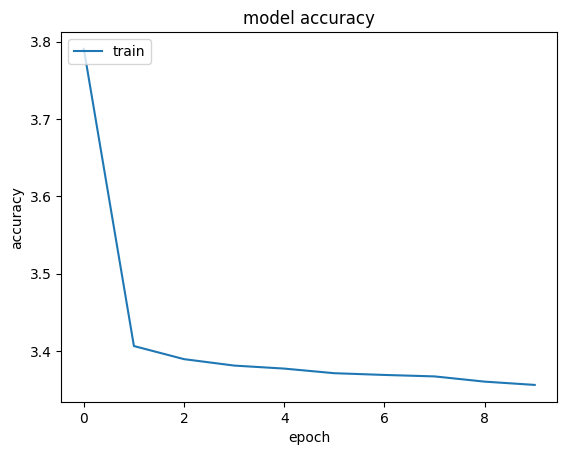

In [ ]:
# test run 10 epochs

tmp = "-%05d.weights.h5"%i #setting a file to save this iteration
filepath="checkpoints2/weights-improvement-{epoch:02d}-{loss:.4f}" + tmp
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
                               save_weights_only=True,
                             save_best_only=True, mode='min')
callbacks_list = [checkpoint, patience] #this checkpoint saves the model for this iteration
history = model.fit(X, y, epochs=EPOCHS, batch_size=1280,
                    callbacks=callbacks_list, shuffle=True)
plt.plot(history.history['loss'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
# generating a new sentence from the prompt for the first time
generatecharacters(model, pattern, 0)

### new sentence: 95380                                                                                                     


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.1558 - loss: 3.3565
Epoch 1: loss improved from inf to 3.34968, saving model to checkpoints2/weights-improvement-01-3.3497-00000.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.1559 - loss: 3.3561
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.1596 - loss: 3.3319
Epoch 2: loss improved from 3.34968 to 3.33858, saving model to checkpoints2/weights-improvement-02-3.3386-00000.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.1595 - loss: 3.3324
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.1599 - loss: 3.3203
Epoch 3: loss improved from 3.33858 to 3.32849, saving model to checkpoints2/weights-improvement-03-3.3285-00000.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.1597 - loss: 3.3208
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.1531 - loss: 3.3286
Epoch 4: loss improved from 3.32849 to 3.31623, saving model to

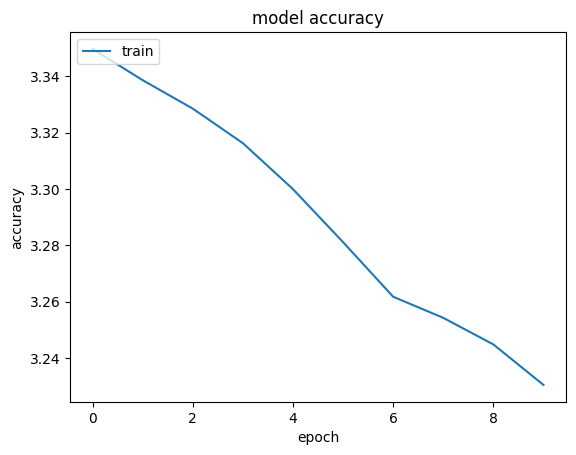

### new sentence: 0 $$$$$$                                                                                              
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.1619 - loss: 3.2297
Epoch 1: loss improved from inf to 3.21485, saving model to checkpoints2/weights-improvement-01-3.2149-00001.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.1618 - loss: 3.2287
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.1615 - loss: 3.1969
Epoch 2: loss improved from 3.21485 to 3.20442, saving model to checkpoints2/weights-improvement-02-3.2044-00001.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.1613 - loss: 3.1974
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.1654 - loss: 3.1938
Epoch 3: loss improved from 3.20442 to 3.19156, saving model to checkpoints2/weights-improvement-03-3.1916-00001.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.1653 - loss: 3.1937
Epoch 4/10
15/15 ━━━━━━━━━━━

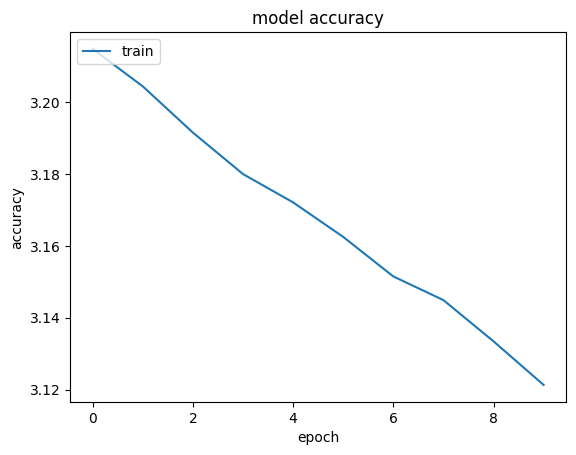

### new sentence: 1 $$$                                                                          )))))))))))))))<9~~~Zy 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.1777 - loss: 3.1082
Epoch 1: loss improved from inf to 3.11476, saving model to checkpoints2/weights-improvement-01-3.1148-00002.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.1776 - loss: 3.1086
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.1811 - loss: 3.1079
Epoch 2: loss improved from 3.11476 to 3.09680, saving model to checkpoints2/weights-improvement-02-3.0968-00002.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.1809 - loss: 3.1072
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.1798 - loss: 3.0756
Epoch 3: loss improved from 3.09680 to 3.09394, saving model to checkpoints2/weights-improvement-03-3.0939-00002.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.1797 - loss: 3.0767
Epoch 4/10
15/15 ━━━━━━━━━━━

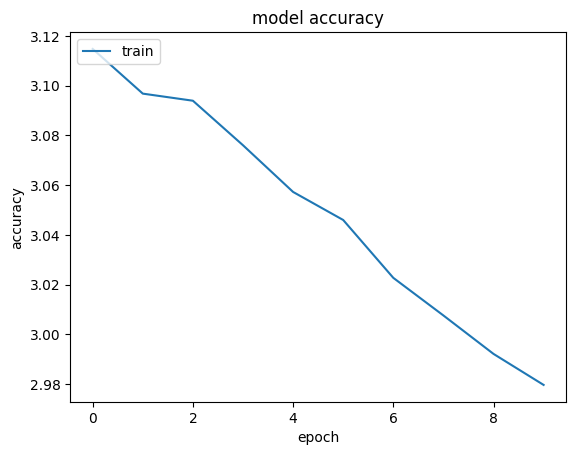

### new sentence: 2 A$                                                                            T,           T,    T<@
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.1973 - loss: 2.9693
Epoch 1: loss improved from inf to 2.96568, saving model to checkpoints2/weights-improvement-01-2.9657-00003.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.1974 - loss: 2.9691
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.2063 - loss: 2.9475
Epoch 2: loss improved from 2.96568 to 2.95703, saving model to checkpoints2/weights-improvement-02-2.9570-00003.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.2061 - loss: 2.9481
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.1979 - loss: 2.9601
Epoch 3: loss improved from 2.95703 to 2.94608, saving model to checkpoints2/weights-improvement-03-2.9461-00003.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.1981 - loss: 2.9592
Epoch 4/10
15/15 ━━━━━━━━━━━

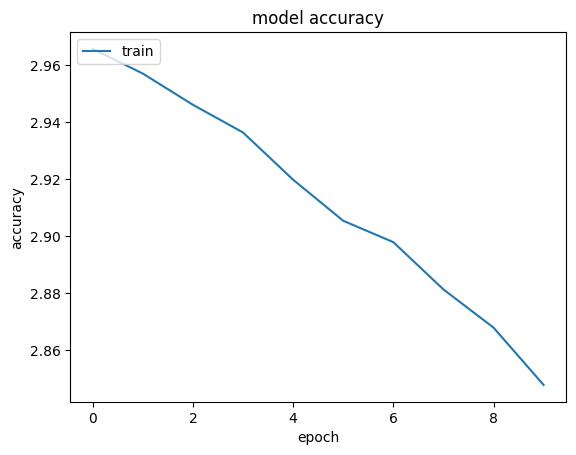

### new sentence: 3 \$     ie a   $ ae a      ae a       A$  T$   T$   T$   T$   T$   T$   T$   T$   T$   T$   T$  T$  T
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.2241 - loss: 2.8416
Epoch 1: loss improved from inf to 2.84263, saving model to checkpoints2/weights-improvement-01-2.8426-00004.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.2241 - loss: 2.8416
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.2288 - loss: 2.8088
Epoch 2: loss improved from 2.84263 to 2.82382, saving model to checkpoints2/weights-improvement-02-2.8238-00004.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.2286 - loss: 2.8097
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.2314 - loss: 2.8099
Epoch 3: loss improved from 2.82382 to 2.81635, saving model to checkpoints2/weights-improvement-03-2.8163-00004.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.2312 - loss: 2.8103
Epoch 4/10
15/15 ━━━━━━━━━━━

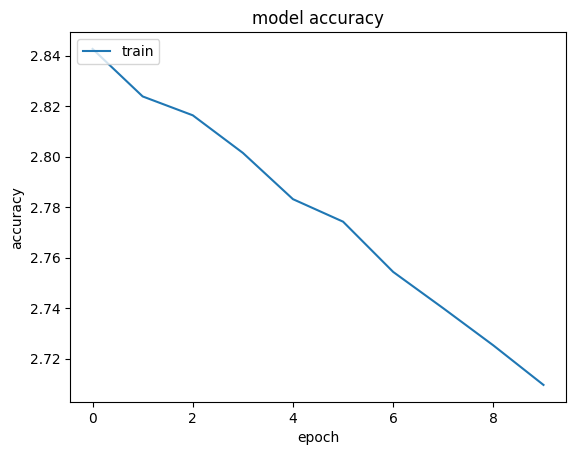

### new sentence: 4 \)     We a sooeer $\$ ih a sooer $\$ ih a sooer $\$ ih a soane $\$ ih a sooer $\$ ih a sooer $\$ ih
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.2502 - loss: 2.6965
Epoch 1: loss improved from inf to 2.69217, saving model to checkpoints2/weights-improvement-01-2.6922-00005.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.2503 - loss: 2.6962
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.2505 - loss: 2.6667
Epoch 2: loss improved from 2.69217 to 2.66882, saving model to checkpoints2/weights-improvement-02-2.6688-00005.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.2507 - loss: 2.6669
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.2645 - loss: 2.6375
Epoch 3: loss improved from 2.66882 to 2.64936, saving model to checkpoints2/weights-improvement-03-2.6494-00005.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.2642 - loss: 2.6382
Epoch 4/10
15/15 ━━━━━━━━━━━

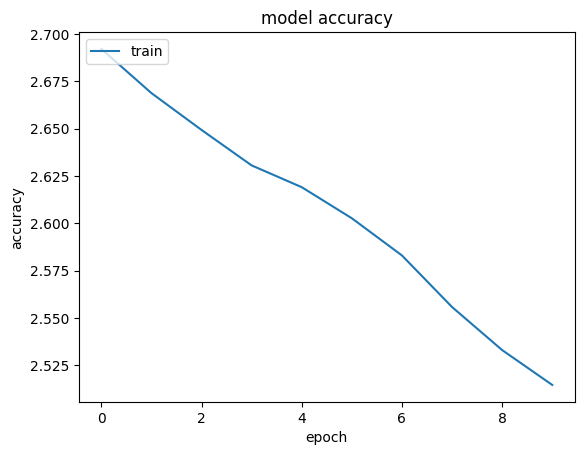

### new sentence: 5 \$    ie a soolll $\$-is a soane $\$-ih a soare $\$-ih a soater $\$--  ia a conellal aneeeri $\$ ie 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.2934 - loss: 2.5016
Epoch 1: loss improved from inf to 2.50334, saving model to checkpoints2/weights-improvement-01-2.5033-00006.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.2935 - loss: 2.5017
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.3053 - loss: 2.4612
Epoch 2: loss improved from 2.50334 to 2.47191, saving model to checkpoints2/weights-improvement-02-2.4719-00006.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.3052 - loss: 2.4619
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.3148 - loss: 2.4371
Epoch 3: loss improved from 2.47191 to 2.44289, saving model to checkpoints2/weights-improvement-03-2.4429-00006.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.3146 - loss: 2.4375
Epoch 4/10
15/15 ━━━━━━━━━━━

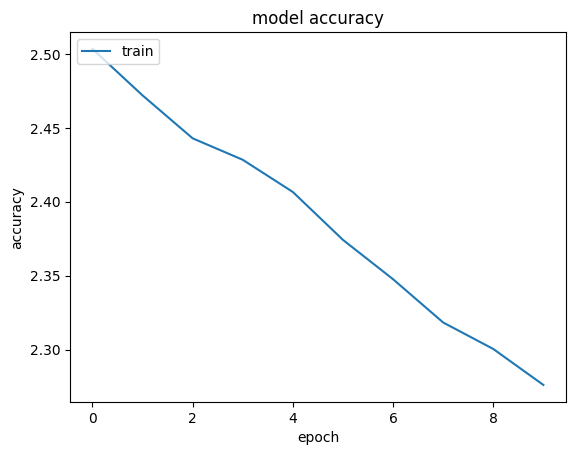

### new sentence: 6 \)    \ne a bonnl $\$-if a noneer $\$-ih a seme poee pf a fonterere of aie $Amgth A   ae a soooe the
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.3623 - loss: 2.2302
Epoch 1: loss improved from inf to 2.24234, saving model to checkpoints2/weights-improvement-01-2.2423-00007.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.3620 - loss: 2.2309
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.3776 - loss: 2.2035
Epoch 2: loss improved from 2.24234 to 2.21116, saving model to checkpoints2/weights-improvement-02-2.2112-00007.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.3772 - loss: 2.2039
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.3884 - loss: 2.1655
Epoch 3: loss improved from 2.21116 to 2.17670, saving model to checkpoints2/weights-improvement-03-2.1767-00007.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.3880 - loss: 2.1662
Epoch 4/10
15/15 ━━━━━━━━━━━

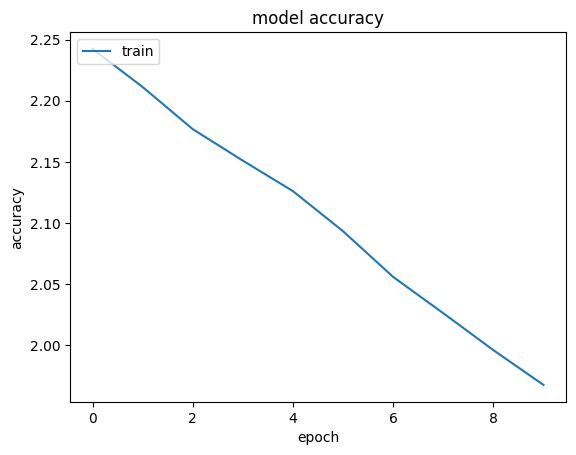

### new sentence: 7 A)   weenh the see fffeereee $\$    iodt $\$ ii a pomoeaall anmerer $M$ is a corecrrue seee teat tee
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.4586 - loss: 1.8950
Epoch 1: loss improved from inf to 1.91198, saving model to checkpoints2/weights-improvement-01-1.9120-00008.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.4582 - loss: 1.8960
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.4651 - loss: 1.8776
Epoch 2: loss improved from 1.91198 to 1.87762, saving model to checkpoints2/weights-improvement-02-1.8776-00008.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.4650 - loss: 1.8776
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.4836 - loss: 1.8127
Epoch 3: loss improved from 1.87762 to 1.84040, saving model to checkpoints2/weights-improvement-03-1.8404-00008.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.4829 - loss: 1.8145
Epoch 4/10
15/15 ━━━━━━━━━━━

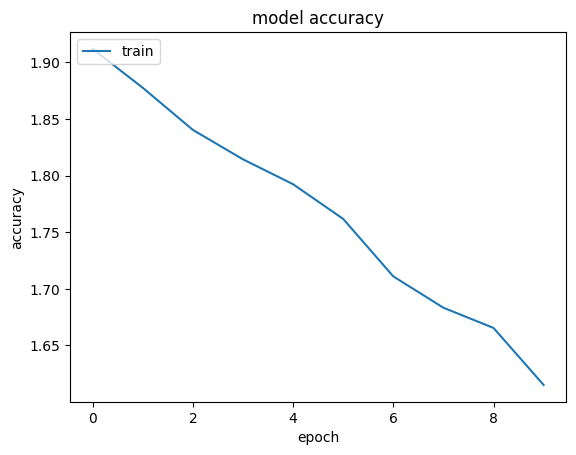

### new sentence: 8 A)  ih nheeete $\eam($$$ ie a $innpbaallllli   $-in $\maaeaa{{yy}}}}}}m} A    Wh a suoccleeeee  $$$a
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5437 - loss: 1.5851
Epoch 1: loss improved from inf to 1.58198, saving model to checkpoints2/weights-improvement-01-1.5820-00009.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.5438 - loss: 1.5849
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5588 - loss: 1.5313
Epoch 2: loss improved from 1.58198 to 1.54983, saving model to checkpoints2/weights-improvement-02-1.5498-00009.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.5583 - loss: 1.5324
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5689 - loss: 1.4912
Epoch 3: loss improved from 1.54983 to 1.51144, saving model to checkpoints2/weights-improvement-03-1.5114-00009.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.5686 - loss: 1.4924
Epoch 4/10
15/15 ━━━━━━━━━━━

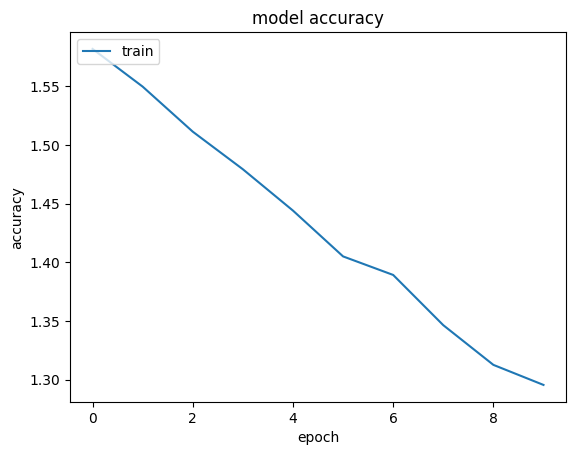

### new sentence: 9 \)= Tnn nheser $\\ammaa{ A  at a rrr $A$ if a fonbbrrr  \\rraa{{ A$  ih a forpu pue uf the teete ied
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6499 - loss: 1.2257
Epoch 1: loss improved from inf to 1.24496, saving model to checkpoints2/weights-improvement-01-1.2450-00010.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.6495 - loss: 1.2269
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6553 - loss: 1.2096
Epoch 2: loss improved from 1.24496 to 1.21709, saving model to checkpoints2/weights-improvement-02-1.2171-00010.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.6550 - loss: 1.2101
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.6675 - loss: 1.1573
Epoch 3: loss improved from 1.21709 to 1.18416, saving model to checkpoints2/weights-improvement-03-1.1842-00010.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.6670 - loss: 1.1590
Epoch 4/10
15/15 ━━━━━━━━━━━

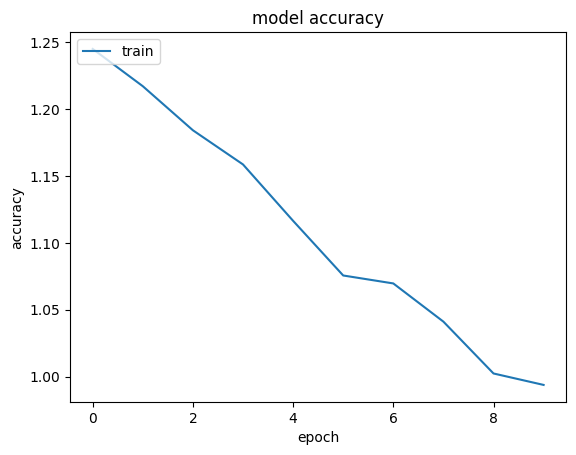

### new sentence: 10 (\f    \n nnos     ii i firi $A$-ma a c^ggg pfrurppppian Hldaara annibra  A$ aecu taat pae seli $\$ 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7319 - loss: 0.9429
Epoch 1: loss improved from inf to 0.96212, saving model to checkpoints2/weights-improvement-01-0.9621-00011.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.7315 - loss: 0.9441
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7382 - loss: 0.9265
Epoch 2: loss improved from 0.96212 to 0.92600, saving model to checkpoints2/weights-improvement-02-0.9260-00011.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.7381 - loss: 0.9265
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7578 - loss: 0.8794
Epoch 3: loss improved from 0.92600 to 0.89397, saving model to checkpoints2/weights-improvement-03-0.8940-00011.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.7573 - loss: 0.8803
Epoch 4/10
15/15 ━━━━━━━━━━

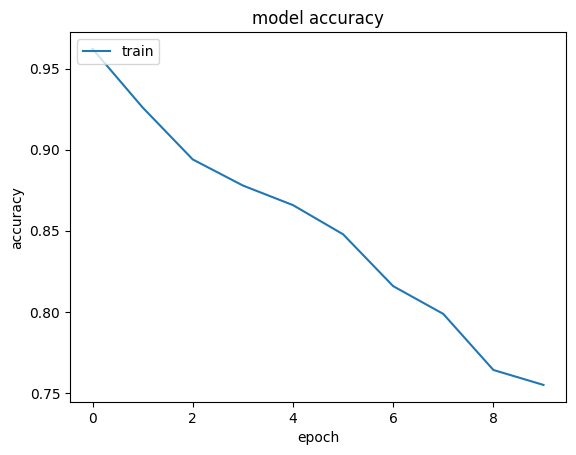

### new sentence: 11 (Tf =   nnv shtl $T$-ii i fiti paeeegppin alearrarrririoi if a gonttntllliee taeieridni.of thi doneb
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7969 - loss: 0.7228
Epoch 1: loss improved from inf to 0.72906, saving model to checkpoints2/weights-improvement-01-0.7291-00012.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.7968 - loss: 0.7232
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8071 - loss: 0.6972
Epoch 2: loss improved from 0.72906 to 0.70578, saving model to checkpoints2/weights-improvement-02-0.7058-00012.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.8071 - loss: 0.6977
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8133 - loss: 0.6749
Epoch 3: loss improved from 0.70578 to 0.69294, saving model to checkpoints2/weights-improvement-03-0.6929-00012.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.8128 - loss: 0.6761
Epoch 4/10
15/15 ━━━━━━━━━━

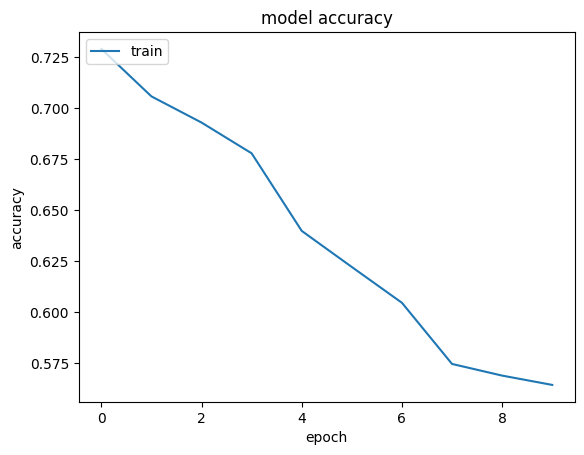

### new sentence: 12 ()  ie nhoccttsssss,rr e rercrere $A$,iohhheegeee,   aeehhhhhi,,    ae ahhvhethet Hnnmcradtad $$$$ih
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8504 - loss: 0.5442
Epoch 1: loss improved from inf to 0.54683, saving model to checkpoints2/weights-improvement-01-0.5468-00013.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.8503 - loss: 0.5444
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8609 - loss: 0.5167
Epoch 2: loss improved from 0.54683 to 0.52552, saving model to checkpoints2/weights-improvement-02-0.5255-00013.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.8607 - loss: 0.5172
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8611 - loss: 0.5156
Epoch 3: loss improved from 0.52552 to 0.52402, saving model to checkpoints2/weights-improvement-03-0.5240-00013.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.8609 - loss: 0.5162
Epoch 4/10
15/15 ━━━━━━━━━━

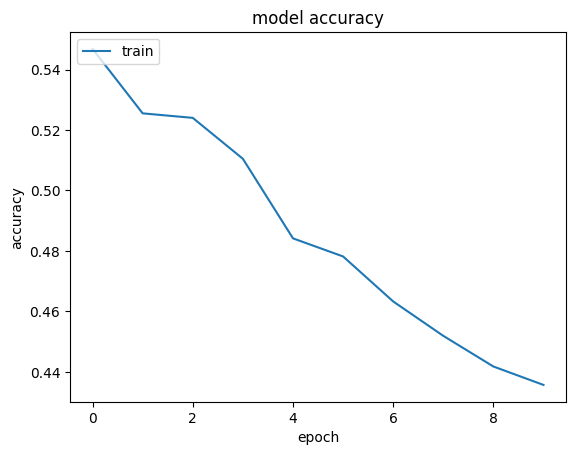

### new sentence: 13 ((  ie nhosettsss,rr thr srnpeteeeeeeee,$aaaaraaa $A$ is a Booocccque,sn $A$ is a poppt $C$-ooouue. 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8918 - loss: 0.4176
Epoch 1: loss improved from inf to 0.42322, saving model to checkpoints2/weights-improvement-01-0.4232-00014.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.8917 - loss: 0.4179
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8954 - loss: 0.4039
Epoch 2: loss improved from 0.42322 to 0.40589, saving model to checkpoints2/weights-improvement-02-0.4059-00014.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.8953 - loss: 0.4040
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8945 - loss: 0.3961
Epoch 3: loss improved from 0.40589 to 0.40189, saving model to checkpoints2/weights-improvement-03-0.4019-00014.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.8943 - loss: 0.3965
Epoch 4/10
15/15 ━━━━━━━━━━

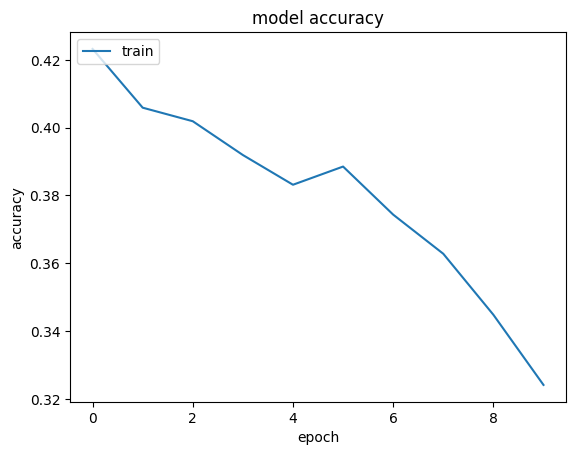

### new sentence: 14 ()  ie nhoeets shes rr srs mfmteeeeee th the $B$.spdnnluiiiiii inniiiio.tf th thcmfoooismmmmi ff ahv
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9220 - loss: 0.3183
Epoch 1: loss improved from inf to 0.32184, saving model to checkpoints2/weights-improvement-01-0.3218-00015.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9218 - loss: 0.3186
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9218 - loss: 0.3110
Epoch 2: loss improved from 0.32184 to 0.31867, saving model to checkpoints2/weights-improvement-02-0.3187-00015.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9216 - loss: 0.3115
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9240 - loss: 0.3048
Epoch 3: loss improved from 0.31867 to 0.31447, saving model to checkpoints2/weights-improvement-03-0.3145-00015.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.9236 - loss: 0.3054
Epoch 4/10
15/15 ━━━━━━━━━━

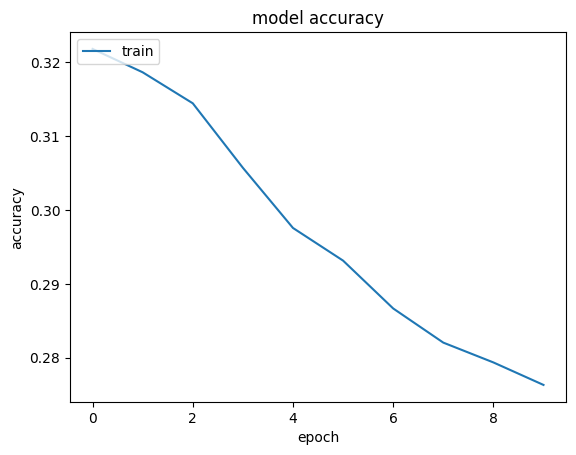

### new sentence: 15 ((  ie shocetsssss,crr the urruerere $$$aeraaaaaa{ah     isirhat wv attttpppc wn the selti malllvpon
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9366 - loss: 0.2570
Epoch 1: loss improved from inf to 0.25742, saving model to checkpoints2/weights-improvement-01-0.2574-00016.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9367 - loss: 0.2571
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9425 - loss: 0.2384
Epoch 2: loss improved from 0.25742 to 0.24801, saving model to checkpoints2/weights-improvement-02-0.2480-00016.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.9423 - loss: 0.2390
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9396 - loss: 0.2429
Epoch 3: loss did not improve from 0.24801
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9395 - loss: 0.2434
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9348 - loss: 0.2523
Epoch 4: loss did not 

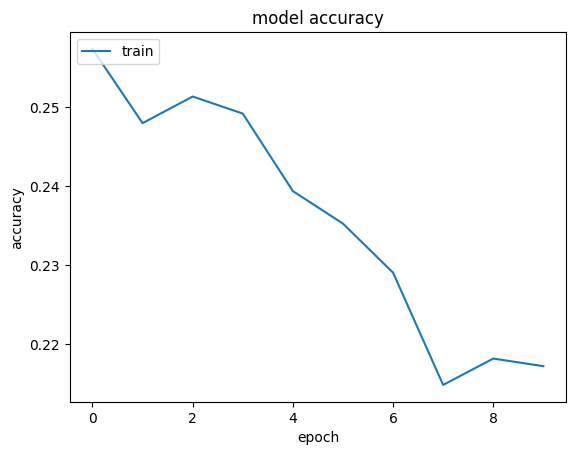

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'checkpoints2/weights-improvement-10-0.2172-00016.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
#cheap way to print out the intermediate sentences every 10 training steps

losses = []

# define the checkpoint
for i in range(RUNS):
  tmp = "-%05d.weights.h5"%i #setting a file to save this iteration
  filepath="checkpoints2/weights-improvement-{epoch:02d}-{loss:.4f}" + tmp
  checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
                               save_weights_only=True,
                             save_best_only=True, mode='min')
  callbacks_list = [checkpoint] #this checkpoint saves the model for this iteration
  history = model.fit(X, y, epochs=EPOCHS, batch_size=1280,
                    callbacks=callbacks_list, shuffle=True)

  plt.plot(history.history['loss'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  losses.append(history.history['loss'][-1])
  # The model weights (that are considered the best) are loaded into the model.
  model.load_weights(filepath.format(epoch=EPOCHS,
                                     loss=losses[-1]) )
  pattern = dataX[start]
  try:
    generatecharacters(model, pattern, i)
  except ValueError:
    print('generatecharacters failed')

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9467 - loss: 0.2103
Epoch 1: loss improved from inf to 0.21336, saving model to checkpoints2/weights-improvement-01-0.2134-00016.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9466 - loss: 0.2105
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9519 - loss: 0.2036
Epoch 2: loss improved from 0.21336 to 0.20801, saving model to checkpoints2/weights-improvement-02-0.2080-00016.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9518 - loss: 0.2039
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9507 - loss: 0.2100
Epoch 3: loss did not improve from 0.20801
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9504 - loss: 0.2105
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9504 - loss: 0.2039
Epoch 4: loss improved from 0.20801 to 0.20781, saving model to checkpoints2/weights-improvement-04-0.2078-00016.weights.h5
15/15 ━━━━━━━━━━━━━━

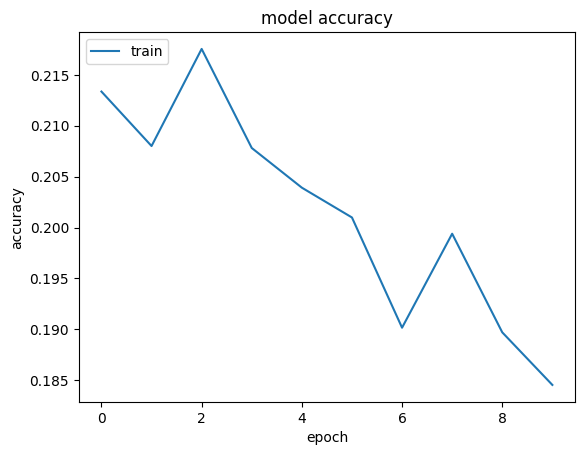

### new sentence: 16 ((ff nnnn f fenmmruuuui gn alddddaaara zeee $$$ oonnhaaa snattccnnnn af the zele aom$$T$.ih a $^$$00
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9565 - loss: 0.1788
Epoch 1: loss improved from inf to 0.18237, saving model to checkpoints2/weights-improvement-01-0.1824-00017.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9565 - loss: 0.1790
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9564 - loss: 0.1766
Epoch 2: loss improved from 0.18237 to 0.17941, saving model to checkpoints2/weights-improvement-02-0.1794-00017.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9564 - loss: 0.1768
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9575 - loss: 0.1717
Epoch 3: loss improved from 0.17941 to 0.17321, saving model to checkpoints2/weights-improvement-03-0.1732-00017.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9575 - loss: 0.1718
Epoch 4/10
15/15 ━━━━━━━━━━

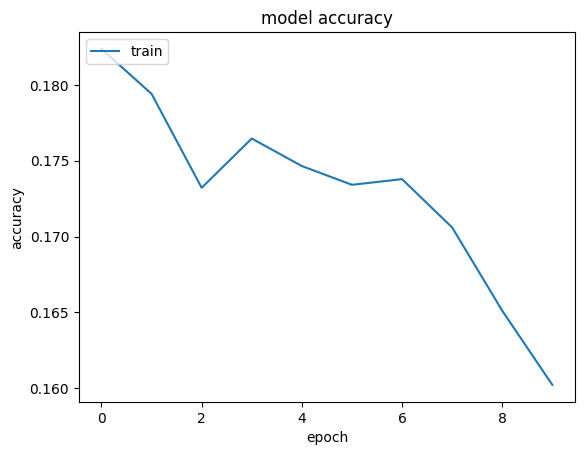

### new sentence: 17 ((\f    seccseii   aai$$B$ ssdddt $D$ iiiibbriii,ierrrrrr)iu a ceeeeeaaaeeyen  $$$asoiiiiiiggggyyy,}
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9621 - loss: 0.1544
Epoch 1: loss improved from inf to 0.15895, saving model to checkpoints2/weights-improvement-01-0.1590-00018.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9621 - loss: 0.1546
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9621 - loss: 0.1601
Epoch 2: loss did not improve from 0.15895
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9621 - loss: 0.1603
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9636 - loss: 0.1511
Epoch 3: loss improved from 0.15895 to 0.15621, saving model to checkpoints2/weights-improvement-03-0.1562-00018.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.9635 - loss: 0.1514
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9621 - loss: 0.1551
Epoch 4: loss did not 

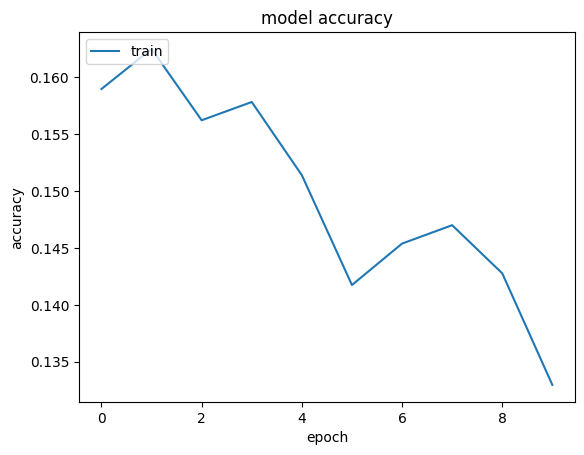

### new sentence: 18 ((\f    nn nsoset al tl  \$ -Snnnntovio  aeerreeeaaaa}h}    aff fha $2$\>=     bcddd\\lll   $$bsi $$
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9666 - loss: 0.1368
Epoch 1: loss improved from inf to 0.14413, saving model to checkpoints2/weights-improvement-01-0.1441-00019.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9665 - loss: 0.1373
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9646 - loss: 0.1451
Epoch 2: loss did not improve from 0.14413
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.9645 - loss: 0.1455
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9623 - loss: 0.1515
Epoch 3: loss did not improve from 0.14413
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9623 - loss: 0.1515
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9604 - loss: 0.1537
Epoch 4: loss did not improve from 0.14413
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9605 

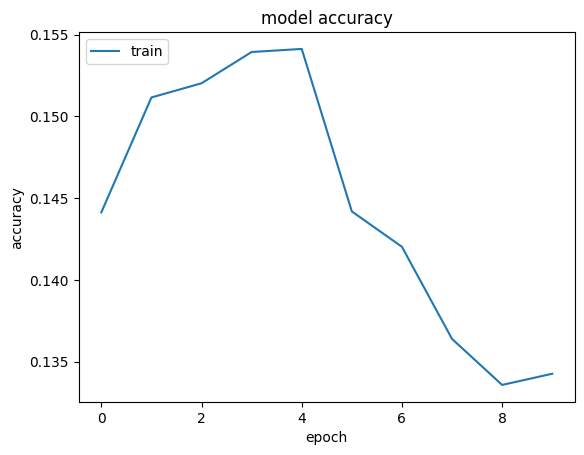

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'checkpoints2/weights-improvement-10-0.1343-00019.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
#restart from where we stopped...
for i in range(16, RUNS):
  tmp = "-%05d.weights.h5"%i #setting a file to save this iteration
  filepath="checkpoints2/weights-improvement-{epoch:02d}-{loss:.4f}" + tmp
  checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
                               save_weights_only=True,
                             save_best_only=True, mode='min')
  callbacks_list = [checkpoint] #this checkpoint saves the model for this iteration
  history = model.fit(X, y, epochs=EPOCHS, batch_size=1280,
                    callbacks=callbacks_list, shuffle=True)

  plt.plot(history.history['loss'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  losses.append(history.history['loss'][-1])
  # The model weights (that are considered the best) are loaded into the model.
  model.load_weights(filepath.format(epoch=EPOCHS,
                                     loss=losses[-1]) )
  pattern = dataX[start]
  try:
    generatecharacters(model, pattern, i)
  except ValueError:
    print('generatecharacters failed')

Code exited with an error message (did not save the model file cause the loss did not improve so it could not load it)
I restarted it manually

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9765 - loss: 0.1046
Epoch 1: loss improved from inf to 0.10649, saving model to checkpoints2/weights-improvement-01-0.1065-00019.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.9765 - loss: 0.1047
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9752 - loss: 0.1115
Epoch 2: loss did not improve from 0.10649
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9751 - loss: 0.1117
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9734 - loss: 0.1103
Epoch 3: loss did not improve from 0.10649
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.9734 - loss: 0.1103
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9762 - loss: 0.1072
Epoch 4: loss did not improve from 0.10649
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - accuracy: 0.9760 - loss: 0.1074
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9722 - loss: 0.1060
Epoch 5: loss did not

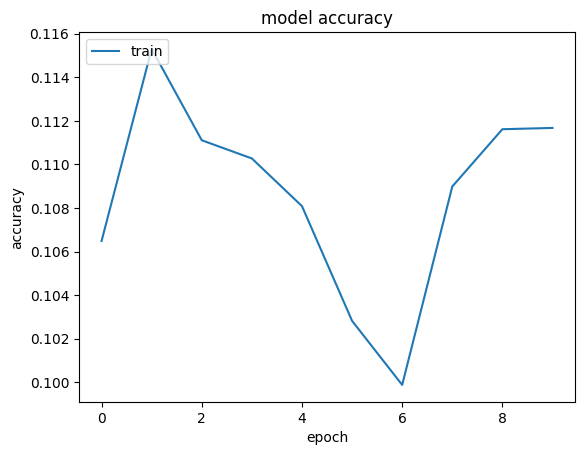

### new sentence: 19 (\frrbn^}hhh A   bs a seiicllaaadddddffeee{Q}Q{Z{Z{$}P|0}0}e}e}eee B)aoo t }etss opathliinn oneeee e
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9757 - loss: 0.1035
Epoch 1: loss improved from inf to 0.11013, saving model to checkpoints2/weights-improvement-01-0.1101-00020.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.9755 - loss: 0.1039
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9712 - loss: 0.1105
Epoch 2: loss did not improve from 0.11013
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.9712 - loss: 0.1105
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9755 - loss: 0.1022
Epoch 3: loss improved from 0.11013 to 0.10506, saving model to checkpoints2/weights-improvement-03-0.1051-00020.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9754 - loss: 0.1024
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9748 - loss: 0.1033
Epoch 4: loss improved

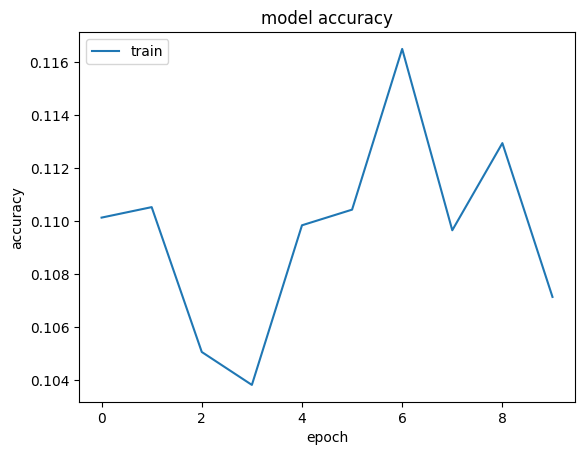

### new sentence: 20 (\fr =   Wh a tilt f fon rummmraaaaee,aeeerrrtt tf theee aalininnnnn rffwpot th a $iophhclllllmmmeff
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9718 - loss: 0.1067
Epoch 1: loss improved from inf to 0.10871, saving model to checkpoints2/weights-improvement-01-0.1087-00021.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9718 - loss: 0.1068
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9730 - loss: 0.1053
Epoch 2: loss improved from 0.10871 to 0.10730, saving model to checkpoints2/weights-improvement-02-0.1073-00021.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9729 - loss: 0.1054
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9762 - loss: 0.0981
Epoch 3: loss improved from 0.10730 to 0.09869, saving model to checkpoints2/weights-improvement-03-0.0987-00021.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9762 - loss: 0.0981
Epoch 4/10
15/15 ━━━━━━━━━━

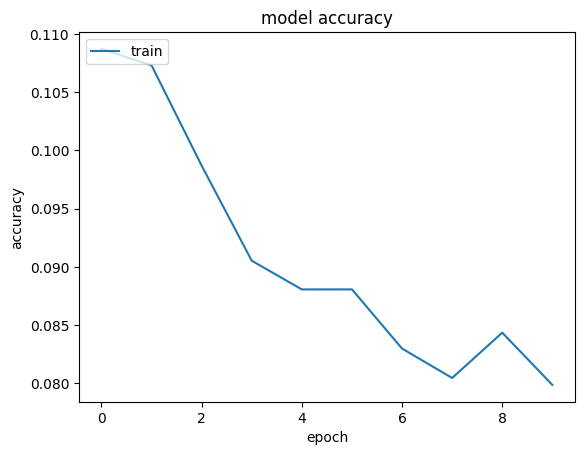

### new sentence: 21 ((fi nnn nnnn $\\atgaal A$$  $$L$,i,$,,$;$;ir a poadd dooeess lott $Bnmmsssss wn Anndttsslln Cnoct A
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9827 - loss: 0.0752
Epoch 1: loss improved from inf to 0.08306, saving model to checkpoints2/weights-improvement-01-0.0831-00022.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9825 - loss: 0.0757
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9802 - loss: 0.0810
Epoch 2: loss improved from 0.08306 to 0.08116, saving model to checkpoints2/weights-improvement-02-0.0812-00022.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9802 - loss: 0.0810
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9801 - loss: 0.0798
Epoch 3: loss improved from 0.08116 to 0.07993, saving model to checkpoints2/weights-improvement-03-0.0799-00022.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9801 - loss: 0.0799
Epoch 4/10
15/15 ━━━━━━━━━━

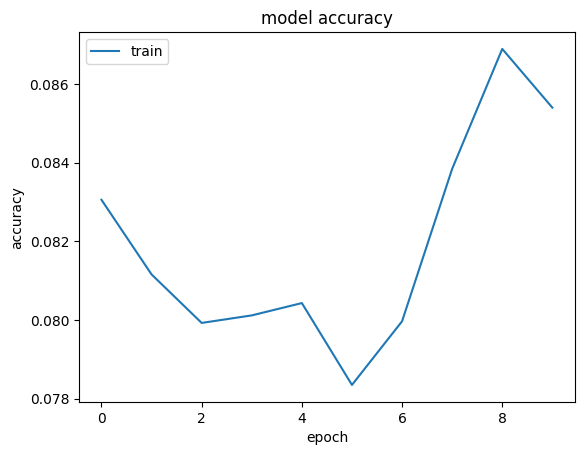

### new sentence: 22 ()\frnnnniiisivunnn A Aee a peeel $$$$fo aoseeegeeye,or ter cnnlrriocat bnreeaaoinn on e  Lee$$,, bs
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9790 - loss: 0.0861
Epoch 1: loss improved from inf to 0.08866, saving model to checkpoints2/weights-improvement-01-0.0887-00023.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9789 - loss: 0.0863
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9829 - loss: 0.0756
Epoch 2: loss improved from 0.08866 to 0.08086, saving model to checkpoints2/weights-improvement-02-0.0809-00023.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.9827 - loss: 0.0759
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9796 - loss: 0.0818
Epoch 3: loss did not improve from 0.08086
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9796 - loss: 0.0820
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9799 - loss: 0.0833
Epoch 4: loss did not 

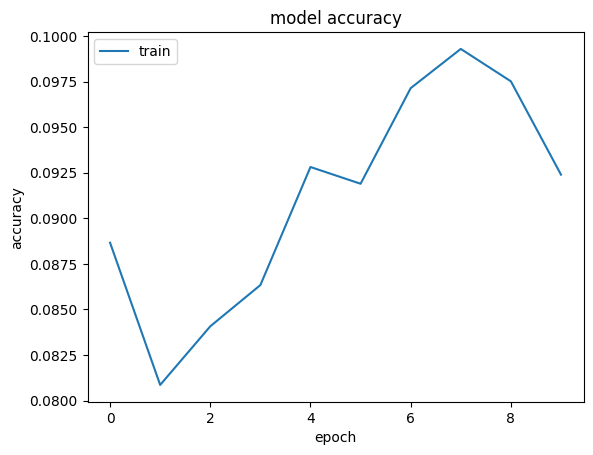

### new sentence: 23 ((ffrmnnnsisioinn    \ee $$^^a $A$iii b  ir aha fofpe ff pheeeern rfeer,$A___((\ma($A$iii a bnnnaanr
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9745 - loss: 0.0932
Epoch 1: loss improved from inf to 0.09257, saving model to checkpoints2/weights-improvement-01-0.0926-00024.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.9745 - loss: 0.0931
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9756 - loss: 0.0901
Epoch 2: loss improved from 0.09257 to 0.08873, saving model to checkpoints2/weights-improvement-02-0.0887-00024.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9756 - loss: 0.0900
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9798 - loss: 0.0813
Epoch 3: loss improved from 0.08873 to 0.08337, saving model to checkpoints2/weights-improvement-03-0.0834-00024.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9798 - loss: 0.0814
Epoch 4/10
15/15 ━━━━━━━━━━

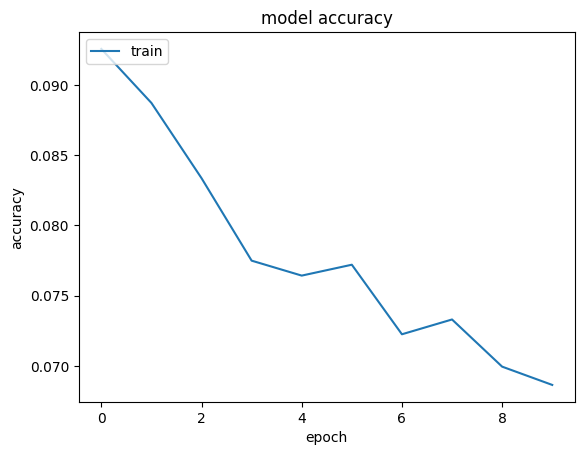

### new sentence: 24 ((ff    nn shes $B$\)b)   \(\)=    $$$$$$$$$$  z z,r,t,      zeeee $   ae a $CIg  \$ ih a zeeei a an
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9830 - loss: 0.0700
Epoch 1: loss improved from inf to 0.07089, saving model to checkpoints2/weights-improvement-01-0.0709-00025.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9829 - loss: 0.0701
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9803 - loss: 0.0747
Epoch 2: loss did not improve from 0.07089
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9803 - loss: 0.0748
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9787 - loss: 0.0796
Epoch 3: loss did not improve from 0.07089
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9788 - loss: 0.0795
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9806 - loss: 0.0771
Epoch 4: loss did not improve from 0.07089
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9805 

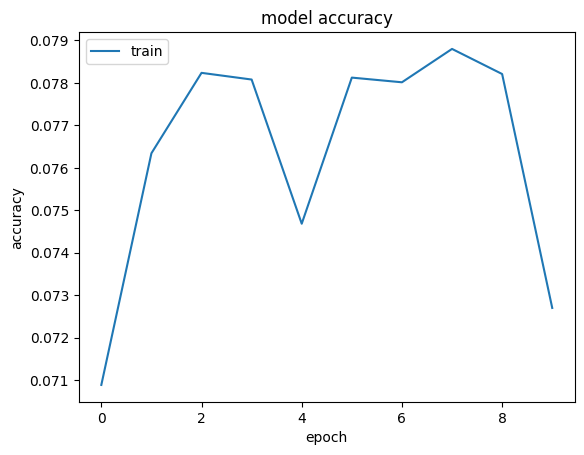

### new sentence: 25 (( if nnn c fommmirill Hlllcralllaaaaaiii(A_f ppe ooilriiiiaal aiyeuurru)in $A$ isds toat tee tett t
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9818 - loss: 0.0731
Epoch 1: loss improved from inf to 0.07493, saving model to checkpoints2/weights-improvement-01-0.0749-00026.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9818 - loss: 0.0732
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9796 - loss: 0.0753
Epoch 2: loss improved from 0.07493 to 0.07398, saving model to checkpoints2/weights-improvement-02-0.0740-00026.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.9796 - loss: 0.0752
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9838 - loss: 0.0690
Epoch 3: loss improved from 0.07398 to 0.06877, saving model to checkpoints2/weights-improvement-03-0.0688-00026.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.9838 - loss: 0.0689
Epoch 4/10
15/15 ━━━━━━━━━━

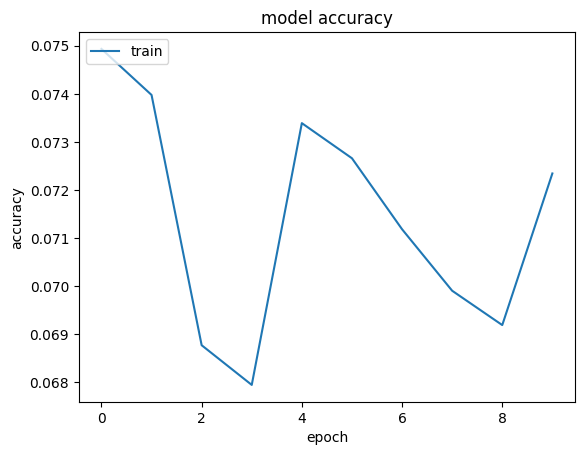

### new sentence: 26 ((  innnh $MG (aid $\, ih a niibbbllbliyi  $$ iiii $($,,,,,b,,ii iieeiidddiiss,ondtg.dya $A$ ipcrial
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9816 - loss: 0.0717
Epoch 1: loss improved from inf to 0.07485, saving model to checkpoints2/weights-improvement-01-0.0748-00027.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9815 - loss: 0.0719
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9773 - loss: 0.0836
Epoch 2: loss did not improve from 0.07485
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.9773 - loss: 0.0835
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9780 - loss: 0.0811
Epoch 3: loss did not improve from 0.07485
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.9780 - loss: 0.0812
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9791 - loss: 0.0784
Epoch 4: loss did not improve from 0.07485
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9791 

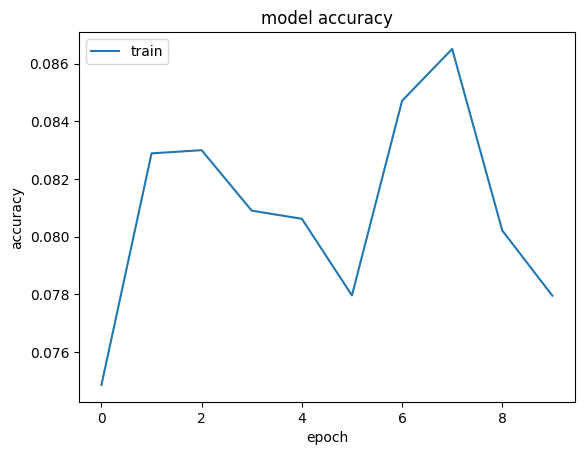

### new sentence: 27 ()\f|mmmmsiii inngggguu.M,  \ee ghaaurirrrnn in aanaallldddssss,sfooeve.thahhgggo. \$ .$ eeeuirrrvio
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9788 - loss: 0.0760
Epoch 1: loss improved from inf to 0.08017, saving model to checkpoints2/weights-improvement-01-0.0802-00028.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9787 - loss: 0.0763
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9790 - loss: 0.0782
Epoch 2: loss did not improve from 0.08017
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9788 - loss: 0.0785
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9765 - loss: 0.0876
Epoch 3: loss did not improve from 0.08017
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9765 - loss: 0.0874
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9803 - loss: 0.0757
Epoch 4: loss improved from 0.08017 to 0.07853, saving model to checkpoints2/weights-improvement-04-0.0

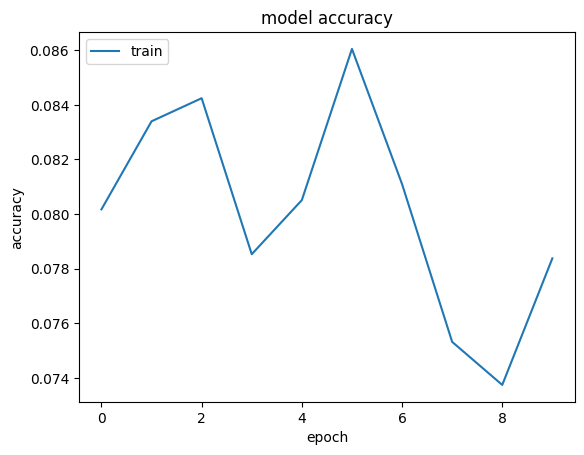

### new sentence: 28 ((  .fnnnnnn     aiiibrgggggg, A$  se ehesuetaanar,oirissssssssssss  T$ eseccsall  an thoweaaaeeee, 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9802 - loss: 0.0776
Epoch 1: loss improved from inf to 0.08103, saving model to checkpoints2/weights-improvement-01-0.0810-00029.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9801 - loss: 0.0778
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9763 - loss: 0.0848
Epoch 2: loss did not improve from 0.08103
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9763 - loss: 0.0847
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9800 - loss: 0.0768
Epoch 3: loss did not improve from 0.08103
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9799 - loss: 0.0771
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9790 - loss: 0.0790
Epoch 4: loss improved from 0.08103 to 0.07950, saving model to checkpoints2/weights-improvement-04-0.0

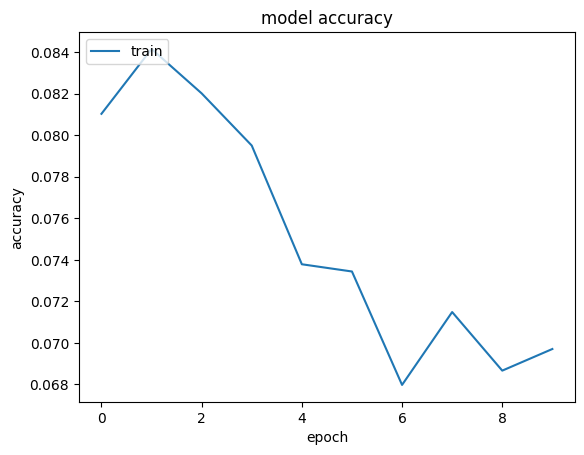

### new sentence: 29 (\} =  onnnnns    asmmlli $A$ is a cooisiiiiee, $$ \se $\Aammmct)X$$ to a soooaaalaliiiiii  \$ ps nh
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9797 - loss: 0.0730
Epoch 1: loss improved from inf to 0.07370, saving model to checkpoints2/weights-improvement-01-0.0737-00030.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9797 - loss: 0.0731
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9821 - loss: 0.0675
Epoch 2: loss improved from 0.07370 to 0.07366, saving model to checkpoints2/weights-improvement-02-0.0737-00030.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.9819 - loss: 0.0679
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9815 - loss: 0.0691
Epoch 3: loss improved from 0.07366 to 0.07197, saving model to checkpoints2/weights-improvement-03-0.0720-00030.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.9814 - loss: 0.0693
Epoch 4/10
15/15 ━━━━━━━━━━

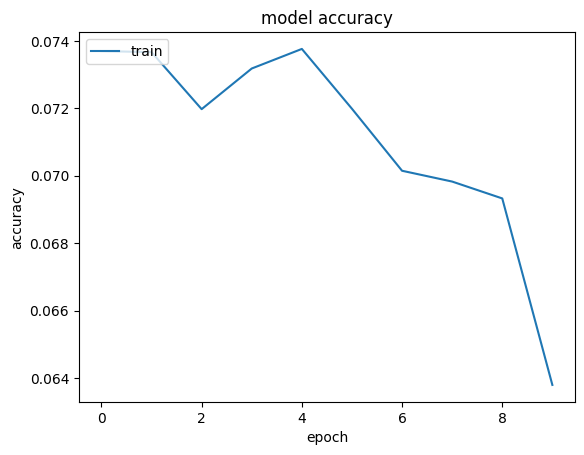

### new sentence: 30 ((ffrnnnn A  iii abie $\\2|hbh A|her $  see shes $\\gggea + $  .$\pppgg{a{aa    \so checcctiti in an
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9857 - loss: 0.0589
Epoch 1: loss improved from inf to 0.05924, saving model to checkpoints2/weights-improvement-01-0.0592-00031.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9857 - loss: 0.0589
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9833 - loss: 0.0629
Epoch 2: loss did not improve from 0.05924
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9834 - loss: 0.0628
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9863 - loss: 0.0544
Epoch 3: loss improved from 0.05924 to 0.05888, saving model to checkpoints2/weights-improvement-03-0.0589-00031.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.9862 - loss: 0.0546
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9837 - loss: 0.0607
Epoch 4: loss did not 

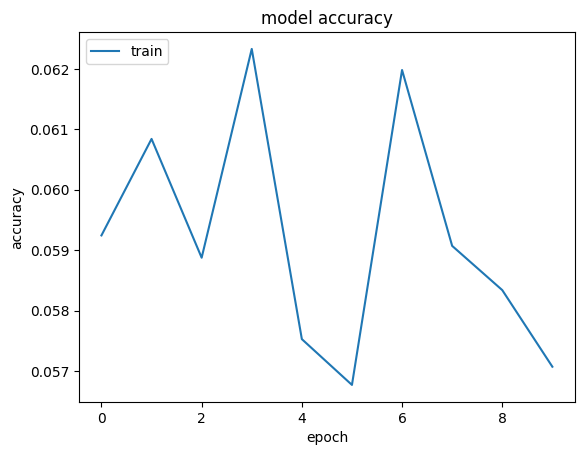

### new sentence: 31 (ffrnnn)A)$ $$$$Ln{pppppp     Lzeehasll     se aslssnttt wn sreelldds $Th csovccrrvv on $A$   Smd $A
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9852 - loss: 0.0581
Epoch 1: loss improved from inf to 0.05963, saving model to checkpoints2/weights-improvement-01-0.0596-00032.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9852 - loss: 0.0582
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9831 - loss: 0.0619
Epoch 2: loss did not improve from 0.05963
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9831 - loss: 0.0620
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9835 - loss: 0.0602
Epoch 3: loss did not improve from 0.05963
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9835 - loss: 0.0604
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9818 - loss: 0.0693
Epoch 4: loss did not improve from 0.05963
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.9818 

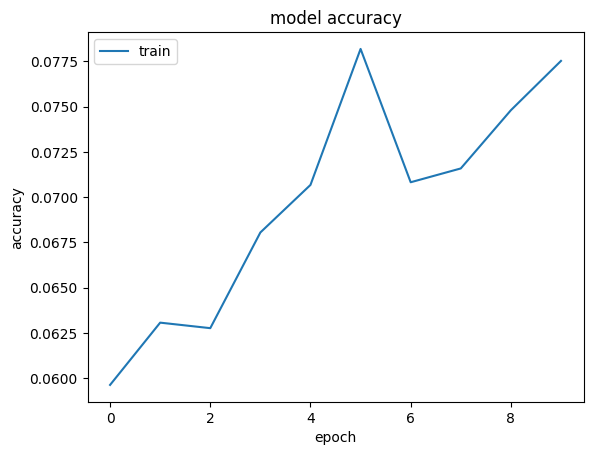

### new sentence: 32 ((  innnn in a panixarrra an a  anrnrrn $C$ ooarrarrrver,rfrhererrrrhr$'fe phpeepuhth ao a soirnnddc
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9804 - loss: 0.0719
Epoch 1: loss improved from inf to 0.07308, saving model to checkpoints2/weights-improvement-01-0.0731-00033.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9803 - loss: 0.0720
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9811 - loss: 0.0697
Epoch 2: loss improved from 0.07308 to 0.07010, saving model to checkpoints2/weights-improvement-02-0.0701-00033.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9811 - loss: 0.0698
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9786 - loss: 0.0710
Epoch 3: loss did not improve from 0.07010
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9786 - loss: 0.0711
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9830 - loss: 0.0628
Epoch 4: loss improved

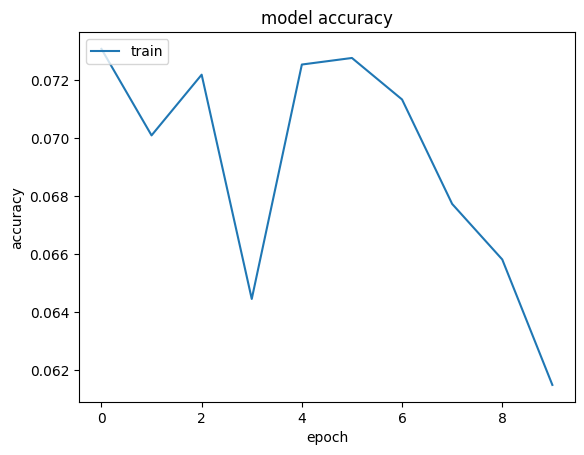

### new sentence: 33 ffrrrrrr^nn A    $$$  Cpppict-c^p(}((\(\\gppphaththhht A   be   $^^eevp\t\ t=aaabiiiiiiii in a peefe
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9834 - loss: 0.0546
Epoch 1: loss improved from inf to 0.05735, saving model to checkpoints2/weights-improvement-01-0.0574-00034.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.9834 - loss: 0.0548
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9857 - loss: 0.0538
Epoch 2: loss improved from 0.05735 to 0.05639, saving model to checkpoints2/weights-improvement-02-0.0564-00034.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9857 - loss: 0.0540
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9860 - loss: 0.0553
Epoch 3: loss improved from 0.05639 to 0.05531, saving model to checkpoints2/weights-improvement-03-0.0553-00034.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9860 - loss: 0.0553
Epoch 4/10
15/15 ━━━━━━━━━━

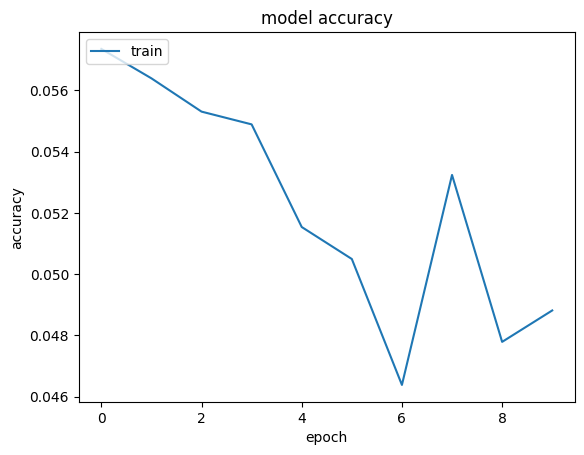

### new sentence: 34 (ffrrbn)A $$$$$$$$$Tapppeaa$$ bbbiiiii   $\,  $$$$$$ipp ppetea  \\rbba{a{a{    aaaaga{\Mgqq,A)\_qqsq
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9871 - loss: 0.0506
Epoch 1: loss improved from inf to 0.05309, saving model to checkpoints2/weights-improvement-01-0.0531-00035.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9870 - loss: 0.0507
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9836 - loss: 0.0582
Epoch 2: loss did not improve from 0.05309
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9836 - loss: 0.0584
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9822 - loss: 0.0641
Epoch 3: loss did not improve from 0.05309
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9821 - loss: 0.0643
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9814 - loss: 0.0674
Epoch 4: loss did not improve from 0.05309
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9814 

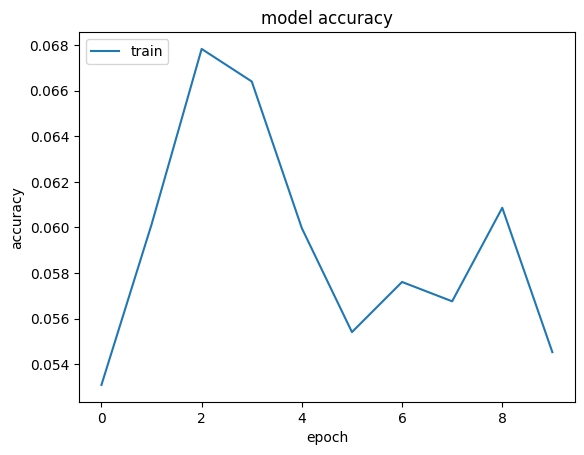

### new sentence: 35 ((ff    on shoo $$$$iiirbriii  A$ is a Boggcclaaa dnceeeeeeddddyios oooorruuuoo  \e assoaaaaa aqar a
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9854 - loss: 0.0554
Epoch 1: loss improved from inf to 0.05813, saving model to checkpoints2/weights-improvement-01-0.0581-00036.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9853 - loss: 0.0555
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9848 - loss: 0.0568
Epoch 2: loss improved from 0.05813 to 0.05771, saving model to checkpoints2/weights-improvement-02-0.0577-00036.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.9847 - loss: 0.0568
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9832 - loss: 0.0590
Epoch 3: loss did not improve from 0.05771
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9833 - loss: 0.0590
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9819 - loss: 0.0604
Epoch 4: loss did not 

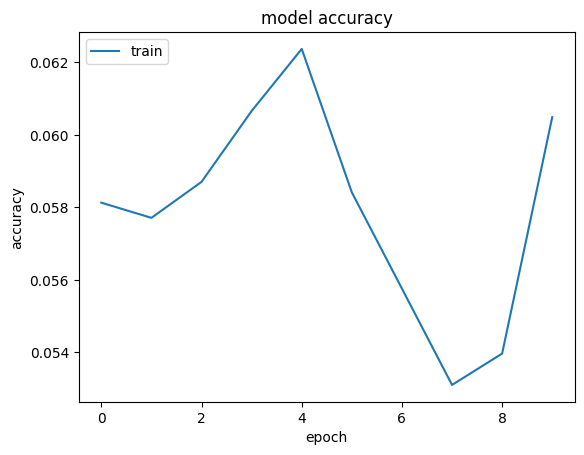

### new sentence: 36 (ff   xonnnnii    BB{)))iidddba in aye $aoa$$A,,bsdtt $A$$iimiueei $T$ ii i cincclbbee ge $A$ ihdcc,
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9822 - loss: 0.0640
Epoch 1: loss improved from inf to 0.06367, saving model to checkpoints2/weights-improvement-01-0.0637-00037.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9822 - loss: 0.0640
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9816 - loss: 0.0600
Epoch 2: loss improved from 0.06367 to 0.06186, saving model to checkpoints2/weights-improvement-02-0.0619-00037.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9816 - loss: 0.0601
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9797 - loss: 0.0721
Epoch 3: loss did not improve from 0.06186
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9797 - loss: 0.0721
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9795 - loss: 0.0693
Epoch 4: loss did not 

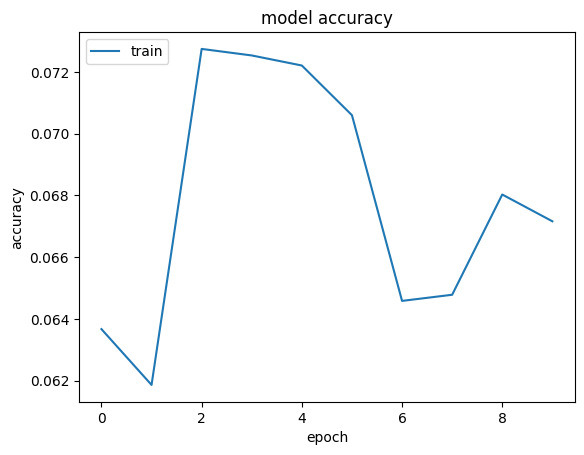

### new sentence: 37 (\f =  nn nnvs $\$\))i)\))) Tn ann andteeee  Keiiiiii  A  is i coriteeiivi in ainallllridi iyyeetyo.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9796 - loss: 0.0661
Epoch 1: loss improved from inf to 0.06375, saving model to checkpoints2/weights-improvement-01-0.0637-00038.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9797 - loss: 0.0660
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9823 - loss: 0.0637
Epoch 2: loss improved from 0.06375 to 0.06236, saving model to checkpoints2/weights-improvement-02-0.0624-00038.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.9823 - loss: 0.0636
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9835 - loss: 0.0572
Epoch 3: loss improved from 0.06236 to 0.05938, saving model to checkpoints2/weights-improvement-03-0.0594-00038.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9835 - loss: 0.0574
Epoch 4/10
15/15 ━━━━━━━━━━

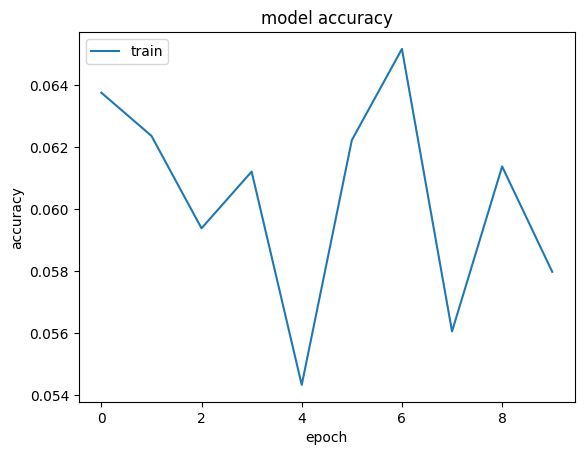

### new sentence: 38 ((  innnn $M$ aiiidd   is aooonnnnevemn,si $A$ as she cllllaaae de a $S$$Shdeaddlly  ti thy zeet the
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9842 - loss: 0.0546
Epoch 1: loss improved from inf to 0.05413, saving model to checkpoints2/weights-improvement-01-0.0541-00039.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9842 - loss: 0.0546
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9852 - loss: 0.0490
Epoch 2: loss improved from 0.05413 to 0.05048, saving model to checkpoints2/weights-improvement-02-0.0505-00039.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9852 - loss: 0.0491
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9851 - loss: 0.0506
Epoch 3: loss improved from 0.05048 to 0.04976, saving model to checkpoints2/weights-improvement-03-0.0498-00039.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9852 - loss: 0.0506
Epoch 4/10
15/15 ━━━━━━━━━━

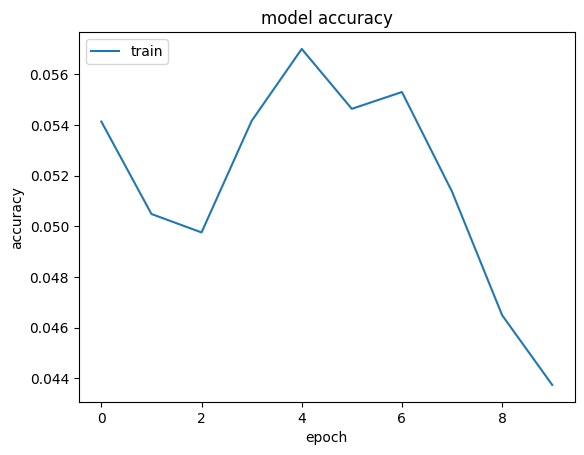

### new sentence: 39 (ff   fnn nhf $\nnmba   wh $B$ ih pheteeef momiiarr $\$Aaldmlddlll wrosssssssss seec onnnnnnnmssss i
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9877 - loss: 0.0428
Epoch 1: loss improved from inf to 0.04815, saving model to checkpoints2/weights-improvement-01-0.0481-00040.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9876 - loss: 0.0432
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9814 - loss: 0.0641
Epoch 2: loss did not improve from 0.04815
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.9813 - loss: 0.0644
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9777 - loss: 0.0749
Epoch 3: loss did not improve from 0.04815
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9778 - loss: 0.0747
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9821 - loss: 0.0626
Epoch 4: loss did not improve from 0.04815
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9820 

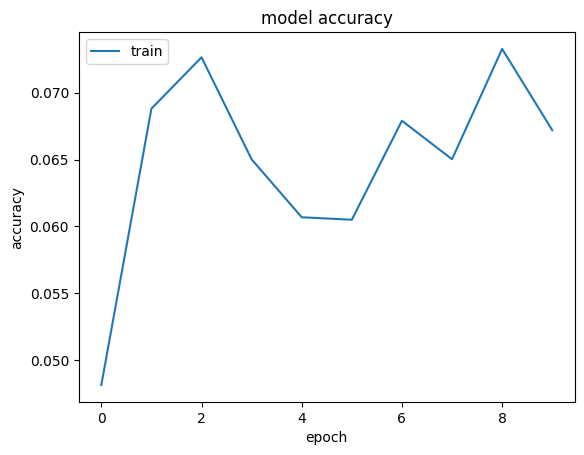

### new sentence: 40 ((  Inn shf teete ff $\\{i{hhereb}ebel-A)$(ioccssipp  \$=.\\l a\g the seam ffa tiib $\$  ss ooooerrc
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9838 - loss: 0.0592
Epoch 1: loss improved from inf to 0.05924, saving model to checkpoints2/weights-improvement-01-0.0592-00041.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9837 - loss: 0.0592
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9820 - loss: 0.0628
Epoch 2: loss did not improve from 0.05924
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9820 - loss: 0.0627
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9840 - loss: 0.0559
Epoch 3: loss improved from 0.05924 to 0.05723, saving model to checkpoints2/weights-improvement-03-0.0572-00041.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9839 - loss: 0.0560
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9831 - loss: 0.0625
Epoch 4: loss did not 

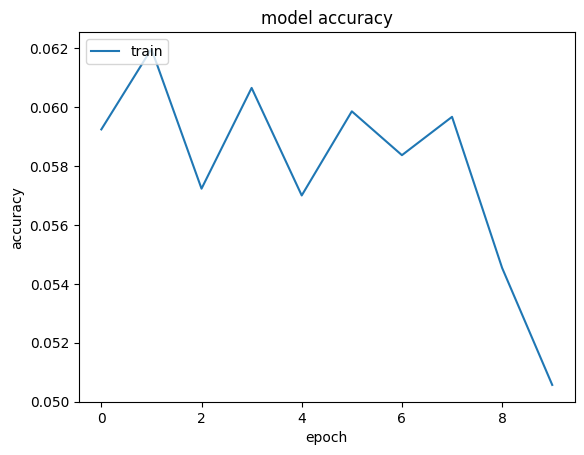

### new sentence: 41 (\f    nnnssssi if a foroooii aeyeeaternrnrn of a derell  W$   ooiiuebbMvy,,  aiiphet     be a aopii
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9854 - loss: 0.0491
Epoch 1: loss improved from inf to 0.05019, saving model to checkpoints2/weights-improvement-01-0.0502-00042.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9855 - loss: 0.0492
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9877 - loss: 0.0460
Epoch 2: loss improved from 0.05019 to 0.04771, saving model to checkpoints2/weights-improvement-02-0.0477-00042.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9876 - loss: 0.0461
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9845 - loss: 0.0534
Epoch 3: loss did not improve from 0.04771
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9845 - loss: 0.0533
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9858 - loss: 0.0530
Epoch 4: loss did not 

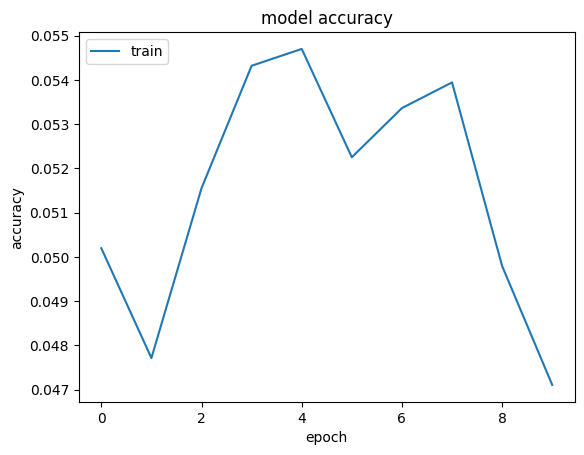

### new sentence: 42 (:  innnn $M_aa(A))ii a Ponpmbrlllnnnn      fn ahfe cuuuudddnn te a mepaa $leett)$$$$teataaa     is 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9857 - loss: 0.0467
Epoch 1: loss improved from inf to 0.04631, saving model to checkpoints2/weights-improvement-01-0.0463-00043.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.9857 - loss: 0.0467
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9862 - loss: 0.0453
Epoch 2: loss did not improve from 0.04631
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9862 - loss: 0.0455
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9852 - loss: 0.0486
Epoch 3: loss did not improve from 0.04631
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9852 - loss: 0.0486
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9864 - loss: 0.0466
Epoch 4: loss did not improve from 0.04631
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9863 

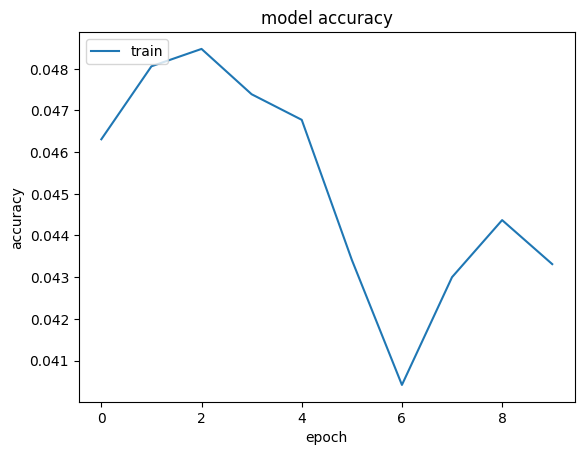

### new sentence: 43 (\f    nn shss $\$\)-)\)\)\)\)\)$   T<<),w)A)  Ts e,zet S-----\n \)    Te a,tpte aaarr- an nne kent 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9872 - loss: 0.0445
Epoch 1: loss improved from inf to 0.04737, saving model to checkpoints2/weights-improvement-01-0.0474-00044.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9871 - loss: 0.0446
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9873 - loss: 0.0482
Epoch 2: loss did not improve from 0.04737
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9872 - loss: 0.0483
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9835 - loss: 0.0547
Epoch 3: loss did not improve from 0.04737
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9835 - loss: 0.0545
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9833 - loss: 0.0541
Epoch 4: loss did not improve from 0.04737
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9833 

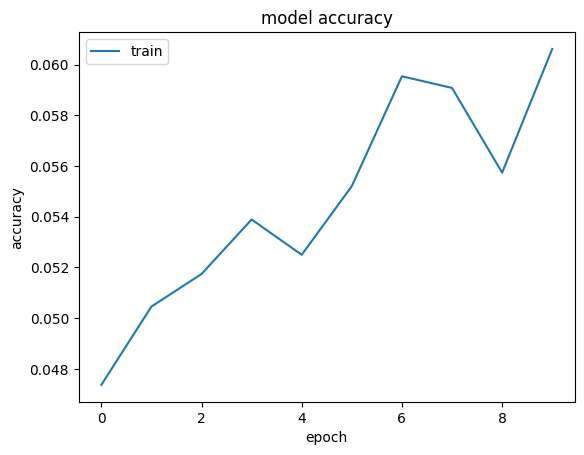

### new sentence: 44 ((  fnnnn $   saabifii  \peteraa b$    ..\{{rrl{{   \,,iiiphgit }eeeee aop aepeeeeeee ta $A$,anoo tn
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9813 - loss: 0.0590
Epoch 1: loss improved from inf to 0.06496, saving model to checkpoints2/weights-improvement-01-0.0650-00045.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9812 - loss: 0.0593
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9829 - loss: 0.0592
Epoch 2: loss improved from 0.06496 to 0.06232, saving model to checkpoints2/weights-improvement-02-0.0623-00045.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9829 - loss: 0.0594
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9799 - loss: 0.0628
Epoch 3: loss did not improve from 0.06232
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9798 - loss: 0.0632
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9746 - loss: 0.0780
Epoch 4: loss did not 

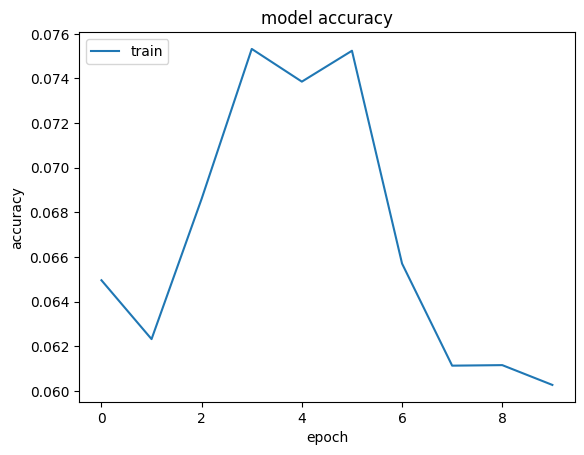

### new sentence: 45 (( \f nhnnedtyyyy,sfrgr,re eeeeereriry  A$metthrrriioooosm of a dunnlluyed fe ahnreee th e caaaan  s
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9852 - loss: 0.0551
Epoch 1: loss improved from inf to 0.05760, saving model to checkpoints2/weights-improvement-01-0.0576-00046.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.9851 - loss: 0.0553
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9824 - loss: 0.0566
Epoch 2: loss improved from 0.05760 to 0.05748, saving model to checkpoints2/weights-improvement-02-0.0575-00046.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9824 - loss: 0.0567
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9860 - loss: 0.0472
Epoch 3: loss improved from 0.05748 to 0.04894, saving model to checkpoints2/weights-improvement-03-0.0489-00046.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.9860 - loss: 0.0473
Epoch 4/10
15/15 ━━━━━━━━━━

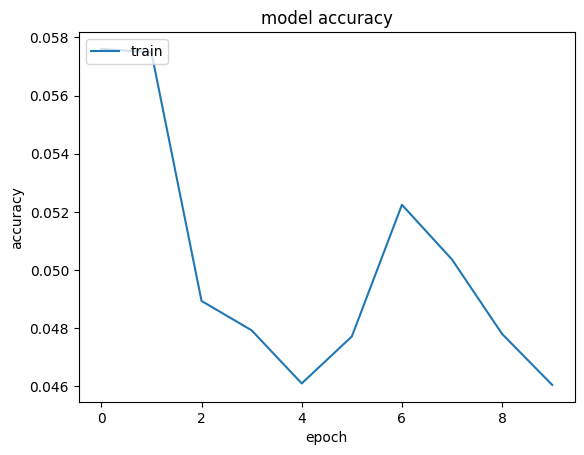

### new sentence: 46 ((  \nn nhe C\\pirinn Snrccti $A$-bh alllnrrrrsolll  fe trr urttlsssssttyyeseege.H  annicrh.t tebbb 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9868 - loss: 0.0445
Epoch 1: loss improved from inf to 0.04521, saving model to checkpoints2/weights-improvement-01-0.0452-00047.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9868 - loss: 0.0446
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9852 - loss: 0.0452
Epoch 2: loss did not improve from 0.04521
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9852 - loss: 0.0453
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9864 - loss: 0.0456
Epoch 3: loss did not improve from 0.04521
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9864 - loss: 0.0456
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9860 - loss: 0.0466
Epoch 4: loss did not improve from 0.04521
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9859 

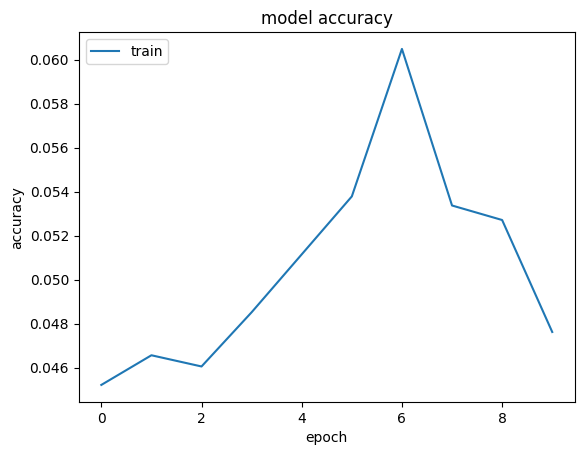

### new sentence: 47 ((  Inn sheseteze,sl sheddttihhhsssssss,oh the zeatalgaaa bammyyoo.oobbesss.of a cothhcnlll aaaaa  a
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9867 - loss: 0.0465
Epoch 1: loss improved from inf to 0.04653, saving model to checkpoints2/weights-improvement-01-0.0465-00048.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9867 - loss: 0.0465
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9867 - loss: 0.0444
Epoch 2: loss improved from 0.04653 to 0.04302, saving model to checkpoints2/weights-improvement-02-0.0430-00048.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.9867 - loss: 0.0443
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9872 - loss: 0.0434
Epoch 3: loss did not improve from 0.04302
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9872 - loss: 0.0434
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9901 - loss: 0.0353
Epoch 4: loss improved

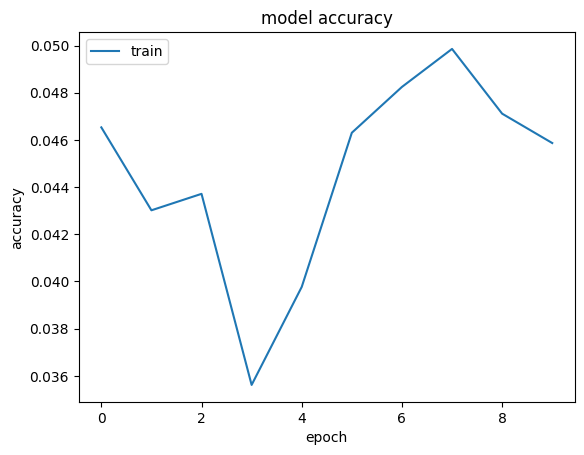

### new sentence: 48 ((   Inn shtwett (\\\mhaall_} A    \n a trill aroevsnnnn onlalaallala  a$ ae a $\rribbaaalivi  n$$$$
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9883 - loss: 0.0409
Epoch 1: loss improved from inf to 0.04116, saving model to checkpoints2/weights-improvement-01-0.0412-00049.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9883 - loss: 0.0409
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9899 - loss: 0.0372
Epoch 2: loss improved from 0.04116 to 0.03815, saving model to checkpoints2/weights-improvement-02-0.0382-00049.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9898 - loss: 0.0372
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9891 - loss: 0.0360
Epoch 3: loss improved from 0.03815 to 0.03776, saving model to checkpoints2/weights-improvement-03-0.0378-00049.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9891 - loss: 0.0361
Epoch 4/10
15/15 ━━━━━━━━━━

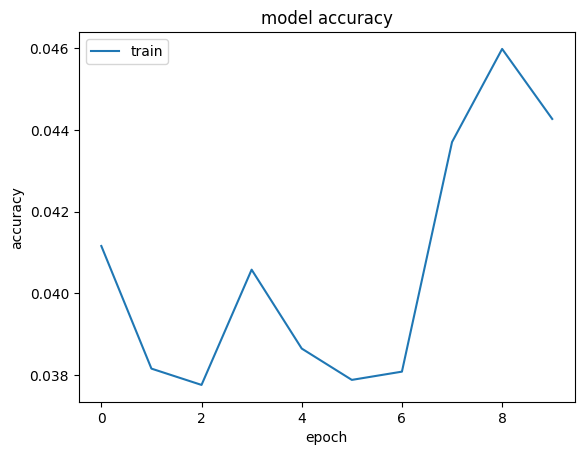

### new sentence: 49 ((\fr A    Wrdttall $  ai{ar{{[[[t }$,  aee appaspptalnzereeeeeeeeZrZ}Zrrr0}}2}||ecBB.B)3oouuerivioi
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9886 - loss: 0.0409
Epoch 1: loss improved from inf to 0.04214, saving model to checkpoints2/weights-improvement-01-0.0421-00050.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9886 - loss: 0.0410
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9878 - loss: 0.0415
Epoch 2: loss did not improve from 0.04214
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.9878 - loss: 0.0416
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9874 - loss: 0.0438
Epoch 3: loss did not improve from 0.04214
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9874 - loss: 0.0438
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9869 - loss: 0.0470
Epoch 4: loss did not improve from 0.04214
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9869 

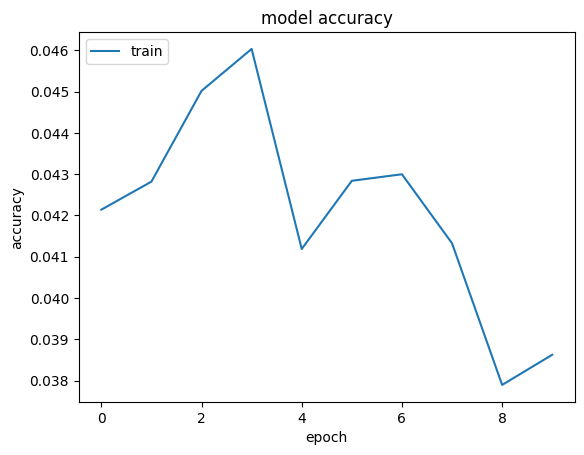

### new sentence: 50 \)\)= fn nhrr i lllttmcllll aldaaaaad  \$$$$$ioongaaaa deeeeooo on $b$ ihtheeteet $$$$,eeehhatyye,of
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9866 - loss: 0.0425
Epoch 1: loss improved from inf to 0.06094, saving model to checkpoints2/weights-improvement-01-0.0609-00051.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9862 - loss: 0.0436
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9708 - loss: 0.0955
Epoch 2: loss did not improve from 0.06094
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9708 - loss: 0.0955
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9756 - loss: 0.0790
Epoch 3: loss did not improve from 0.06094
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.9756 - loss: 0.0790
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9803 - loss: 0.0636
Epoch 4: loss did not improve from 0.06094
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9802 

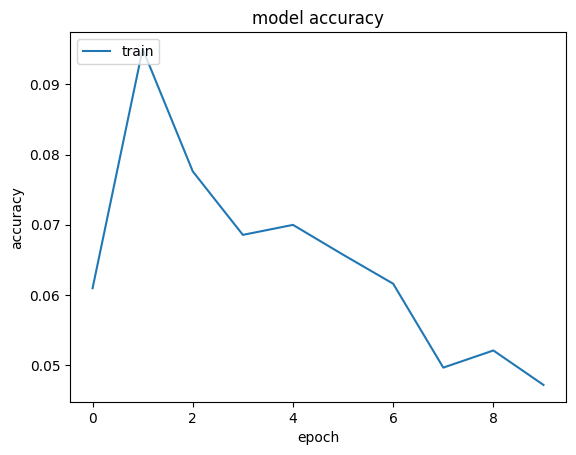

### new sentence: 51 fff ffrrhrssuunnnnn t   \sd $L\a((is a pincppppppg,bnsgeabyyyy. Retirrrdll  annnna{io}}}}}    $ in n
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9866 - loss: 0.0442
Epoch 1: loss improved from inf to 0.04779, saving model to checkpoints2/weights-improvement-01-0.0478-00052.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9865 - loss: 0.0444
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9866 - loss: 0.0459
Epoch 2: loss did not improve from 0.04779
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.9865 - loss: 0.0461
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9843 - loss: 0.0532
Epoch 3: loss did not improve from 0.04779
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.9843 - loss: 0.0532
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9852 - loss: 0.0514
Epoch 4: loss did not improve from 0.04779
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9852 

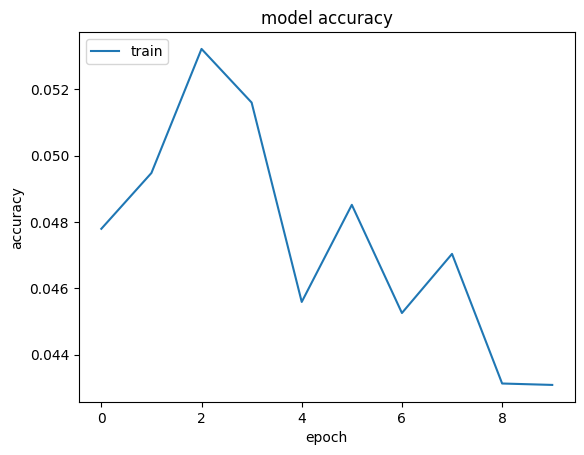

### new sentence: 52 (ffr A \\rrhrir A iitu $$$ $$$$Cnred} $A  ih ahueeee  C_{ggaaa $A$  fs ${hahhccnl Aniiie-FA   [c cho
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9919 - loss: 0.0341
Epoch 1: loss improved from inf to 0.03641, saving model to checkpoints2/weights-improvement-01-0.0364-00053.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9918 - loss: 0.0342
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9892 - loss: 0.0368
Epoch 2: loss did not improve from 0.03641
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9891 - loss: 0.0368
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9876 - loss: 0.0417
Epoch 3: loss did not improve from 0.03641
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9876 - loss: 0.0417
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9883 - loss: 0.0417
Epoch 4: loss did not improve from 0.03641
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.9883 

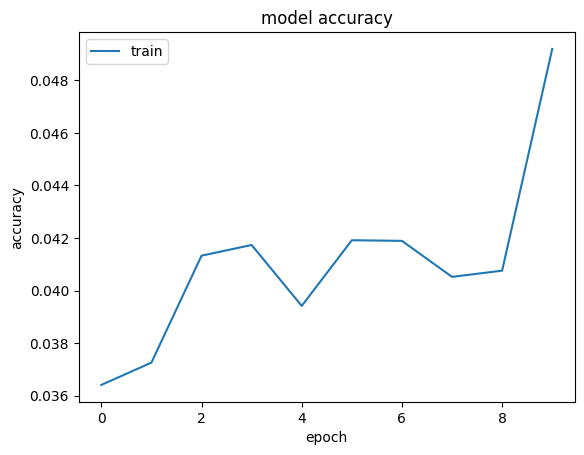

### new sentence: 53 ((    nnnne $  (({{ccgati  nrrnrrazizizi i  andthaa{a}{ S)))oo thv treteetaeell $$$^*=ooohecreoy we 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9869 - loss: 0.0451
Epoch 1: loss improved from inf to 0.04573, saving model to checkpoints2/weights-improvement-01-0.0457-00054.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.9869 - loss: 0.0451
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9869 - loss: 0.0427
Epoch 2: loss improved from 0.04573 to 0.04405, saving model to checkpoints2/weights-improvement-02-0.0441-00054.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9869 - loss: 0.0428
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9869 - loss: 0.0405
Epoch 3: loss improved from 0.04405 to 0.03864, saving model to checkpoints2/weights-improvement-03-0.0386-00054.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9870 - loss: 0.0404
Epoch 4/10
15/15 ━━━━━━━━━━

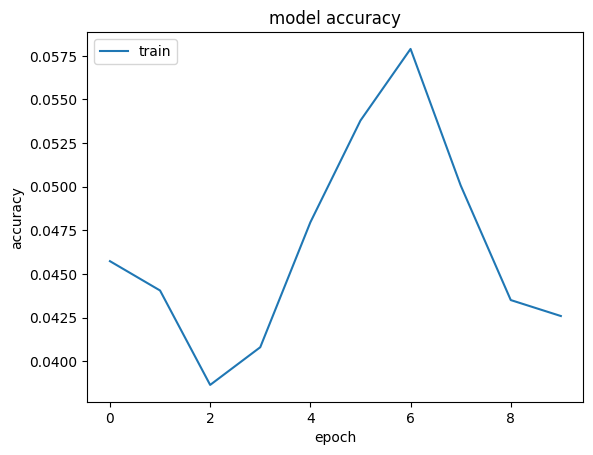

### new sentence: 54 (ff   fnnnnnni in tht somssssisssssssss.wh the eeeeyaaaaaa  aeame:algeeet.tf a cotphciioi iitag  Red
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9877 - loss: 0.0403
Epoch 1: loss improved from inf to 0.04082, saving model to checkpoints2/weights-improvement-01-0.0408-00055.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9877 - loss: 0.0403
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9865 - loss: 0.0463
Epoch 2: loss did not improve from 0.04082
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9865 - loss: 0.0463
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9863 - loss: 0.0442
Epoch 3: loss did not improve from 0.04082
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9863 - loss: 0.0442
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9842 - loss: 0.0504
Epoch 4: loss did not improve from 0.04082
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9843 

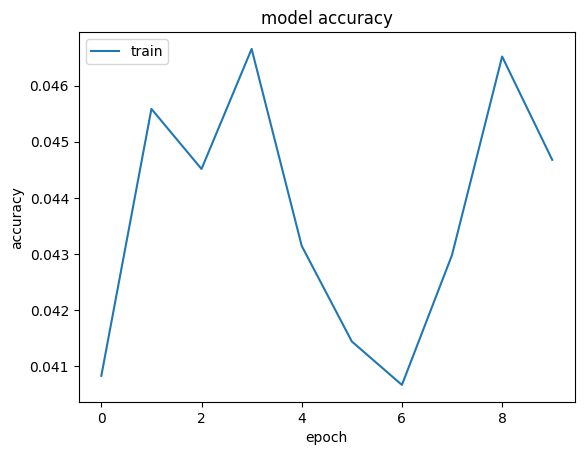

### new sentence: 55 (ff = non sh f $nnnniaa   ii aoo $(( ss she (dooobbr $A    Lo L (iipheetaaa biiaaa-sooietss,tftte ts
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9885 - loss: 0.0401
Epoch 1: loss improved from inf to 0.04306, saving model to checkpoints2/weights-improvement-01-0.0431-00056.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9884 - loss: 0.0403
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9854 - loss: 0.0488
Epoch 2: loss did not improve from 0.04306
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.9854 - loss: 0.0486
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9861 - loss: 0.0446
Epoch 3: loss did not improve from 0.04306
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9861 - loss: 0.0446
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9848 - loss: 0.0476
Epoch 4: loss did not improve from 0.04306
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9848 

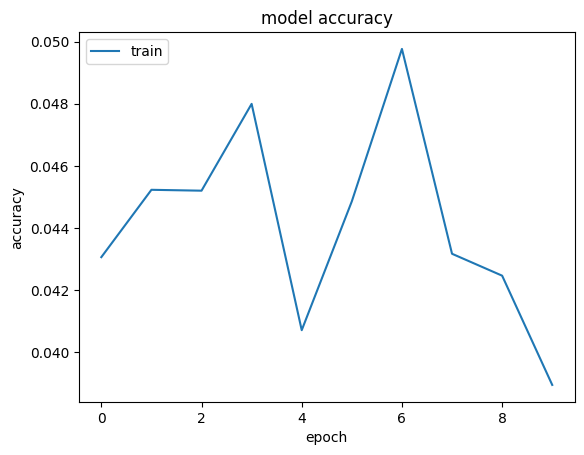

### new sentence: 56 (ffr A   We anstlttl al tuete doooossenn $A$ iftph whatl ffotttttt wf thi crrlipiiii of a noonn d mo
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9886 - loss: 0.0411
Epoch 1: loss improved from inf to 0.04092, saving model to checkpoints2/weights-improvement-01-0.0409-00057.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9886 - loss: 0.0411
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9882 - loss: 0.0397
Epoch 2: loss did not improve from 0.04092
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9881 - loss: 0.0398
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9886 - loss: 0.0405
Epoch 3: loss did not improve from 0.04092
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9886 - loss: 0.0405
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9866 - loss: 0.0449
Epoch 4: loss did not improve from 0.04092
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9867 

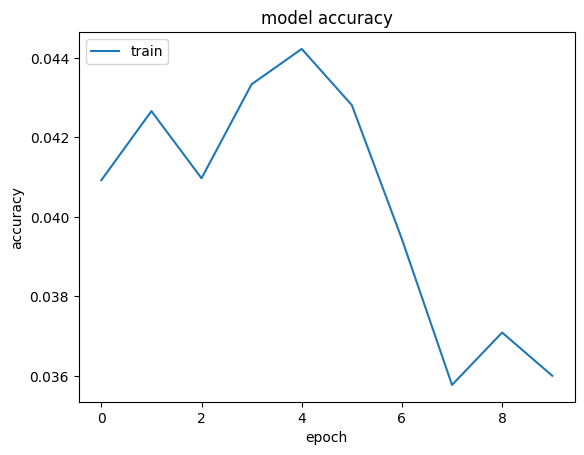

### new sentence: 57 (( ii nnn soeee $\\npmmlakk  a$ ind tha pue sommaaa ann aant $W$ se nhosicttsssnll  f$trisararllllli
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9900 - loss: 0.0356
Epoch 1: loss improved from inf to 0.03660, saving model to checkpoints2/weights-improvement-01-0.0366-00058.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9900 - loss: 0.0357
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9898 - loss: 0.0356
Epoch 2: loss did not improve from 0.03660
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9898 - loss: 0.0357
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9863 - loss: 0.0467
Epoch 3: loss did not improve from 0.03660
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9862 - loss: 0.0466
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9879 - loss: 0.0417
Epoch 4: loss did not improve from 0.03660
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9879 

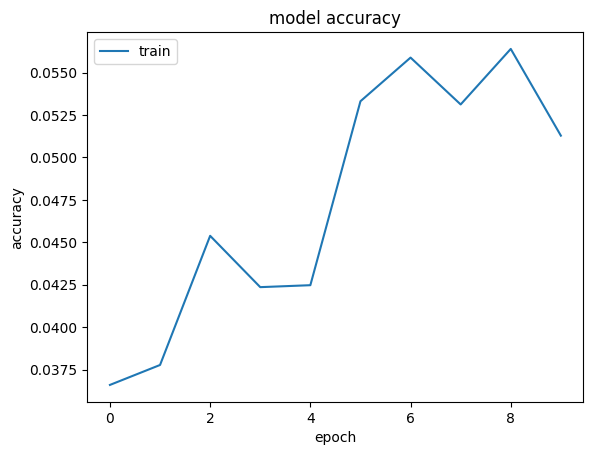

### new sentence: 58 (:  in nhndddtyyys,sfrgrrrrrrrr,oforhri of the panh ff $ $w\nnaav  T$\*=)aad \_tt 1i$8ii thnn fn dhg
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9856 - loss: 0.0513
Epoch 1: loss improved from inf to 0.05340, saving model to checkpoints2/weights-improvement-01-0.0534-00059.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9855 - loss: 0.0514
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9835 - loss: 0.0540
Epoch 2: loss did not improve from 0.05340
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9835 - loss: 0.0542
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9844 - loss: 0.0481
Epoch 3: loss improved from 0.05340 to 0.05006, saving model to checkpoints2/weights-improvement-03-0.0501-00059.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9844 - loss: 0.0482
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9870 - loss: 0.0455
Epoch 4: loss improved

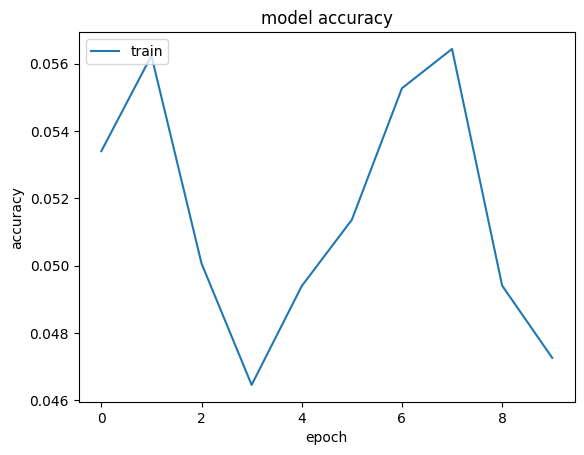

### new sentence: 59 (\f| A  oo nnvolttlsssssss,cf a gii $F$ is o potpw pf whs soitiii fftuccr ooootoossss of a clnnlcrrr
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9845 - loss: 0.0476
Epoch 1: loss improved from inf to 0.04606, saving model to checkpoints2/weights-improvement-01-0.0461-00060.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9846 - loss: 0.0476
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9859 - loss: 0.0463
Epoch 2: loss did not improve from 0.04606
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9859 - loss: 0.0465
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9845 - loss: 0.0503
Epoch 3: loss did not improve from 0.04606
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9845 - loss: 0.0505
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9849 - loss: 0.0486
Epoch 4: loss did not improve from 0.04606
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9849 

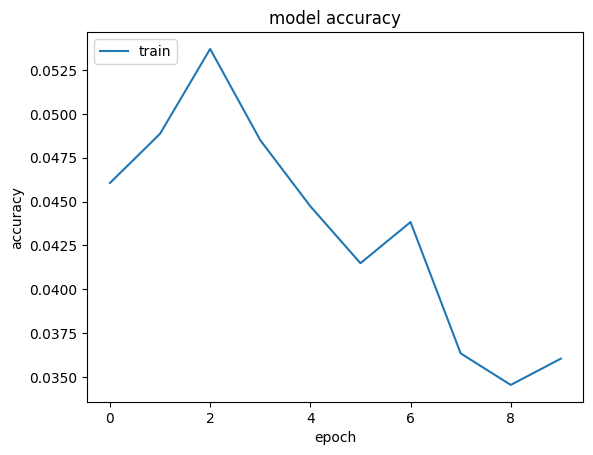

### new sentence: 60 \)|hrhrrrrrsnnnn} A   as  \$\\iiea|llrq  W$$ih hhsssssttssssssssssooeeeeeeea}o}i}i}g}g}e} |   Tsccci
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9900 - loss: 0.0336
Epoch 1: loss improved from inf to 0.03516, saving model to checkpoints2/weights-improvement-01-0.0352-00061.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9900 - loss: 0.0337
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9921 - loss: 0.0291
Epoch 2: loss improved from 0.03516 to 0.03051, saving model to checkpoints2/weights-improvement-02-0.0305-00061.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.9921 - loss: 0.0292
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9920 - loss: 0.0284
Epoch 3: loss improved from 0.03051 to 0.02924, saving model to checkpoints2/weights-improvement-03-0.0292-00061.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.9920 - loss: 0.0284
Epoch 4/10
15/15 ━━━━━━━━━━

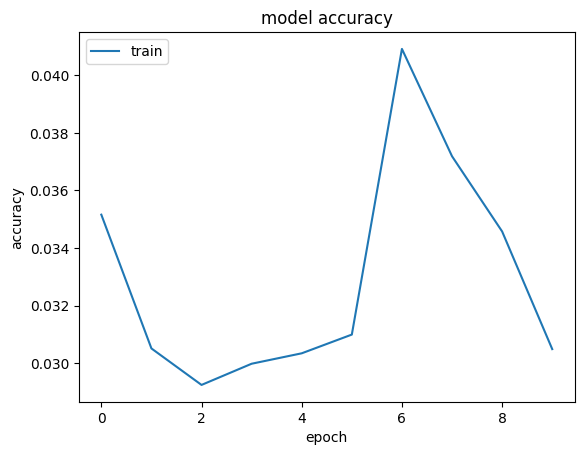

### new sentence: 61 (( Inn shfmedt $\nnppaa{{0A$  in the drlllnynnn al a anndrrrrrrt $$$$.$$$\neiieg A^{ ct ssosssststt 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9913 - loss: 0.0338
Epoch 1: loss improved from inf to 0.03512, saving model to checkpoints2/weights-improvement-01-0.0351-00062.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.9912 - loss: 0.0339
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9894 - loss: 0.0357
Epoch 2: loss did not improve from 0.03512
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9894 - loss: 0.0356
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9897 - loss: 0.0365
Epoch 3: loss did not improve from 0.03512
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9896 - loss: 0.0365
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9902 - loss: 0.0323
Epoch 4: loss improved from 0.03512 to 0.03215, saving model to checkpoints2/weights-improvement-04-0.0

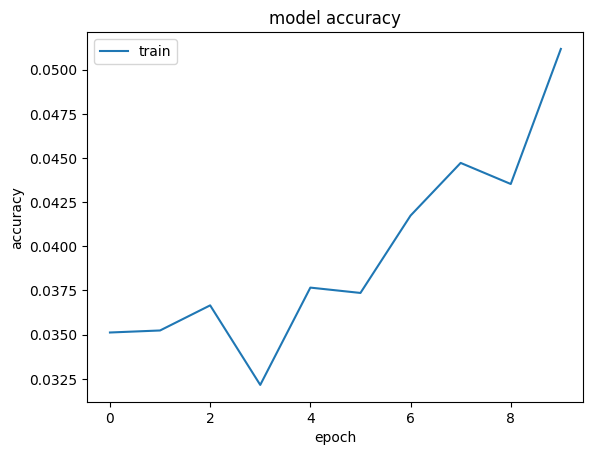

### new sentence: 62 (( ..nnnnn $  ,{{arac)$cnoccrauh wn a semkhhmhllllyy ffvvyend.ildaaai.  aererelilo}}nnn2 Hnddh $\$$i
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9834 - loss: 0.0535
Epoch 1: loss improved from inf to 0.05399, saving model to checkpoints2/weights-improvement-01-0.0540-00063.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9833 - loss: 0.0535
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9859 - loss: 0.0477
Epoch 2: loss improved from 0.05399 to 0.05204, saving model to checkpoints2/weights-improvement-02-0.0520-00063.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9858 - loss: 0.0480
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9843 - loss: 0.0510
Epoch 3: loss did not improve from 0.05204
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9842 - loss: 0.0512
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9853 - loss: 0.0491
Epoch 4: loss improved

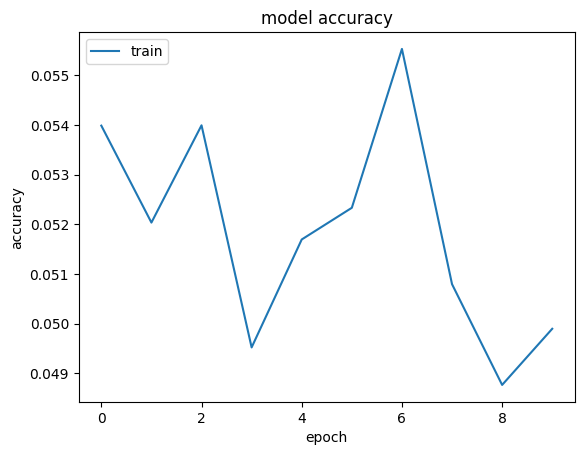

### new sentence: 63 ((  fnnnn $   aaaabaal  iiirrriaa anaaaaaooo  H$$opcclle aoonnnannnnn cn e qaaae $W$-oo aoeeeririvnl
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9857 - loss: 0.0460
Epoch 1: loss improved from inf to 0.04703, saving model to checkpoints2/weights-improvement-01-0.0470-00064.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9856 - loss: 0.0461
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9886 - loss: 0.0377
Epoch 2: loss improved from 0.04703 to 0.03848, saving model to checkpoints2/weights-improvement-02-0.0385-00064.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9886 - loss: 0.0378
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9883 - loss: 0.0394
Epoch 3: loss did not improve from 0.03848
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9883 - loss: 0.0394
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9892 - loss: 0.0373
Epoch 4: loss did not 

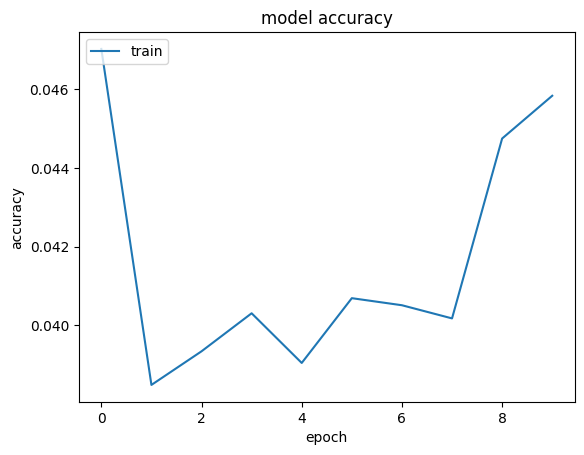

### new sentence: 64 (ffr A  xh nnfssts $T\ \lt $A$  mrdrt $A$-irrrbbb cceetaaaaa  T$ ihehh thet phe tet $$$,iinlllllll l
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9874 - loss: 0.0411
Epoch 1: loss improved from inf to 0.04246, saving model to checkpoints2/weights-improvement-01-0.0425-00065.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9874 - loss: 0.0412
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9876 - loss: 0.0375
Epoch 2: loss improved from 0.04246 to 0.03812, saving model to checkpoints2/weights-improvement-02-0.0381-00065.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9876 - loss: 0.0375
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9898 - loss: 0.0349
Epoch 3: loss improved from 0.03812 to 0.03359, saving model to checkpoints2/weights-improvement-03-0.0336-00065.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9898 - loss: 0.0348
Epoch 4/10
15/15 ━━━━━━━━━━

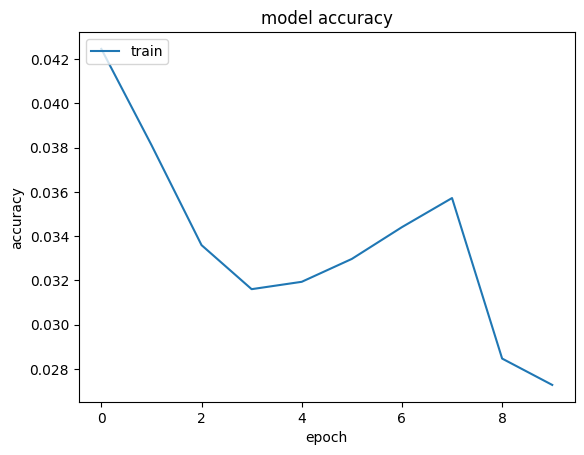

### new sentence: 65 ((  .nn nhesett (\\ \mmmscccrr An((ifd fhf $|lig bD   ah 00\\pph $A$ a{ p.cinen $$$a{ebrarrz} cn $\$
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9919 - loss: 0.0283
Epoch 1: loss improved from inf to 0.02739, saving model to checkpoints2/weights-improvement-01-0.0274-00066.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9919 - loss: 0.0283
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9907 - loss: 0.0293
Epoch 2: loss did not improve from 0.02739
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9907 - loss: 0.0294
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9900 - loss: 0.0304
Epoch 3: loss did not improve from 0.02739
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9901 - loss: 0.0304
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9873 - loss: 0.0385
Epoch 4: loss did not improve from 0.02739
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9874 

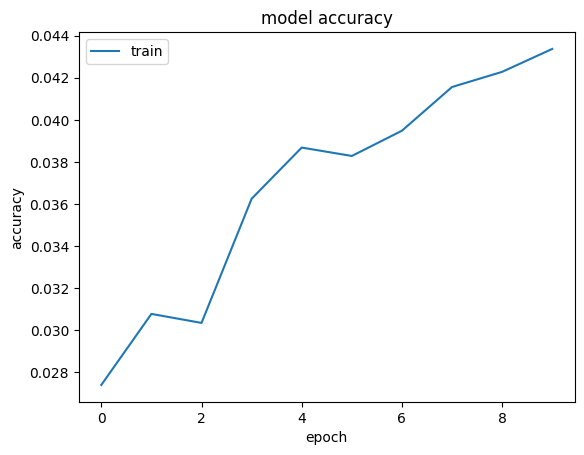

### new sentence: 66 (( \fnnnnnn a aaat gug g gegee $A$$  oeepata an Jlnnnddlyyyyeii ffmeeedeeee.Dffic aea aortherieo oo 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9861 - loss: 0.0419
Epoch 1: loss improved from inf to 0.04275, saving model to checkpoints2/weights-improvement-01-0.0427-00067.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9861 - loss: 0.0420
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9880 - loss: 0.0395
Epoch 2: loss improved from 0.04275 to 0.04082, saving model to checkpoints2/weights-improvement-02-0.0408-00067.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9879 - loss: 0.0396
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9896 - loss: 0.0372
Epoch 3: loss improved from 0.04082 to 0.03740, saving model to checkpoints2/weights-improvement-03-0.0374-00067.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9896 - loss: 0.0372
Epoch 4/10
15/15 ━━━━━━━━━━

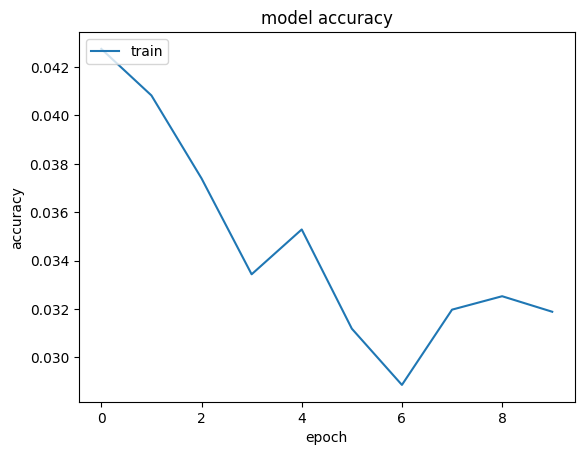

### new sentence: 67 ((   fenn $   ascccit $A$\irrrrr[[ii,,,$(aee hhape aroann,on a $A$   Aemm     F__mmmi.$iiisyy $A$ ah
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9903 - loss: 0.0318
Epoch 1: loss improved from inf to 0.03180, saving model to checkpoints2/weights-improvement-01-0.0318-00068.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9903 - loss: 0.0318
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9893 - loss: 0.0328
Epoch 2: loss did not improve from 0.03180
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9893 - loss: 0.0327
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9896 - loss: 0.0349
Epoch 3: loss did not improve from 0.03180
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9896 - loss: 0.0349
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9902 - loss: 0.0343
Epoch 4: loss did not improve from 0.03180
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9901 

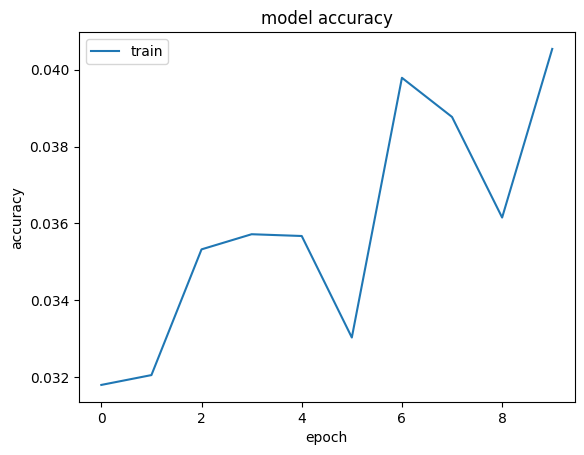

### new sentence: 68 (\f=   \n nssssssl sl the siiiriiieeeeyyysss.cfo a peeeeraaaa  WeeeeeedyyR}R}RblR},,  aeiiiff }eeh $
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9891 - loss: 0.0364
Epoch 1: loss improved from inf to 0.04094, saving model to checkpoints2/weights-improvement-01-0.0409-00069.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9890 - loss: 0.0367
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9876 - loss: 0.0457
Epoch 2: loss did not improve from 0.04094
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9876 - loss: 0.0456
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9867 - loss: 0.0443
Epoch 3: loss did not improve from 0.04094
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9867 - loss: 0.0445
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9881 - loss: 0.0398
Epoch 4: loss did not improve from 0.04094
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9880 

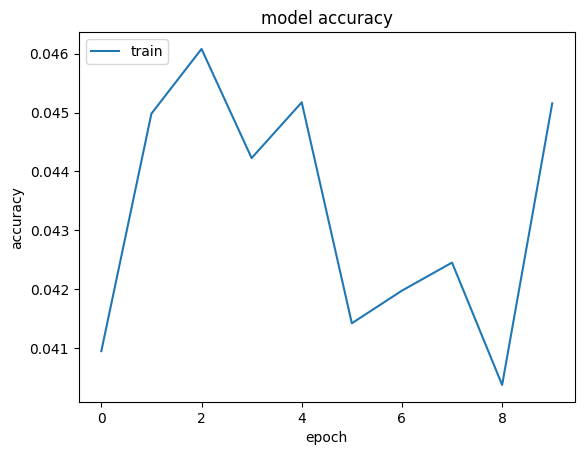

### new sentence: 69 ((ffrnnns A \eirhrai $   ae soossdthz oherer $Xn gnnderupteaa aoeaardddllyyyiiigeeeeeee{{}}}}}}},B,$
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9863 - loss: 0.0418
Epoch 1: loss improved from inf to 0.04290, saving model to checkpoints2/weights-improvement-01-0.0429-00070.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9863 - loss: 0.0419
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9865 - loss: 0.0442
Epoch 2: loss did not improve from 0.04290
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.9866 - loss: 0.0443
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9872 - loss: 0.0428
Epoch 3: loss did not improve from 0.04290
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9872 - loss: 0.0428
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9886 - loss: 0.0411
Epoch 4: loss did not improve from 0.04290
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9885 

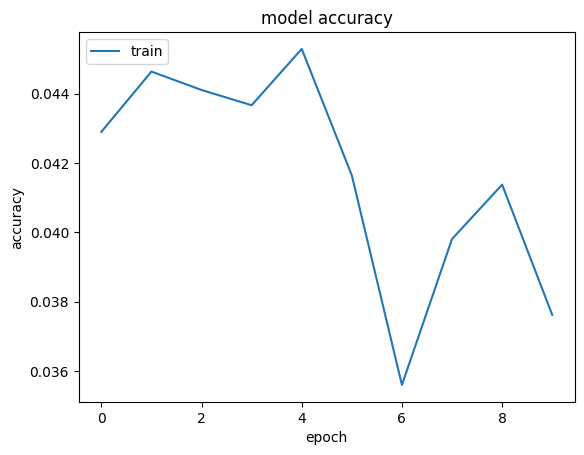

### new sentence: 70 (ff = fonnnniii cl tht qopuoiiii ooodrssss ofo a cuuueatele an aa aoeeecccctsssss,sfsueet a teeerati
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9878 - loss: 0.0386
Epoch 1: loss improved from inf to 0.03815, saving model to checkpoints2/weights-improvement-01-0.0382-00071.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9878 - loss: 0.0386
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9899 - loss: 0.0357
Epoch 2: loss did not improve from 0.03815
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.9898 - loss: 0.0360
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9895 - loss: 0.0330
Epoch 3: loss improved from 0.03815 to 0.03627, saving model to checkpoints2/weights-improvement-03-0.0363-00071.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9895 - loss: 0.0332
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9891 - loss: 0.0349
Epoch 4: loss improved

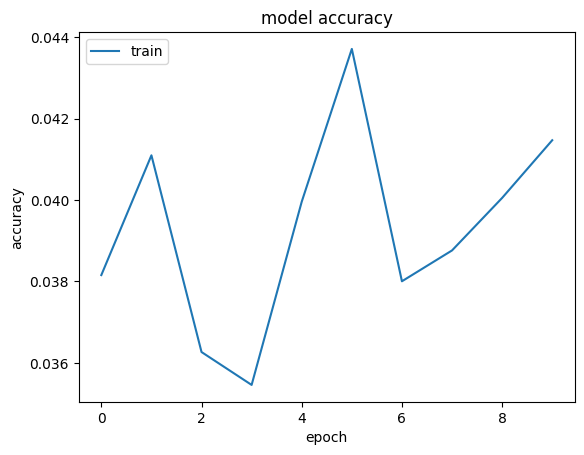

### new sentence: 71 ((   nnnn $   aaaabaa $ni anne $C$ is b benpbrrrillll   \{rpeethms},}$,$$\i aossepthvs,rn $A$ in n p
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9863 - loss: 0.0447
Epoch 1: loss improved from inf to 0.04615, saving model to checkpoints2/weights-improvement-01-0.0461-00072.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9862 - loss: 0.0448
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9857 - loss: 0.0439
Epoch 2: loss improved from 0.04615 to 0.04493, saving model to checkpoints2/weights-improvement-02-0.0449-00072.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9857 - loss: 0.0440
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9856 - loss: 0.0418
Epoch 3: loss improved from 0.04493 to 0.03909, saving model to checkpoints2/weights-improvement-03-0.0391-00072.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9857 - loss: 0.0416
Epoch 4/10
15/15 ━━━━━━━━━━

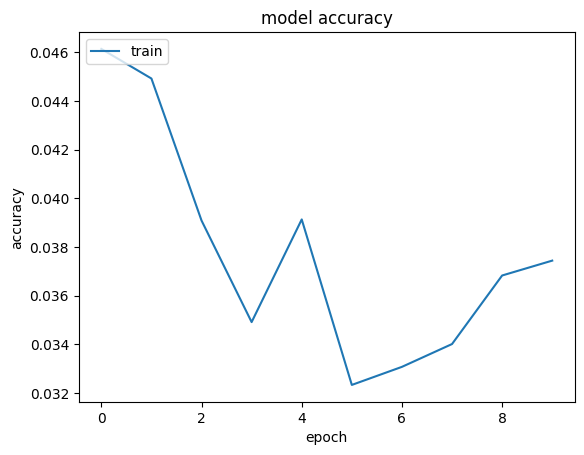

### new sentence: 72 (( If nnnn c fenmmtgrill aaniiryyye rhohhrui,of a weroaaricoll onniy a aarrrreedg  A$R.. $AA A  ii a
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9890 - loss: 0.0352
Epoch 1: loss improved from inf to 0.03565, saving model to checkpoints2/weights-improvement-01-0.0357-00073.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9890 - loss: 0.0352
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9884 - loss: 0.0388
Epoch 2: loss did not improve from 0.03565
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.9883 - loss: 0.0390
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9881 - loss: 0.0377
Epoch 3: loss did not improve from 0.03565
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9881 - loss: 0.0379
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9892 - loss: 0.0342
Epoch 4: loss did not improve from 0.03565
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9892 

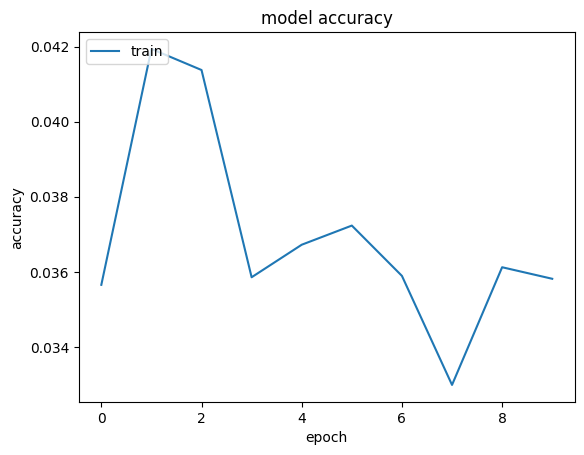

### new sentence: 73 (ffr A  fo nnfllt $T$\-=) ddddteriii aieteeebi.boddet.ww $\$.ih c fenoo fomeoiinnn flpwwataa.afapiii
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9914 - loss: 0.0301
Epoch 1: loss improved from inf to 0.03338, saving model to checkpoints2/weights-improvement-01-0.0334-00074.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9913 - loss: 0.0303
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9882 - loss: 0.0359
Epoch 2: loss did not improve from 0.03338
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9882 - loss: 0.0357
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9907 - loss: 0.0331
Epoch 3: loss improved from 0.03338 to 0.03289, saving model to checkpoints2/weights-improvement-03-0.0329-00074.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9907 - loss: 0.0331
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9882 - loss: 0.0398
Epoch 4: loss did not 

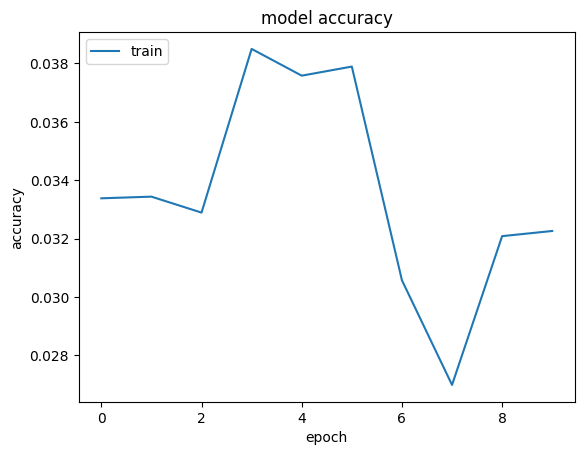

### new sentence: 74 fffrrrnr^}nlyy A   as shiiissss ar aryeddt aonatttt $a$a)$a,  ,,,,_,, ii a wemaaaaaane oimml lonooar
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9900 - loss: 0.0354
Epoch 1: loss improved from inf to 0.03477, saving model to checkpoints2/weights-improvement-01-0.0348-00075.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9900 - loss: 0.0354
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9902 - loss: 0.0328
Epoch 2: loss improved from 0.03477 to 0.03264, saving model to checkpoints2/weights-improvement-02-0.0326-00075.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9902 - loss: 0.0328
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9877 - loss: 0.0397
Epoch 3: loss did not improve from 0.03264
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9878 - loss: 0.0396
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9897 - loss: 0.0342
Epoch 4: loss did not 

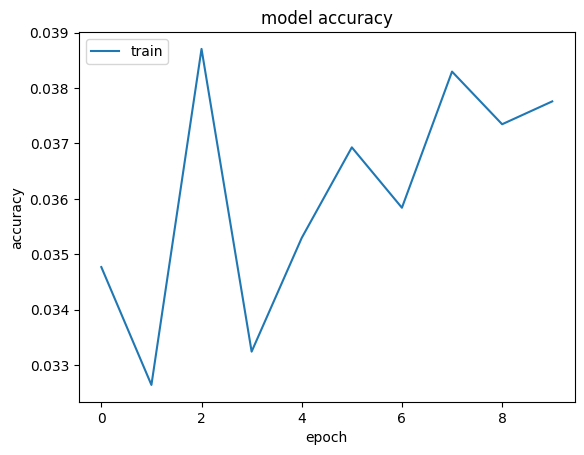

### new sentence: 75 ((|f nnn nffeeeele dltgerriss ooohhcsssssssscccc,cfdohrsssss on a {eehhrallaey f   $ mommhet th th t
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9879 - loss: 0.0401
Epoch 1: loss improved from inf to 0.03864, saving model to checkpoints2/weights-improvement-01-0.0386-00076.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9880 - loss: 0.0400
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9914 - loss: 0.0326
Epoch 2: loss improved from 0.03864 to 0.03735, saving model to checkpoints2/weights-improvement-02-0.0373-00076.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9913 - loss: 0.0329
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9888 - loss: 0.0358
Epoch 3: loss improved from 0.03735 to 0.03693, saving model to checkpoints2/weights-improvement-03-0.0369-00076.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.9888 - loss: 0.0358
Epoch 4/10
15/15 ━━━━━━━━━━

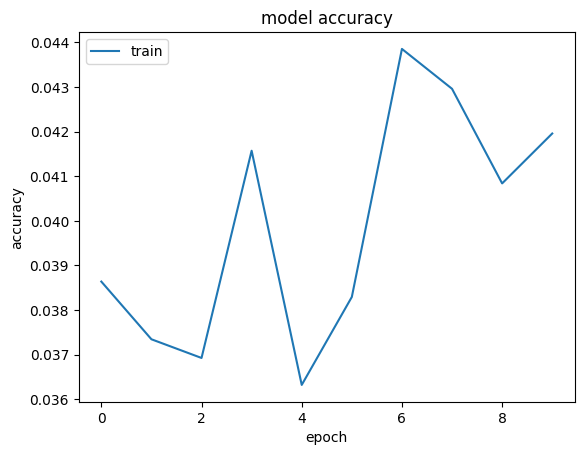

### new sentence: 76 fffrhrrrrn A aherhrer.oh $\$\i\\ddd0d$$    Leeereeihoio,    be ahhssstphh,tr thet tn the $C$.ihduui 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9868 - loss: 0.0423
Epoch 1: loss improved from inf to 0.04498, saving model to checkpoints2/weights-improvement-01-0.0450-00077.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9868 - loss: 0.0425
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9867 - loss: 0.0380
Epoch 2: loss improved from 0.04498 to 0.04137, saving model to checkpoints2/weights-improvement-02-0.0414-00077.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9867 - loss: 0.0382
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9884 - loss: 0.0382
Epoch 3: loss improved from 0.04137 to 0.03933, saving model to checkpoints2/weights-improvement-03-0.0393-00077.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.9883 - loss: 0.0383
Epoch 4/10
15/15 ━━━━━━━━━━

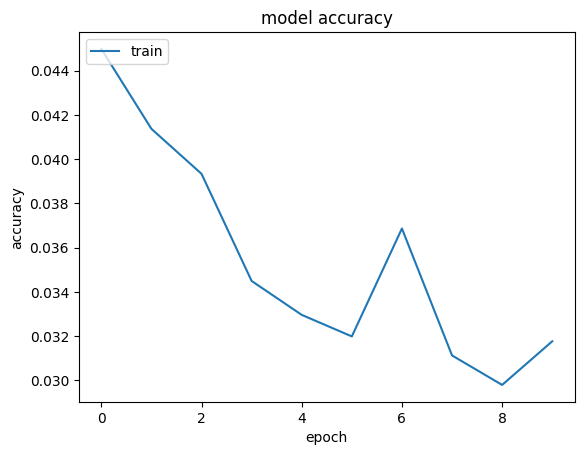

### new sentence: 77 fffrrrroonn A   bs   $$$$C^cccc cnrabiainhhhhhhhffQ{Q}P}hP}}}}}}}}},, --Beeesuouio.tu cf pppdd{edted
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9922 - loss: 0.0280
Epoch 1: loss improved from inf to 0.02882, saving model to checkpoints2/weights-improvement-01-0.0288-00078.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9922 - loss: 0.0281
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9925 - loss: 0.0265
Epoch 2: loss improved from 0.02882 to 0.02862, saving model to checkpoints2/weights-improvement-02-0.0286-00078.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9924 - loss: 0.0266
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9911 - loss: 0.0300
Epoch 3: loss did not improve from 0.02862
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9911 - loss: 0.0299
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9915 - loss: 0.0286
Epoch 4: loss did not 

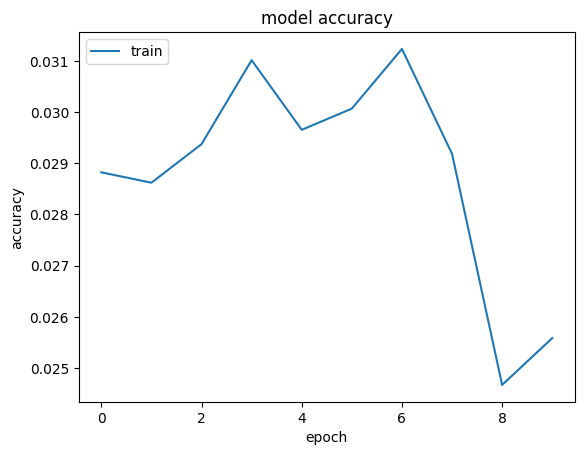

### new sentence: 78 fffrhrmrhnn A   bee $\meaee\\\\\(A(   Ls shicctthsssssssssfffeeeeeeeeee}i}i}i}}}}}}}}}}}dd B)d)B  Tc
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9911 - loss: 0.0287
Epoch 1: loss improved from inf to 0.02899, saving model to checkpoints2/weights-improvement-01-0.0290-00079.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9911 - loss: 0.0287
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9912 - loss: 0.0320
Epoch 2: loss did not improve from 0.02899
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9911 - loss: 0.0321
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9866 - loss: 0.0403
Epoch 3: loss did not improve from 0.02899
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9867 - loss: 0.0402
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9909 - loss: 0.0295
Epoch 4: loss did not improve from 0.02899
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9908 

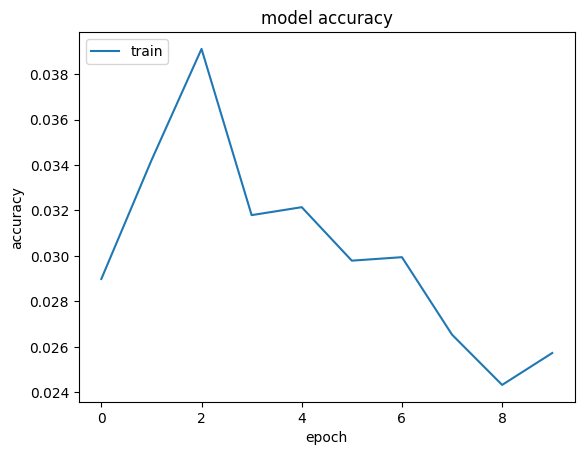

### new sentence: 79 fffrhrroon A aeerh reaa $\$ isnn $$$ in aadddd{ of ioom that $$$,,io c ciacbbaalllnn  nn prp pummlga
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9910 - loss: 0.0298
Epoch 1: loss improved from inf to 0.03017, saving model to checkpoints2/weights-improvement-01-0.0302-00080.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9910 - loss: 0.0298
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9905 - loss: 0.0296
Epoch 2: loss improved from 0.03017 to 0.02961, saving model to checkpoints2/weights-improvement-02-0.0296-00080.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9905 - loss: 0.0296
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9884 - loss: 0.0358
Epoch 3: loss did not improve from 0.02961
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9884 - loss: 0.0358
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9894 - loss: 0.0344
Epoch 4: loss did not 

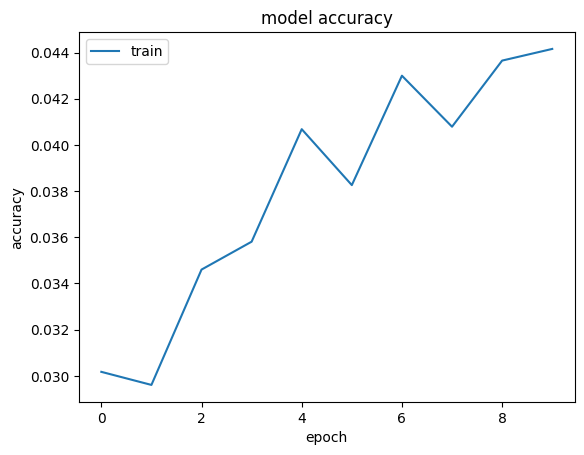

### new sentence: 80 fffrrrrronnn} A     ss a feueuuuueaaddd,$$$== hhhheetesye,isectsye.inobns ms the O muppecn fn e,ciia
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9853 - loss: 0.0456
Epoch 1: loss improved from inf to 0.04398, saving model to checkpoints2/weights-improvement-01-0.0440-00081.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9854 - loss: 0.0455
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9862 - loss: 0.0432
Epoch 2: loss did not improve from 0.04398
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9862 - loss: 0.0433
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9856 - loss: 0.0480
Epoch 3: loss did not improve from 0.04398
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9857 - loss: 0.0478
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9851 - loss: 0.0462
Epoch 4: loss did not improve from 0.04398
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9851 

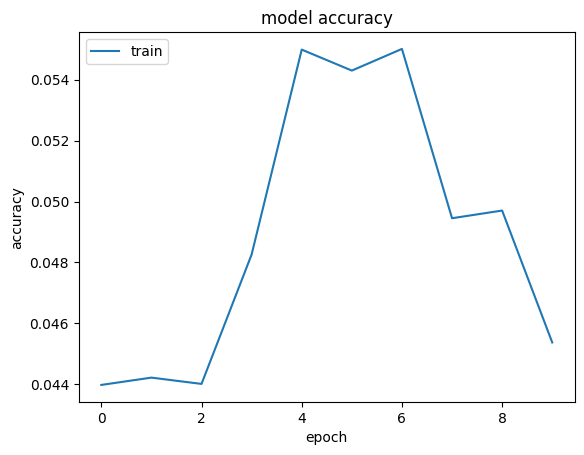

### new sentence: 81 (( ihnnnnnn a aarasssulli  W$  We a pimel aaahssvicni $\ea alg $$$  ss a $ooonnrrrlllll   \\**\maaaa
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9866 - loss: 0.0465
Epoch 1: loss improved from inf to 0.04653, saving model to checkpoints2/weights-improvement-01-0.0465-00082.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9866 - loss: 0.0465
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9868 - loss: 0.0452
Epoch 2: loss improved from 0.04653 to 0.04321, saving model to checkpoints2/weights-improvement-02-0.0432-00082.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9869 - loss: 0.0451
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9860 - loss: 0.0461
Epoch 3: loss did not improve from 0.04321
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9860 - loss: 0.0460
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9855 - loss: 0.0430
Epoch 4: loss did not 

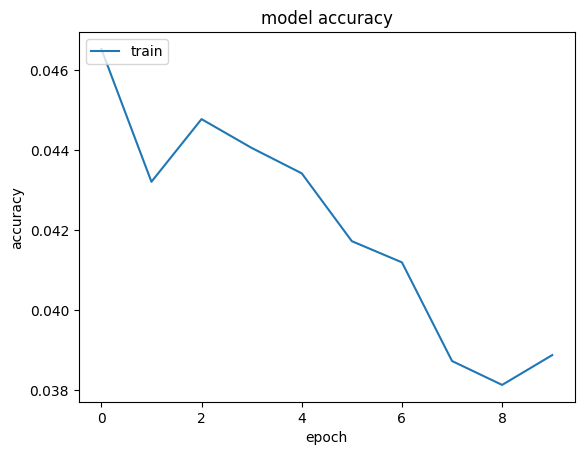

### new sentence: 82 (( \fn nnfm $A$ annnn $A_{i((((((I{{rttpp    bbbbbgggeee   \\lhaaa{^}e }$,inaas insslliii on $a$ iee
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9880 - loss: 0.0354
Epoch 1: loss improved from inf to 0.03704, saving model to checkpoints2/weights-improvement-01-0.0370-00083.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9880 - loss: 0.0355
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9900 - loss: 0.0305
Epoch 2: loss improved from 0.03704 to 0.03290, saving model to checkpoints2/weights-improvement-02-0.0329-00083.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.9899 - loss: 0.0307
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9909 - loss: 0.0329
Epoch 3: loss did not improve from 0.03290
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9908 - loss: 0.0332
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9883 - loss: 0.0381
Epoch 4: loss did not 

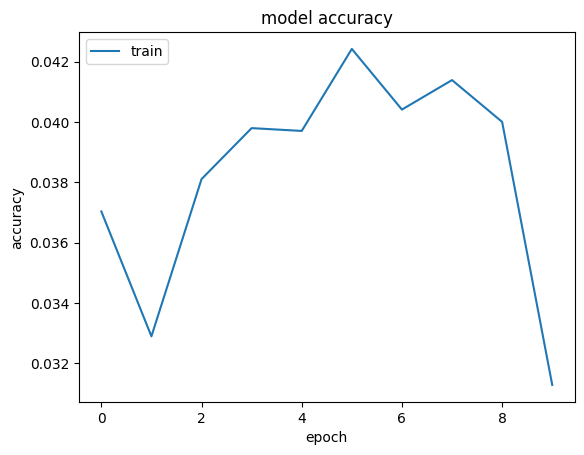

### new sentence: 83 (ffr =   Ws nnnt $\$\)=)=\rrrr}A\\=      LLpppppp} wh   \\ phi $\\alaaaalllll,,,ihlghhhhh  a$  ihihh
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9892 - loss: 0.0349
Epoch 1: loss improved from inf to 0.03598, saving model to checkpoints2/weights-improvement-01-0.0360-00084.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9892 - loss: 0.0350
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9901 - loss: 0.0324
Epoch 2: loss improved from 0.03598 to 0.03289, saving model to checkpoints2/weights-improvement-02-0.0329-00084.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9901 - loss: 0.0324
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9908 - loss: 0.0316
Epoch 3: loss improved from 0.03289 to 0.03180, saving model to checkpoints2/weights-improvement-03-0.0318-00084.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9908 - loss: 0.0316
Epoch 4/10
15/15 ━━━━━━━━━━

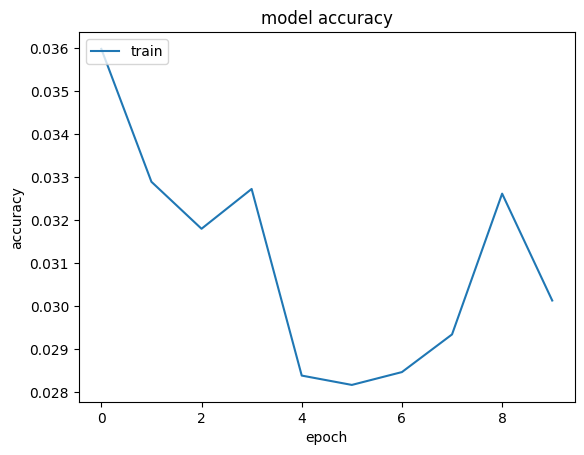

### new sentence: 84 (ff    nnnnssi   ihiilii  A$ is $G$ iidddt $^n neeee a aog $) ssohh is aheg oooorrooooss of a  aeaaa
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9909 - loss: 0.0283
Epoch 1: loss improved from inf to 0.02983, saving model to checkpoints2/weights-improvement-01-0.0298-00085.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9909 - loss: 0.0284
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9907 - loss: 0.0293
Epoch 2: loss improved from 0.02983 to 0.02907, saving model to checkpoints2/weights-improvement-02-0.0291-00085.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9907 - loss: 0.0292
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9907 - loss: 0.0284
Epoch 3: loss improved from 0.02907 to 0.02709, saving model to checkpoints2/weights-improvement-03-0.0271-00085.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9907 - loss: 0.0283
Epoch 4/10
15/15 ━━━━━━━━━━

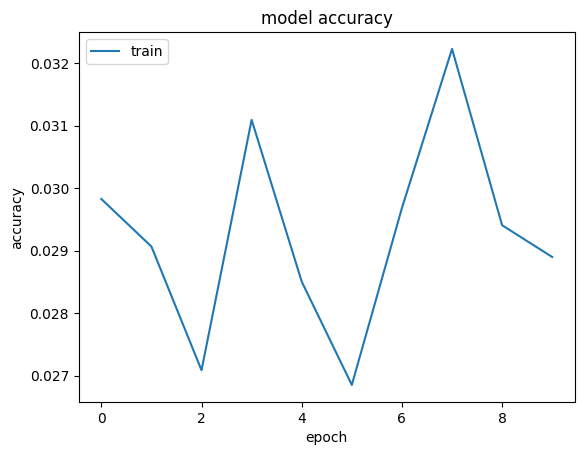

### new sentence: 85 (ff    nnn she  \\ig,, $Is =|($i$ ii pheee,$($ ......c{ccccg  {{ thepeppisn th aoooonol ooogrriissss
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9908 - loss: 0.0290
Epoch 1: loss improved from inf to 0.03016, saving model to checkpoints2/weights-improvement-01-0.0302-00086.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9908 - loss: 0.0290
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9927 - loss: 0.0258
Epoch 2: loss improved from 0.03016 to 0.02793, saving model to checkpoints2/weights-improvement-02-0.0279-00086.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9926 - loss: 0.0259
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9926 - loss: 0.0228
Epoch 3: loss improved from 0.02793 to 0.02507, saving model to checkpoints2/weights-improvement-03-0.0251-00086.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9925 - loss: 0.0229
Epoch 4/10
15/15 ━━━━━━━━━━

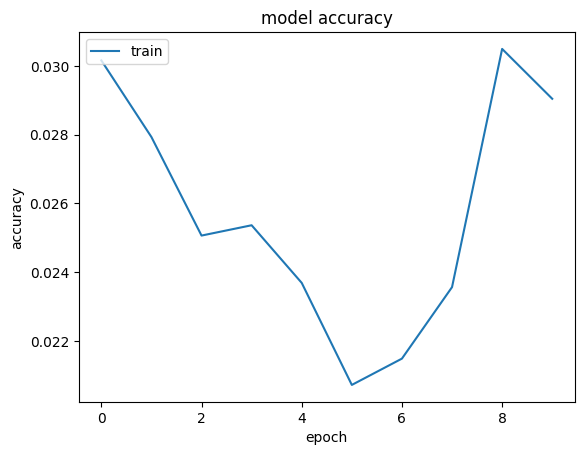

### new sentence: 86 ((  fnnnn $A$ aiii ii aneeddddeze  $$ iseccaaalgggg bnsphtuddd M$$afcccsivg oh thrwemtata andt $A_om
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9926 - loss: 0.0267
Epoch 1: loss improved from inf to 0.02786, saving model to checkpoints2/weights-improvement-01-0.0279-00087.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9925 - loss: 0.0268
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9938 - loss: 0.0226
Epoch 2: loss improved from 0.02786 to 0.02390, saving model to checkpoints2/weights-improvement-02-0.0239-00087.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9938 - loss: 0.0227
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9904 - loss: 0.0286
Epoch 3: loss did not improve from 0.02390
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9904 - loss: 0.0287
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9921 - loss: 0.0267
Epoch 4: loss did not 

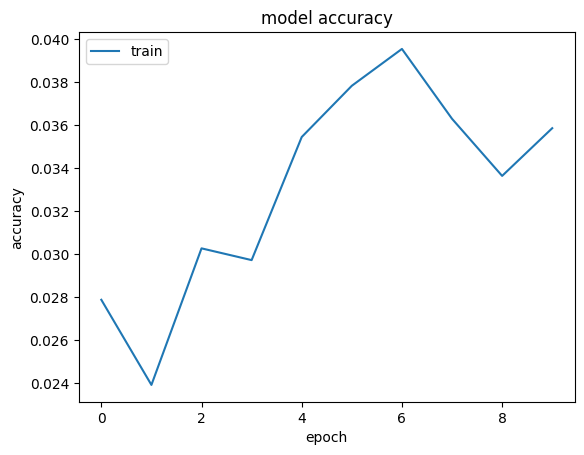

### new sentence: 87 (ffr D ) Wh nnttet $K$ io c B0i---a)g), ar aseeeadisie  th arssnnnnrr aysiarayiz. \$  hheheet weetea
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9876 - loss: 0.0374
Epoch 1: loss improved from inf to 0.03990, saving model to checkpoints2/weights-improvement-01-0.0399-00088.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9876 - loss: 0.0375
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9879 - loss: 0.0399
Epoch 2: loss improved from 0.03990 to 0.03820, saving model to checkpoints2/weights-improvement-02-0.0382-00088.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.9880 - loss: 0.0398
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9885 - loss: 0.0355
Epoch 3: loss improved from 0.03820 to 0.03772, saving model to checkpoints2/weights-improvement-03-0.0377-00088.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9885 - loss: 0.0357
Epoch 4/10
15/15 ━━━━━━━━━━

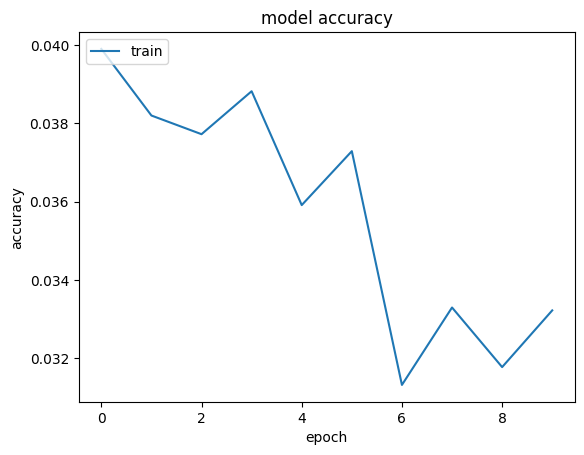

### new sentence: 88 fff ff fneeeniyeyiyiiiii ff a fiieexeyyedeeeeeeee keemeeaoo, a$  Ln a fonuggg gpupeeiiii ffmprritso 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9897 - loss: 0.0322
Epoch 1: loss improved from inf to 0.03370, saving model to checkpoints2/weights-improvement-01-0.0337-00089.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9897 - loss: 0.0323
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9918 - loss: 0.0291
Epoch 2: loss improved from 0.03370 to 0.03031, saving model to checkpoints2/weights-improvement-02-0.0303-00089.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.9917 - loss: 0.0292
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9905 - loss: 0.0299
Epoch 3: loss did not improve from 0.03031
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9905 - loss: 0.0300
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9916 - loss: 0.0271
Epoch 4: loss improved

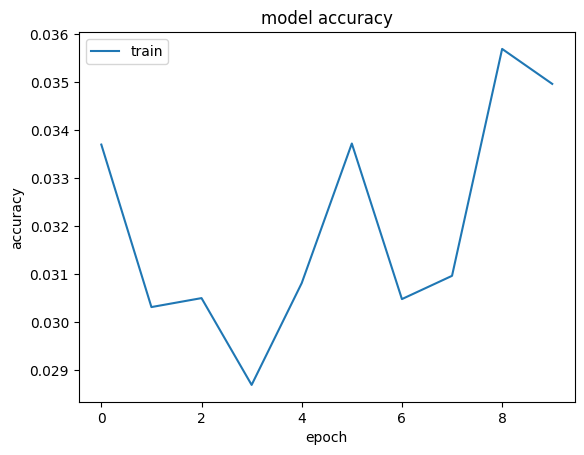

### new sentence: 89 (  Inn ans soy ffnie,ff gf eedrrriieeee $A$\iiitttiriiirric snncuuuut.thtn is gig $forrb  wh rrrttet
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9862 - loss: 0.0410
Epoch 1: loss improved from inf to 0.04294, saving model to checkpoints2/weights-improvement-01-0.0429-00090.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9862 - loss: 0.0411
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9876 - loss: 0.0367
Epoch 2: loss improved from 0.04294 to 0.04221, saving model to checkpoints2/weights-improvement-02-0.0422-00090.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9876 - loss: 0.0370
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9855 - loss: 0.0476
Epoch 3: loss did not improve from 0.04221
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9855 - loss: 0.0476
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9868 - loss: 0.0424
Epoch 4: loss did not 

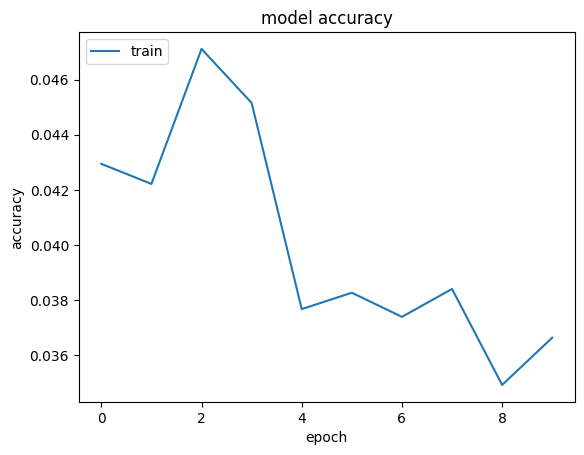

### new sentence: 90 ((\fn nn s romm ff the --$  oeeeeeosss oh the dlootttoters $T$  Tsddtituod{pp0A)$Rt thissstssss,cl $
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9886 - loss: 0.0368
Epoch 1: loss improved from inf to 0.03911, saving model to checkpoints2/weights-improvement-01-0.0391-00091.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9885 - loss: 0.0369
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9908 - loss: 0.0296
Epoch 2: loss improved from 0.03911 to 0.03053, saving model to checkpoints2/weights-improvement-02-0.0305-00091.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.9908 - loss: 0.0297
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9920 - loss: 0.0283
Epoch 3: loss did not improve from 0.03053
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.9919 - loss: 0.0285
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9905 - loss: 0.0308
Epoch 4: loss did not 

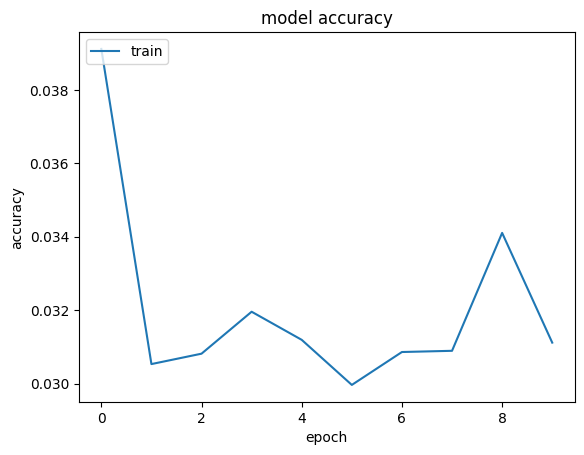

### new sentence: 91 (ff    nn nhvs $ \aa$$|\riiia A   ioi $\zaphcc(\\tia(\$\oott t{ , \o\th fn $B$..hhrn a $ ae a $oonne
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9917 - loss: 0.0269
Epoch 1: loss improved from inf to 0.02871, saving model to checkpoints2/weights-improvement-01-0.0287-00092.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9917 - loss: 0.0271
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9924 - loss: 0.0263
Epoch 2: loss did not improve from 0.02871
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9924 - loss: 0.0265
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9921 - loss: 0.0245
Epoch 3: loss improved from 0.02871 to 0.02733, saving model to checkpoints2/weights-improvement-03-0.0273-00092.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9921 - loss: 0.0247
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9913 - loss: 0.0286
Epoch 4: loss did not 

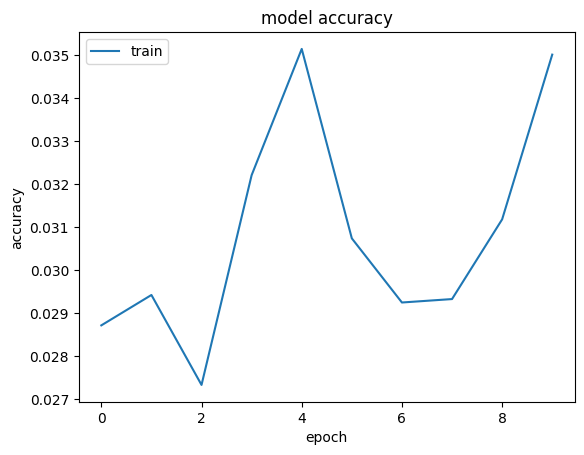

### new sentence: 92 (ff fnnn f fonmmiiiiiigggg ffvarraar A \tt a zerthct peneeaticc $M$ is $A$  se a nonuebbe deseeer,$d
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9883 - loss: 0.0367
Epoch 1: loss improved from inf to 0.03509, saving model to checkpoints2/weights-improvement-01-0.0351-00093.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9884 - loss: 0.0366
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9910 - loss: 0.0296
Epoch 2: loss improved from 0.03509 to 0.03137, saving model to checkpoints2/weights-improvement-02-0.0314-00093.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.9910 - loss: 0.0297
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9912 - loss: 0.0293
Epoch 3: loss improved from 0.03137 to 0.03028, saving model to checkpoints2/weights-improvement-03-0.0303-00093.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9912 - loss: 0.0294
Epoch 4/10
15/15 ━━━━━━━━━━

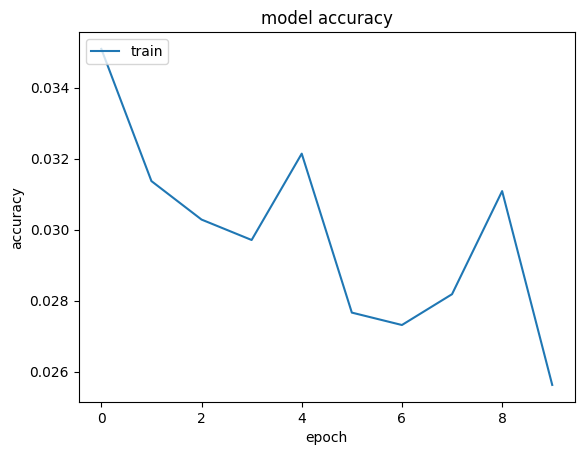

### new sentence: 93 fff D  fGnn A  ioin $B$ ii n cimomeccdyyvn,sf adddddddtt ii theweeee aoougtiiiisssss ohecer guoogtao
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9911 - loss: 0.0263
Epoch 1: loss improved from inf to 0.02697, saving model to checkpoints2/weights-improvement-01-0.0270-00094.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9911 - loss: 0.0264
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9939 - loss: 0.0230
Epoch 2: loss improved from 0.02697 to 0.02613, saving model to checkpoints2/weights-improvement-02-0.0261-00094.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9938 - loss: 0.0232
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9922 - loss: 0.0263
Epoch 3: loss did not improve from 0.02613
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9921 - loss: 0.0265
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9891 - loss: 0.0339
Epoch 4: loss did not 

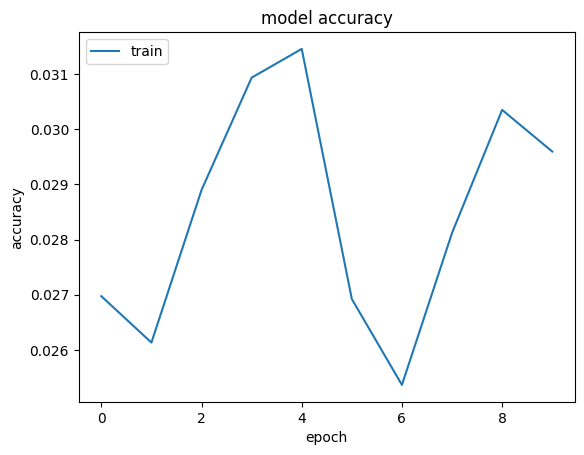

### new sentence: 94 \ff A fmrrhnn A   ihdti iy aneennyyyssssss    ^^{pphhhhhhh} }nauuuuutt}} HnthhctZ}PbP$Ti d siissoiin
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9913 - loss: 0.0287
Epoch 1: loss improved from inf to 0.03059, saving model to checkpoints2/weights-improvement-01-0.0306-00095.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9913 - loss: 0.0288
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9903 - loss: 0.0314
Epoch 2: loss did not improve from 0.03059
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9903 - loss: 0.0315
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9926 - loss: 0.0268
Epoch 3: loss improved from 0.03059 to 0.02718, saving model to checkpoints2/weights-improvement-03-0.0272-00095.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9926 - loss: 0.0268
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9896 - loss: 0.0325
Epoch 4: loss did not 

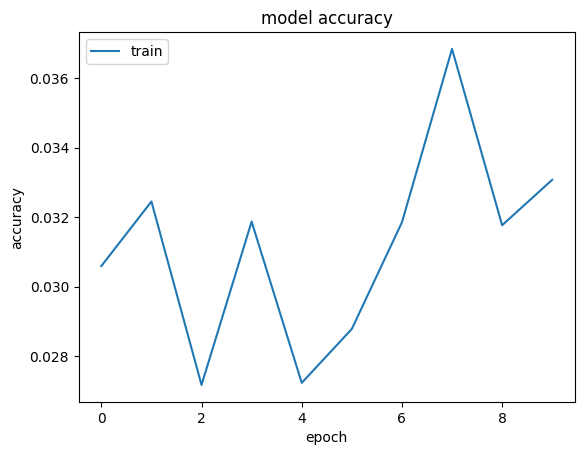

### new sentence: 95 (( Inn ann soey if phe zedneryioi in $A$ in a pigctrravi oiig $$$$meeriesgsgyyyyy iimmgrui.dp   $$ie
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9904 - loss: 0.0336
Epoch 1: loss improved from inf to 0.03566, saving model to checkpoints2/weights-improvement-01-0.0357-00096.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9904 - loss: 0.0337
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9894 - loss: 0.0320
Epoch 2: loss improved from 0.03566 to 0.03264, saving model to checkpoints2/weights-improvement-02-0.0326-00096.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9894 - loss: 0.0320
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9874 - loss: 0.0385
Epoch 3: loss did not improve from 0.03264
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9874 - loss: 0.0386
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9846 - loss: 0.0485
Epoch 4: loss did not 

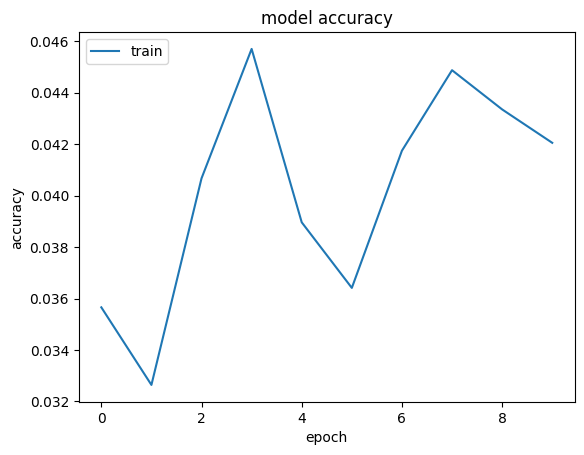

### new sentence: 96 (ff    nn nnsoo i flnitllll iu a faakerrhcl mr $ae   wh aho ooovvvpooinnllleeeeeeeeeaa$$AA((feicggg 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9882 - loss: 0.0391
Epoch 1: loss improved from inf to 0.04252, saving model to checkpoints2/weights-improvement-01-0.0425-00097.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9881 - loss: 0.0393
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9875 - loss: 0.0381
Epoch 2: loss improved from 0.04252 to 0.03509, saving model to checkpoints2/weights-improvement-02-0.0351-00097.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9875 - loss: 0.0380
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9905 - loss: 0.0296
Epoch 3: loss improved from 0.03509 to 0.03129, saving model to checkpoints2/weights-improvement-03-0.0313-00097.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9905 - loss: 0.0297
Epoch 4/10
15/15 ━━━━━━━━━━

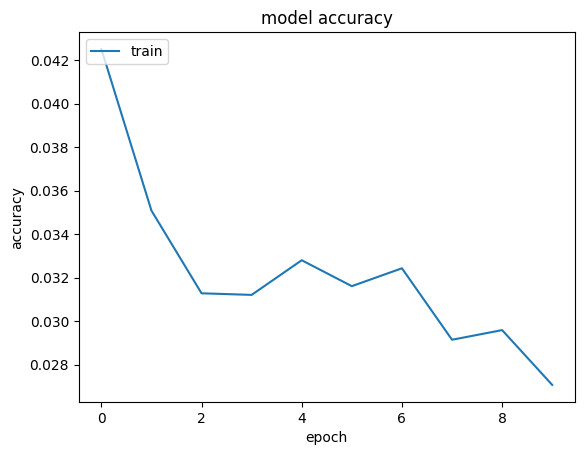

### new sentence: 97 \}frhryoon A     Leeeetaatl ahaata \ne\aacca.waanhcccwwwwo Sntccc({hanh Aniin tha $G$ aodnt th the d
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9924 - loss: 0.0250
Epoch 1: loss improved from inf to 0.02698, saving model to checkpoints2/weights-improvement-01-0.0270-00098.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9923 - loss: 0.0251
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9898 - loss: 0.0292
Epoch 2: loss did not improve from 0.02698
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9898 - loss: 0.0291
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9907 - loss: 0.0289
Epoch 3: loss did not improve from 0.02698
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9908 - loss: 0.0289
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9911 - loss: 0.0289
Epoch 4: loss did not improve from 0.02698
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9910 

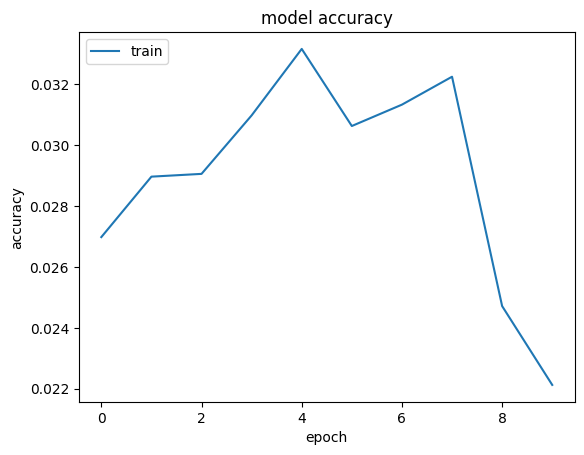

### new sentence: 98 \ffrhrym A $ $eee taapccn crerurann anddnnadn  A$$ih f finpue fffpiiiin sf a frrperuuuet vfaaa $$$a,
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9917 - loss: 0.0262
Epoch 1: loss improved from inf to 0.02646, saving model to checkpoints2/weights-improvement-01-0.0265-00099.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9916 - loss: 0.0262
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9928 - loss: 0.0227
Epoch 2: loss improved from 0.02646 to 0.02191, saving model to checkpoints2/weights-improvement-02-0.0219-00099.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.9928 - loss: 0.0227
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9940 - loss: 0.0188
Epoch 3: loss improved from 0.02191 to 0.01896, saving model to checkpoints2/weights-improvement-03-0.0190-00099.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.9940 - loss: 0.0188
Epoch 4/10
15/15 ━━━━━━━━━━

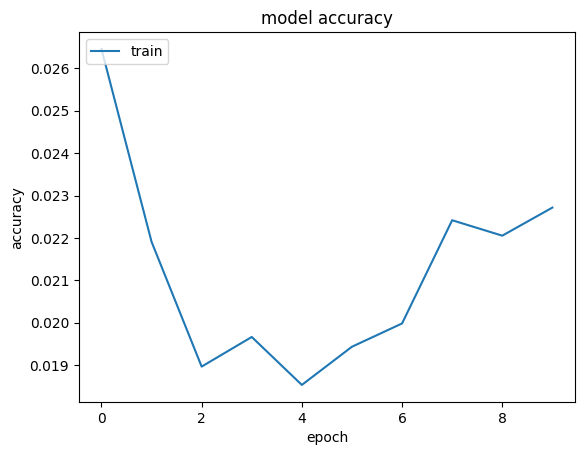

### new sentence: 99 \ffrbrn{ A   $eeeet $\(\eeeueck    a elar (( ,,I_lpp A   bcr aa{eeebbby so $H$ is a Nirlcrrrrrvn on 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9917 - loss: 0.0219
Epoch 1: loss improved from inf to 0.02183, saving model to checkpoints2/weights-improvement-01-0.0218-00100.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.9918 - loss: 0.0219
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9943 - loss: 0.0185
Epoch 2: loss improved from 0.02183 to 0.01990, saving model to checkpoints2/weights-improvement-02-0.0199-00100.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9942 - loss: 0.0186
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9940 - loss: 0.0181
Epoch 3: loss improved from 0.01990 to 0.01871, saving model to checkpoints2/weights-improvement-03-0.0187-00100.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9940 - loss: 0.0181
Epoch 4/10
15/15 ━━━━━━━━━━

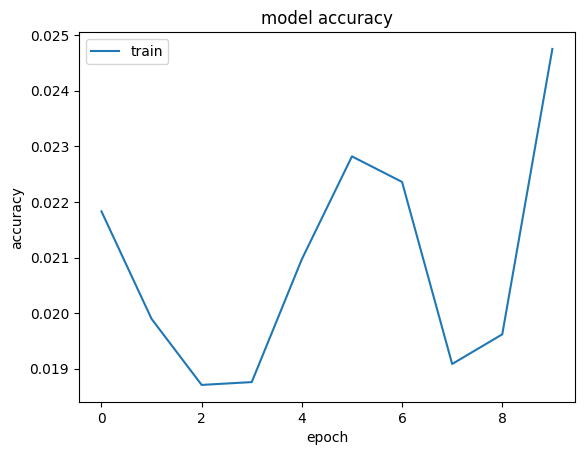

### new sentence: 100 \flrrrmmmn a    Tse $((eeeecc\l(  ihitheeiyeeeb,be a  iottr,is aeeeee $amamlillllR}_}(A$$ fe a vuyil
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9901 - loss: 0.0310
Epoch 1: loss improved from inf to 0.03182, saving model to checkpoints2/weights-improvement-01-0.0318-00101.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9901 - loss: 0.0311
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9911 - loss: 0.0288
Epoch 2: loss improved from 0.03182 to 0.03114, saving model to checkpoints2/weights-improvement-02-0.0311-00101.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9911 - loss: 0.0290
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9911 - loss: 0.0269
Epoch 3: loss improved from 0.03114 to 0.02860, saving model to checkpoints2/weights-improvement-03-0.0286-00101.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9911 - loss: 0.0270
Epoch 4/10
15/15 ━━━━━━━━━

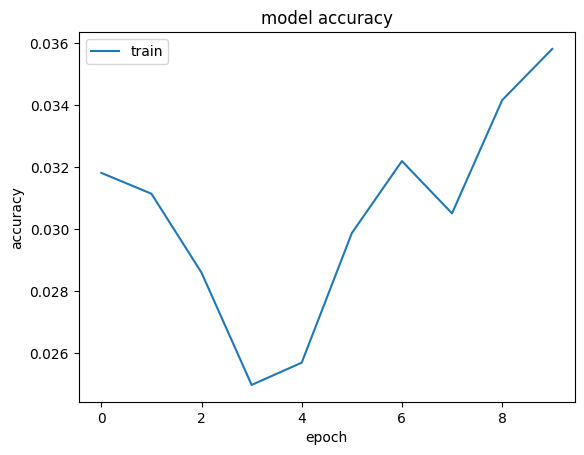

### new sentence: 101 \ffrhrhyoyy A   bs d feeeecnnyedddnefn tf thd dddyltaaa  $$$asuubbblbgyho,onouu,rf a cerrreririiiiin
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9879 - loss: 0.0388
Epoch 1: loss improved from inf to 0.04143, saving model to checkpoints2/weights-improvement-01-0.0414-00102.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9878 - loss: 0.0390
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9849 - loss: 0.0469
Epoch 2: loss did not improve from 0.04143
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.9850 - loss: 0.0469
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9875 - loss: 0.0407
Epoch 3: loss improved from 0.04143 to 0.04102, saving model to checkpoints2/weights-improvement-03-0.0410-00102.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.9875 - loss: 0.0407
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9873 - loss: 0.0387
Epoch 4: loss did not

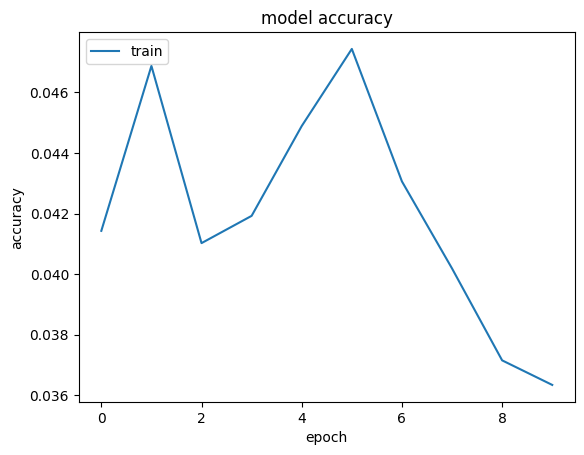

### new sentence: 102 (ff    \nn anl $$$\pi $$$ i(  ( $$$$$$$$$$$$$$$$                            z*((   zhierecc    iicsa
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9859 - loss: 0.0402
Epoch 1: loss improved from inf to 0.04407, saving model to checkpoints2/weights-improvement-01-0.0441-00103.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9859 - loss: 0.0404
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9845 - loss: 0.0512
Epoch 2: loss did not improve from 0.04407
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.9844 - loss: 0.0514
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9834 - loss: 0.0534
Epoch 3: loss did not improve from 0.04407
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9834 - loss: 0.0534
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9834 - loss: 0.0495
Epoch 4: loss did not improve from 0.04407
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9834

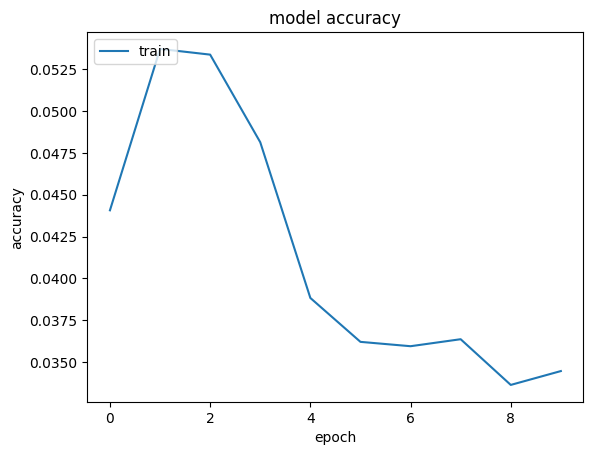

### new sentence: 103 \lfrhryyo}e,a b bB$-(((heec $\y a .oooeeeaalll cniuerabiyyyy  Ifeir  L$ is a $C$-ii pheeeaaa dhshet 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9894 - loss: 0.0355
Epoch 1: loss improved from inf to 0.03458, saving model to checkpoints2/weights-improvement-01-0.0346-00104.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9894 - loss: 0.0354
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9901 - loss: 0.0329
Epoch 2: loss improved from 0.03458 to 0.03276, saving model to checkpoints2/weights-improvement-02-0.0328-00104.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.9901 - loss: 0.0329
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9893 - loss: 0.0319
Epoch 3: loss improved from 0.03276 to 0.03131, saving model to checkpoints2/weights-improvement-03-0.0313-00104.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.9894 - loss: 0.0318
Epoch 4/10
15/15 ━━━━━━━━━

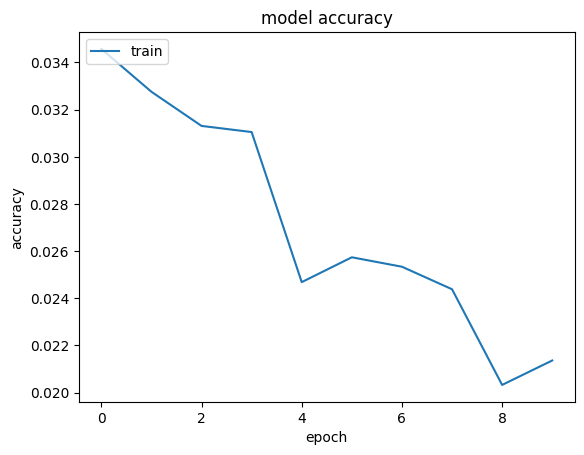

### new sentence: 104 (}f    nnn she $\$$ao n iin ma gh aTlnnnnnii fffeegasivi $\eamhaaalyy}}   I*Bnoonbreoo A$$it tho sht
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9943 - loss: 0.0181
Epoch 1: loss improved from inf to 0.01774, saving model to checkpoints2/weights-improvement-01-0.0177-00105.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9943 - loss: 0.0181
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9953 - loss: 0.0168
Epoch 2: loss improved from 0.01774 to 0.01757, saving model to checkpoints2/weights-improvement-02-0.0176-00105.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9953 - loss: 0.0168
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9943 - loss: 0.0188
Epoch 3: loss did not improve from 0.01757
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9943 - loss: 0.0189
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9935 - loss: 0.0194
Epoch 4: loss did not

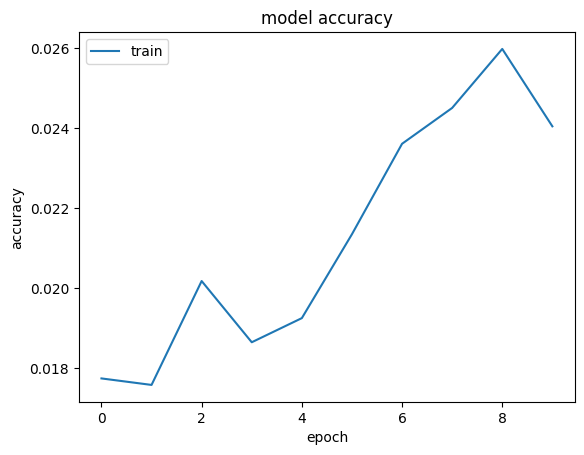

### new sentence: 105 (ff   nonnnnniii of tii sosooiiireee of a reneen marunn of $A$ isd aaaat $1---- ii a sooiiiy ofmgf $
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9933 - loss: 0.0228
Epoch 1: loss improved from inf to 0.02091, saving model to checkpoints2/weights-improvement-01-0.0209-00106.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9934 - loss: 0.0227
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9925 - loss: 0.0225
Epoch 2: loss did not improve from 0.02091
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.9926 - loss: 0.0225
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9938 - loss: 0.0197
Epoch 3: loss improved from 0.02091 to 0.01985, saving model to checkpoints2/weights-improvement-03-0.0199-00106.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9938 - loss: 0.0198
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9930 - loss: 0.0220
Epoch 4: loss did not

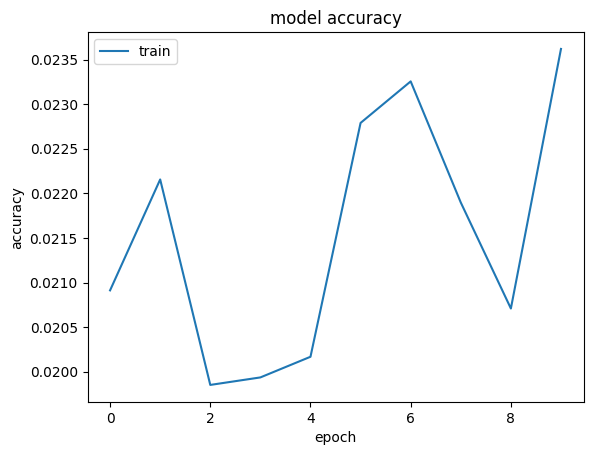

### new sentence: 106 \ffrhrnyyh} A ah thi deeeee,fflcnnasn tf the danpllggiaa aalpaano.oorhfrmy.afd \\lbbaa  wh thtddetee
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9916 - loss: 0.0250
Epoch 1: loss improved from inf to 0.02588, saving model to checkpoints2/weights-improvement-01-0.0259-00107.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9916 - loss: 0.0250
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9921 - loss: 0.0224
Epoch 2: loss improved from 0.02588 to 0.02328, saving model to checkpoints2/weights-improvement-02-0.0233-00107.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9921 - loss: 0.0224
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9924 - loss: 0.0257
Epoch 3: loss did not improve from 0.02328
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9923 - loss: 0.0257
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9925 - loss: 0.0224
Epoch 4: loss did not

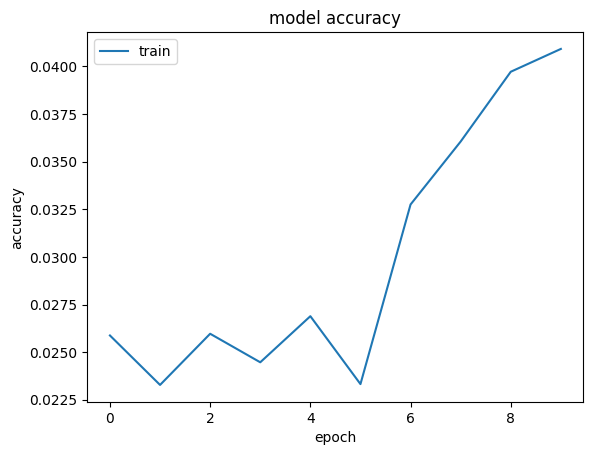

### new sentence: 107 (ff   xnnnnnnii cl tht Boooooaaa aaeeeeaoin  Gormccti}i}i}0}$$a*$irdr thetete $A$ ihche alaatatt trt
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9871 - loss: 0.0439
Epoch 1: loss improved from inf to 0.04462, saving model to checkpoints2/weights-improvement-01-0.0446-00108.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.9871 - loss: 0.0439
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9853 - loss: 0.0475
Epoch 2: loss did not improve from 0.04462
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.9852 - loss: 0.0477
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9853 - loss: 0.0465
Epoch 3: loss did not improve from 0.04462
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9852 - loss: 0.0468
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9834 - loss: 0.0551
Epoch 4: loss did not improve from 0.04462
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9834

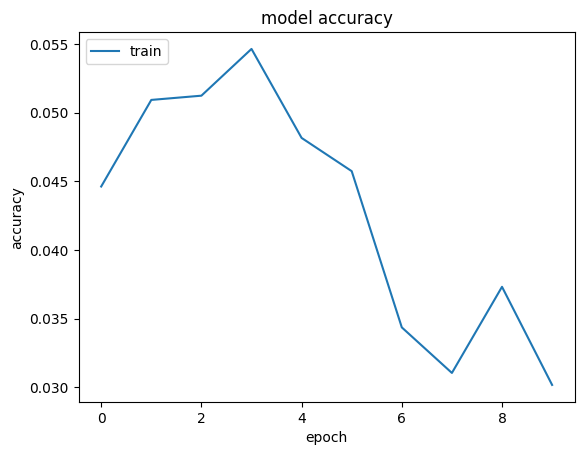

### new sentence: 108 ((     neeee $M$ iiiib i bonemhaaaa aas $A$ in nnntlaraln $$$$\l gto trtttssseeemeye af thr dddlltaa
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9930 - loss: 0.0240
Epoch 1: loss improved from inf to 0.02596, saving model to checkpoints2/weights-improvement-01-0.0260-00109.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9929 - loss: 0.0241
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9893 - loss: 0.0333
Epoch 2: loss did not improve from 0.02596
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9894 - loss: 0.0331
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9913 - loss: 0.0281
Epoch 3: loss did not improve from 0.02596
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9913 - loss: 0.0280
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9936 - loss: 0.0234
Epoch 4: loss improved from 0.02596 to 0.02482, saving model to checkpoints2/weights-improvement-04-0.

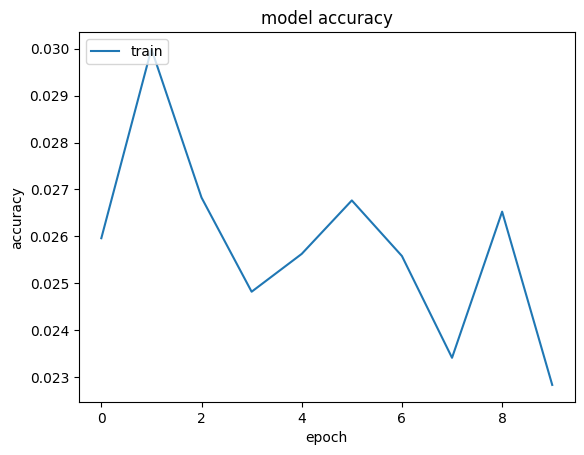

### new sentence: 109 (ff fn fnn e foneeeiiiignniffffeeeeeeee.Dfeehbaaa.wfac A \(\)))\\\ $\mi $\(\\\t A$$$$$((((((T$ 0$$\A
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9931 - loss: 0.0211
Epoch 1: loss improved from inf to 0.02150, saving model to checkpoints2/weights-improvement-01-0.0215-00110.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9931 - loss: 0.0211
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9915 - loss: 0.0279
Epoch 2: loss did not improve from 0.02150
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9916 - loss: 0.0278
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9906 - loss: 0.0300
Epoch 3: loss did not improve from 0.02150
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9906 - loss: 0.0301
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9915 - loss: 0.0293
Epoch 4: loss did not improve from 0.02150
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9914

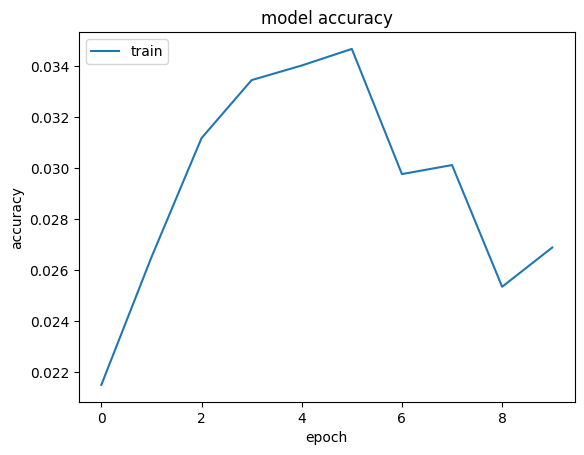

### new sentence: 110 \ffrrrZ}h}hnn{th} A   ss $\$$ieiiccta anyyyati an a Nenfbecr $$$aerreerllye},onohecrP}eeeeeeee}}}}} 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9922 - loss: 0.0270
Epoch 1: loss improved from inf to 0.02790, saving model to checkpoints2/weights-improvement-01-0.0279-00111.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9921 - loss: 0.0270
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9921 - loss: 0.0273
Epoch 2: loss improved from 0.02790 to 0.02411, saving model to checkpoints2/weights-improvement-02-0.0241-00111.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9921 - loss: 0.0271
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9935 - loss: 0.0223
Epoch 3: loss improved from 0.02411 to 0.02113, saving model to checkpoints2/weights-improvement-03-0.0211-00111.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9935 - loss: 0.0222
Epoch 4/10
15/15 ━━━━━━━━━

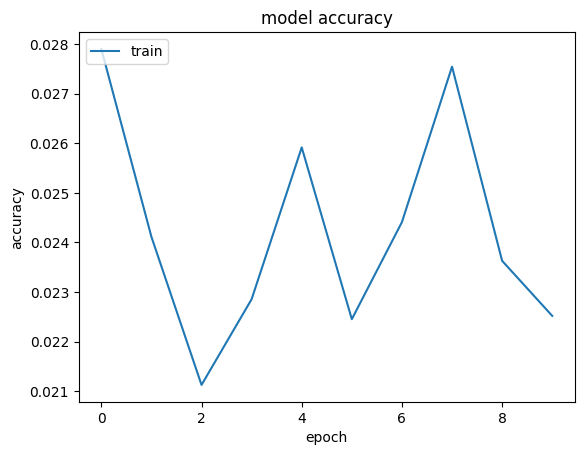

### new sentence: 111 \ff(D)  fh a $\$$00... 000000$$    $      T zccce $  (izzel $   b, {e c $((((T^ a,$^n (,Trc$$$$$(^ec
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9936 - loss: 0.0219
Epoch 1: loss improved from inf to 0.02305, saving model to checkpoints2/weights-improvement-01-0.0231-00112.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9936 - loss: 0.0220
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9932 - loss: 0.0225
Epoch 2: loss improved from 0.02305 to 0.02124, saving model to checkpoints2/weights-improvement-02-0.0212-00112.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9932 - loss: 0.0224
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9943 - loss: 0.0184
Epoch 3: loss improved from 0.02124 to 0.02049, saving model to checkpoints2/weights-improvement-03-0.0205-00112.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9943 - loss: 0.0186
Epoch 4/10
15/15 ━━━━━━━━━

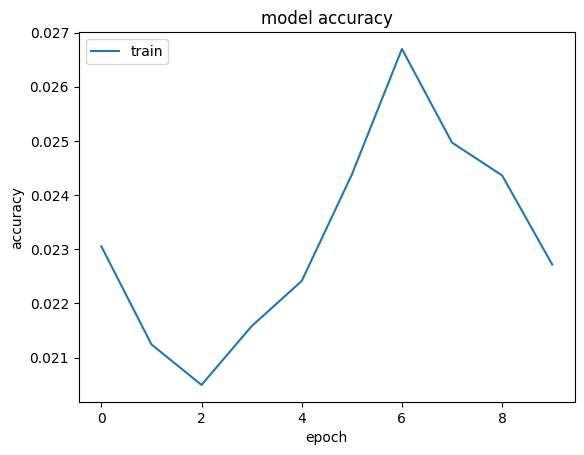

### new sentence: 112 fffrrrmr A $ Tee tap pecee $H\eea}(A^++)  neet $\yiyebal A$$ ...L{{ahl{lra  \he cppppcss onaaa  ooac
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9943 - loss: 0.0197
Epoch 1: loss improved from inf to 0.02159, saving model to checkpoints2/weights-improvement-01-0.0216-00113.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9942 - loss: 0.0198
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9926 - loss: 0.0228
Epoch 2: loss did not improve from 0.02159
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.9926 - loss: 0.0229
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9925 - loss: 0.0232
Epoch 3: loss did not improve from 0.02159
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9924 - loss: 0.0233
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9926 - loss: 0.0226
Epoch 4: loss did not improve from 0.02159
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.9925

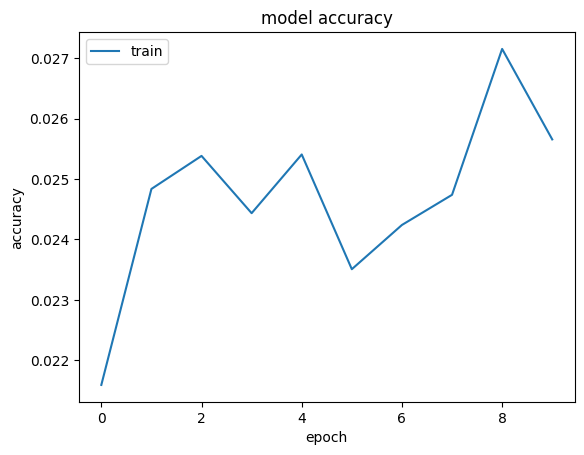

### new sentence: 113 (ff    an nnss $ $$iiinlnn a ninitttrrr anneaaareee $Tee $A$ iy s silil aroessi,cfdubru of a drrrhri
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9935 - loss: 0.0237
Epoch 1: loss improved from inf to 0.02589, saving model to checkpoints2/weights-improvement-01-0.0259-00114.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9934 - loss: 0.0238
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9903 - loss: 0.0307
Epoch 2: loss did not improve from 0.02589
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9903 - loss: 0.0306
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9916 - loss: 0.0281
Epoch 3: loss did not improve from 0.02589
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9915 - loss: 0.0282
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9883 - loss: 0.0334
Epoch 4: loss did not improve from 0.02589
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9883

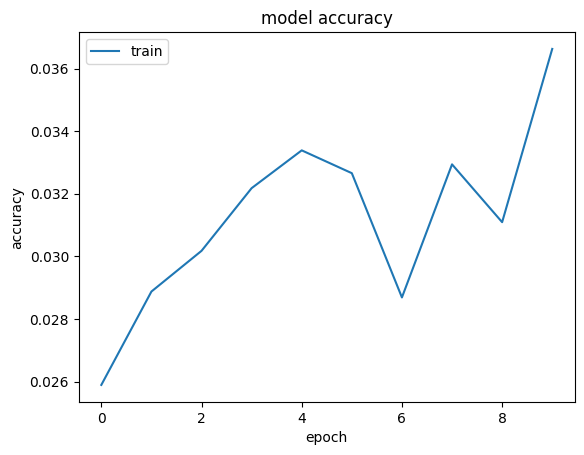

### new sentence: 114 (ff    nn nnss $ \{immmmm A)iirrrrrehh bn $\$.isdn phat $A$ he ahdltttaddldyy  $$ Inr a srueuaaaz dr
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9897 - loss: 0.0328
Epoch 1: loss improved from inf to 0.03387, saving model to checkpoints2/weights-improvement-01-0.0339-00115.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9897 - loss: 0.0329
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9898 - loss: 0.0340
Epoch 2: loss did not improve from 0.03387
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9898 - loss: 0.0341
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9897 - loss: 0.0341
Epoch 3: loss did not improve from 0.03387
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9896 - loss: 0.0343
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9907 - loss: 0.0304
Epoch 4: loss improved from 0.03387 to 0.03283, saving model to checkpoints2/weights-improvement-04-0.

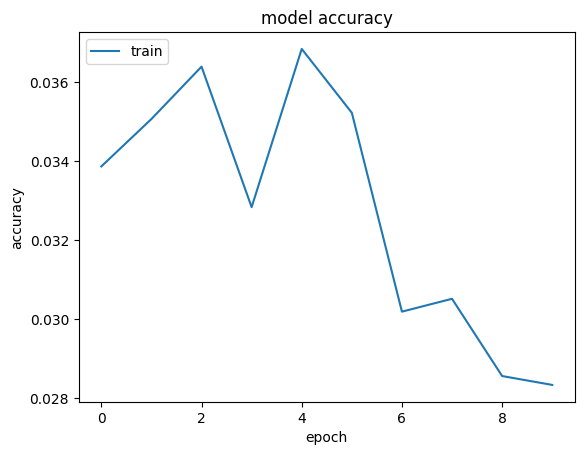

### new sentence: 115 \ffrhrhhh} A ahr $\$\eemc\\\($$$  LLLeheee{e,},, $iit aeeallaaee annchbb{y}e af $A$ issnn $\_ G_]]u 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9915 - loss: 0.0272
Epoch 1: loss improved from inf to 0.03051, saving model to checkpoints2/weights-improvement-01-0.0305-00116.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9914 - loss: 0.0274
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9901 - loss: 0.0311
Epoch 2: loss did not improve from 0.03051
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9901 - loss: 0.0311
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9910 - loss: 0.0275
Epoch 3: loss improved from 0.03051 to 0.02901, saving model to checkpoints2/weights-improvement-03-0.0290-00116.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9909 - loss: 0.0276
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9919 - loss: 0.0271
Epoch 4: loss improve

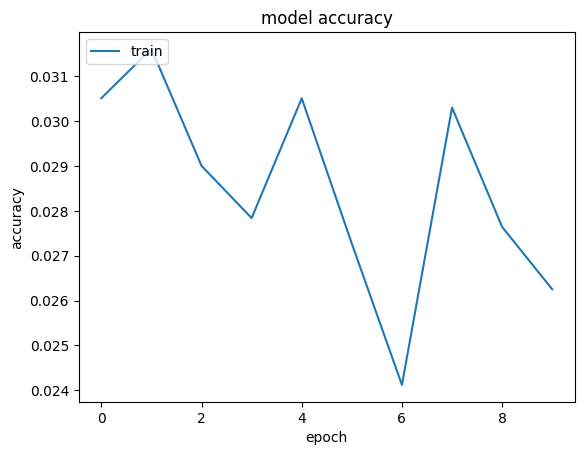

### new sentence: 116 (ff fn nnn she fnnmmgriig le $A$ in a poppperreve ii $A$ iheneet.tn teete tortt in $A$ in the NNliii
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9912 - loss: 0.0283
Epoch 1: loss improved from inf to 0.02884, saving model to checkpoints2/weights-improvement-01-0.0288-00117.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9912 - loss: 0.0284
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9912 - loss: 0.0285
Epoch 2: loss did not improve from 0.02884
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9912 - loss: 0.0286
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9916 - loss: 0.0278
Epoch 3: loss improved from 0.02884 to 0.02823, saving model to checkpoints2/weights-improvement-03-0.0282-00117.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9916 - loss: 0.0278
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9926 - loss: 0.0247
Epoch 4: loss improve

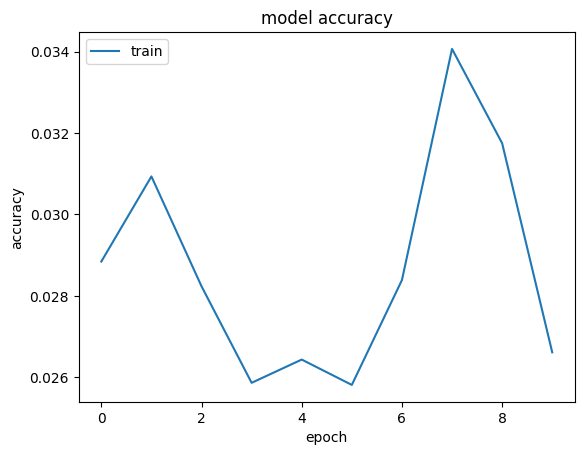

### new sentence: 117 (ff fn nnn phete thiheril  \e alpssacrr deeera  aednlllllllllm}mm}e,H$$aechhaphhtpw}} }n=$\$Aihesesi
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9907 - loss: 0.0300
Epoch 1: loss improved from inf to 0.03026, saving model to checkpoints2/weights-improvement-01-0.0303-00118.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9906 - loss: 0.0300
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9911 - loss: 0.0276
Epoch 2: loss improved from 0.03026 to 0.02920, saving model to checkpoints2/weights-improvement-02-0.0292-00118.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9910 - loss: 0.0277
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9926 - loss: 0.0250
Epoch 3: loss improved from 0.02920 to 0.02527, saving model to checkpoints2/weights-improvement-03-0.0253-00118.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9926 - loss: 0.0251
Epoch 4/10
15/15 ━━━━━━━━━

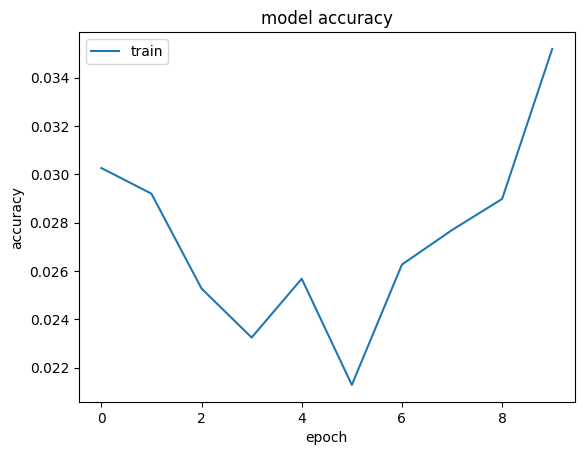

### new sentence: 118 (ff  nnnnniiii cl the soosioi $oe anl $A$ io annnrrrrre alssttat)$A$,ooocressdtyyyy  I_lessssssooo} 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9909 - loss: 0.0293
Epoch 1: loss improved from inf to 0.02897, saving model to checkpoints2/weights-improvement-01-0.0290-00119.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9909 - loss: 0.0293
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9905 - loss: 0.0326
Epoch 2: loss did not improve from 0.02897
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9905 - loss: 0.0325
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9909 - loss: 0.0277
Epoch 3: loss improved from 0.02897 to 0.02707, saving model to checkpoints2/weights-improvement-03-0.0271-00119.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.9910 - loss: 0.0277
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9920 - loss: 0.0256
Epoch 4: loss improve

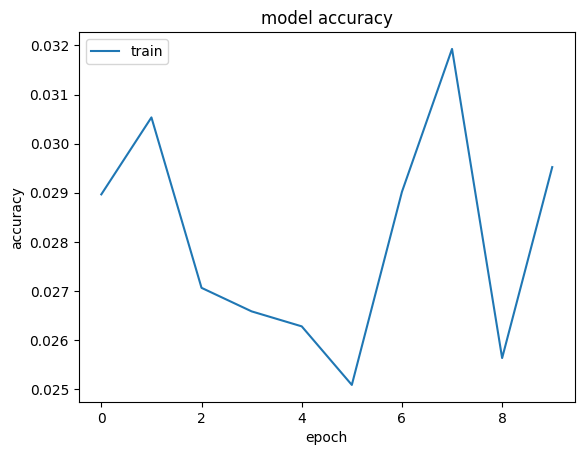

### new sentence: 119 (\f    nnnnsniii    aidrggglDD__e}hc(\)a)q)a)\\\\l___--aaans ,,(  eee $G$ bi i womee (a$ ii nhoeetez
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9919 - loss: 0.0273
Epoch 1: loss improved from inf to 0.03107, saving model to checkpoints2/weights-improvement-01-0.0311-00120.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.9918 - loss: 0.0275
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9903 - loss: 0.0279
Epoch 2: loss improved from 0.03107 to 0.02674, saving model to checkpoints2/weights-improvement-02-0.0267-00120.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9904 - loss: 0.0278
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9922 - loss: 0.0261
Epoch 3: loss did not improve from 0.02674
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9922 - loss: 0.0261
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9912 - loss: 0.0257
Epoch 4: loss did not

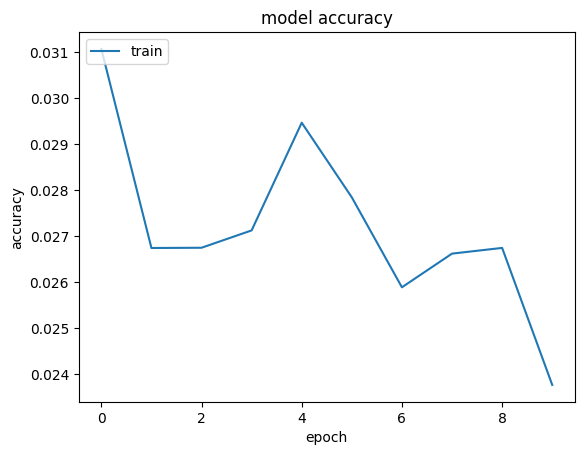

### new sentence: 120 (ff nh snn e nnnmeriiill af aadddradari if the donoooiollri ofaaaaa aof a fenenaaaaair  T' )Indoie t
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9920 - loss: 0.0220
Epoch 1: loss improved from inf to 0.02239, saving model to checkpoints2/weights-improvement-01-0.0224-00121.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9920 - loss: 0.0221
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9933 - loss: 0.0223
Epoch 2: loss did not improve from 0.02239
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9933 - loss: 0.0224
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9934 - loss: 0.0234
Epoch 3: loss did not improve from 0.02239
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9934 - loss: 0.0234
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9930 - loss: 0.0234
Epoch 4: loss did not improve from 0.02239
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9929

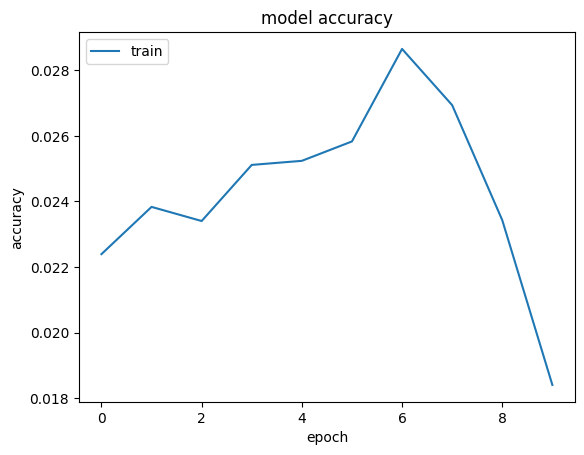

### new sentence: 121 (ff   nnnnnniii of $A$ iidn $\$ asm ab,$^$ hheeoer,$T(((bB  b w 10(TT a (.($$$$$$Cz $ (iieet $   \  
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9942 - loss: 0.0191
Epoch 1: loss improved from inf to 0.01962, saving model to checkpoints2/weights-improvement-01-0.0196-00122.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9941 - loss: 0.0192
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9927 - loss: 0.0243
Epoch 2: loss did not improve from 0.01962
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.9927 - loss: 0.0241
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9930 - loss: 0.0227
Epoch 3: loss did not improve from 0.01962
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9930 - loss: 0.0225
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9932 - loss: 0.0188
Epoch 4: loss improved from 0.01962 to 0.01892, saving model to checkpoints2/weights-improvement-04-0.

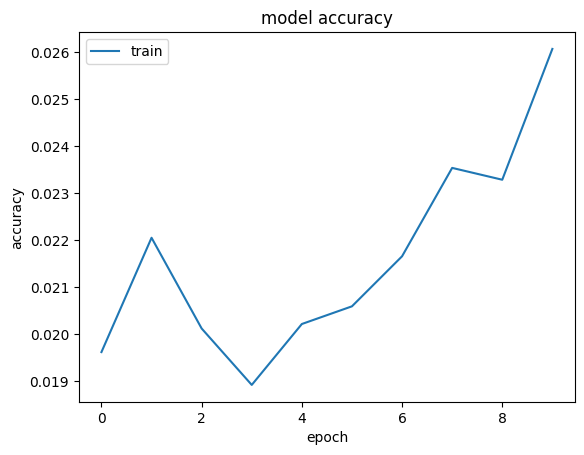

### new sentence: 122 (\f    \nnnnnillli A \iiig 1geeeeeihh Aa$$ihduheer AA$ isirh is a fosttttiiieeeii feviuannnnniiii ff
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9925 - loss: 0.0225
Epoch 1: loss improved from inf to 0.02442, saving model to checkpoints2/weights-improvement-01-0.0244-00123.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9924 - loss: 0.0226
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9934 - loss: 0.0216
Epoch 2: loss did not improve from 0.02442
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9933 - loss: 0.0218
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9924 - loss: 0.0244
Epoch 3: loss did not improve from 0.02442
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9924 - loss: 0.0246
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9915 - loss: 0.0279
Epoch 4: loss did not improve from 0.02442
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9915

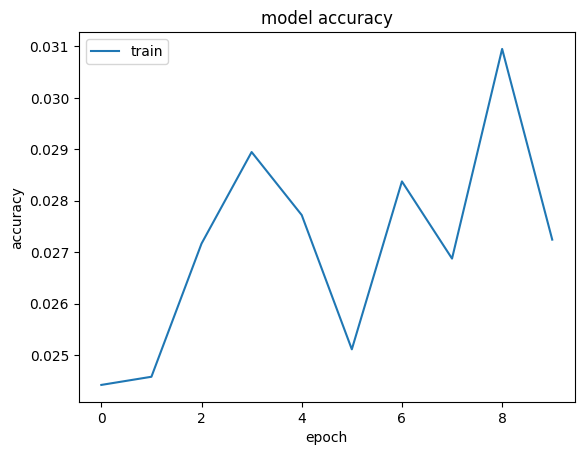

### new sentence: 123 \ffrhrnrnnnn A   ae   \eee (b\abbbaaaqyyyaaa     fccchii $\$ aherhb{ A       $$zeeeaarlll af \ \epse
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9908 - loss: 0.0277
Epoch 1: loss improved from inf to 0.02786, saving model to checkpoints2/weights-improvement-01-0.0279-00124.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9908 - loss: 0.0277
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9907 - loss: 0.0293
Epoch 2: loss did not improve from 0.02786
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9906 - loss: 0.0294
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9902 - loss: 0.0321
Epoch 3: loss did not improve from 0.02786
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9901 - loss: 0.0322
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9886 - loss: 0.0355
Epoch 4: loss did not improve from 0.02786
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9886

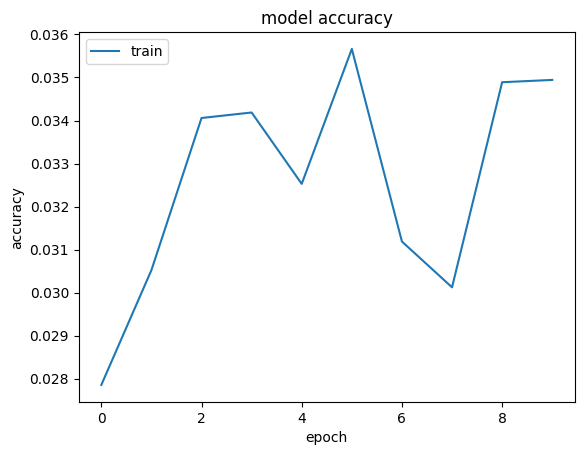

### new sentence: 124 (ff    nn nhss a folillllll iiiiraaddayyyy  feehr so gldlyaaie to whiiii rrrrrrtete cl $A$ -In t nin
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9901 - loss: 0.0307
Epoch 1: loss improved from inf to 0.03138, saving model to checkpoints2/weights-improvement-01-0.0314-00125.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9901 - loss: 0.0307
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9910 - loss: 0.0308
Epoch 2: loss improved from 0.03138 to 0.03078, saving model to checkpoints2/weights-improvement-02-0.0308-00125.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9909 - loss: 0.0308
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9904 - loss: 0.0293
Epoch 3: loss improved from 0.03078 to 0.02875, saving model to checkpoints2/weights-improvement-03-0.0287-00125.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9904 - loss: 0.0293
Epoch 4/10
15/15 ━━━━━━━━━

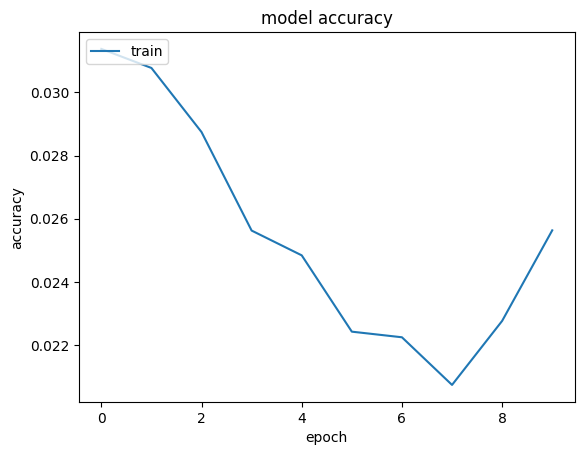

### new sentence: 125 (ff    nn nsss $ \aammmm A $  Leeaaaaay  aeeehee\{ \$,ahdhhhia aaaal $$$\\ttppp8} ,  \ee appe phet $
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9929 - loss: 0.0240
Epoch 1: loss improved from inf to 0.02769, saving model to checkpoints2/weights-improvement-01-0.0277-00126.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9928 - loss: 0.0242
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9939 - loss: 0.0202
Epoch 2: loss improved from 0.02769 to 0.02242, saving model to checkpoints2/weights-improvement-02-0.0224-00126.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9938 - loss: 0.0204
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9921 - loss: 0.0256
Epoch 3: loss did not improve from 0.02242
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9921 - loss: 0.0256
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9937 - loss: 0.0205
Epoch 4: loss improve

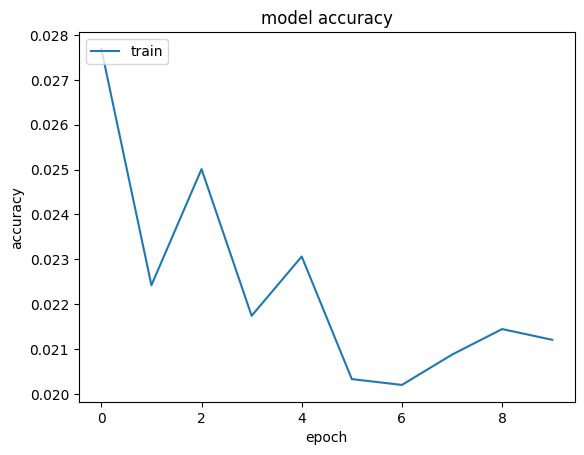

### new sentence: 126 ff fnn nn ner fnnnrrrr a annsrrrrrrrmm ff thf dll $-  is d Nirnssrll ln alctit  deds issipepe on $A$
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9935 - loss: 0.0209
Epoch 1: loss improved from inf to 0.02011, saving model to checkpoints2/weights-improvement-01-0.0201-00127.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9936 - loss: 0.0209
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9940 - loss: 0.0207
Epoch 2: loss did not improve from 0.02011
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.9940 - loss: 0.0209
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9908 - loss: 0.0260
Epoch 3: loss did not improve from 0.02011
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.9908 - loss: 0.0261
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9922 - loss: 0.0251
Epoch 4: loss did not improve from 0.02011
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9922

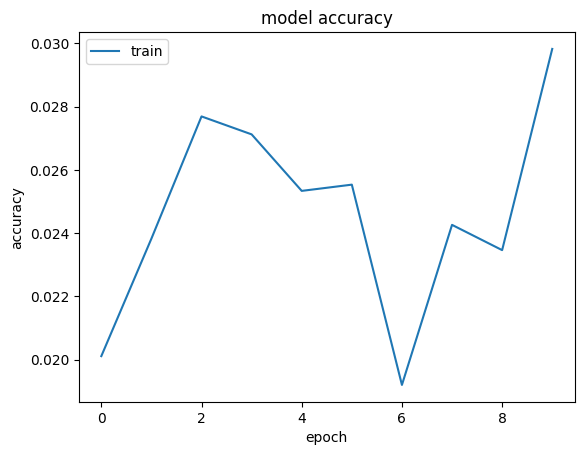

### new sentence: 127 (ffrrbrroommmtm}ir A  is a siiiaaaaaann  $$ feehheeeed $$\( ss cosovithehsss,$f   \t theveraar  $$=R
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9917 - loss: 0.0260
Epoch 1: loss improved from inf to 0.02873, saving model to checkpoints2/weights-improvement-01-0.0287-00128.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9916 - loss: 0.0262
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9914 - loss: 0.0269
Epoch 2: loss improved from 0.02873 to 0.02678, saving model to checkpoints2/weights-improvement-02-0.0268-00128.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9914 - loss: 0.0269
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9919 - loss: 0.0275
Epoch 3: loss did not improve from 0.02678
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9919 - loss: 0.0275
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9918 - loss: 0.0261
Epoch 4: loss improve

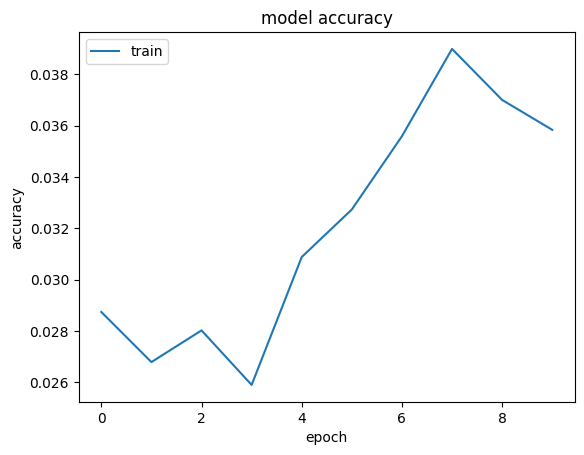

### new sentence: 128 (( \f noo codeeea  \p phose that if itn sonnh bee $A$ ho a piiicaalll aaaalllyyyyiii ir t rrennzeyiy
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9888 - loss: 0.0351
Epoch 1: loss improved from inf to 0.03493, saving model to checkpoints2/weights-improvement-01-0.0349-00129.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9888 - loss: 0.0351
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9918 - loss: 0.0275
Epoch 2: loss improved from 0.03493 to 0.03014, saving model to checkpoints2/weights-improvement-02-0.0301-00129.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9917 - loss: 0.0276
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9894 - loss: 0.0309
Epoch 3: loss did not improve from 0.03014
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.9894 - loss: 0.0310
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9910 - loss: 0.0298
Epoch 4: loss did not

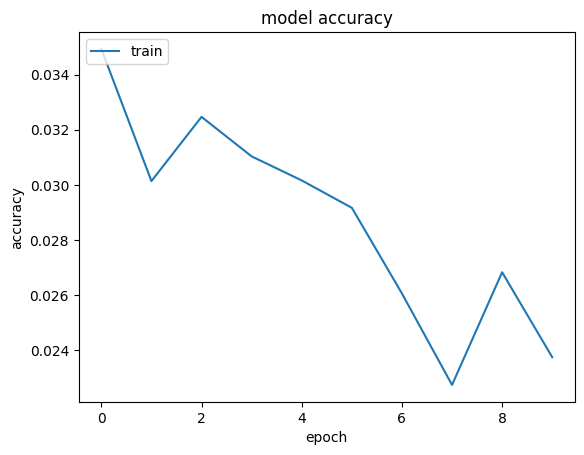

### new sentence: 129 (\f fnnnnniii flte $ \se peep pf grlmll $B$^oosmrasa spppcctio of a crnphmmenezy $A$ andshcaaay sffc
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9925 - loss: 0.0249
Epoch 1: loss improved from inf to 0.02411, saving model to checkpoints2/weights-improvement-01-0.0241-00130.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9925 - loss: 0.0249
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9933 - loss: 0.0234
Epoch 2: loss improved from 0.02411 to 0.02265, saving model to checkpoints2/weights-improvement-02-0.0227-00130.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9933 - loss: 0.0233
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9921 - loss: 0.0237
Epoch 3: loss did not improve from 0.02265
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9921 - loss: 0.0237
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9928 - loss: 0.0231
Epoch 4: loss did not

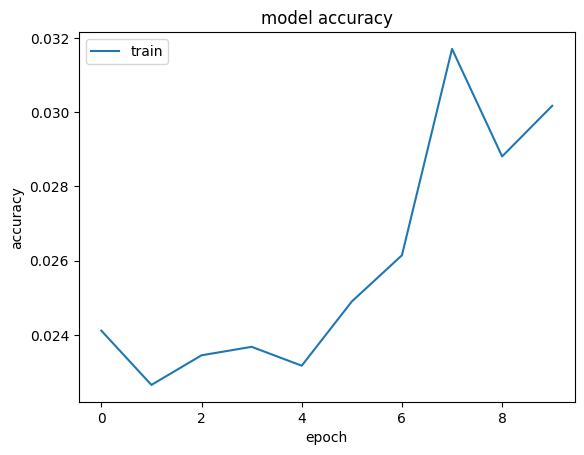

### new sentence: 130 \fffrnr-A     eeeeetttt wh she soonttyedsddc a aeeinnnn oirrlil on a $\rrrhaalillliicffffff   aaeier
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9902 - loss: 0.0298
Epoch 1: loss improved from inf to 0.03136, saving model to checkpoints2/weights-improvement-01-0.0314-00131.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9902 - loss: 0.0299
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9910 - loss: 0.0281
Epoch 2: loss improved from 0.03136 to 0.02717, saving model to checkpoints2/weights-improvement-02-0.0272-00131.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.9910 - loss: 0.0281
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9914 - loss: 0.0284
Epoch 3: loss did not improve from 0.02717
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9914 - loss: 0.0284
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9915 - loss: 0.0254
Epoch 4: loss improve

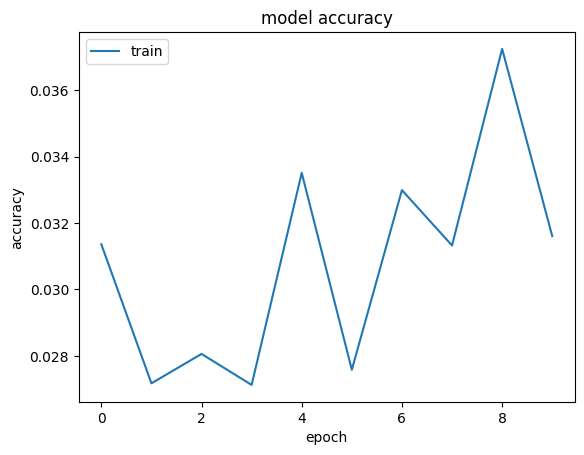

### new sentence: 131 (ff  nnnnniriii il $A$ isdn $$$ asdnl ih aoooe aoyevyims oooaatarn $\$Ahhmical  \$ nn a coootttii pe
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9923 - loss: 0.0256
Epoch 1: loss improved from inf to 0.02561, saving model to checkpoints2/weights-improvement-01-0.0256-00132.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9923 - loss: 0.0256
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9904 - loss: 0.0290
Epoch 2: loss did not improve from 0.02561
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9904 - loss: 0.0290
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9917 - loss: 0.0280
Epoch 3: loss did not improve from 0.02561
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9917 - loss: 0.0280
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9926 - loss: 0.0242
Epoch 4: loss improved from 0.02561 to 0.02190, saving model to checkpoints2/weights-improvement-04-0.

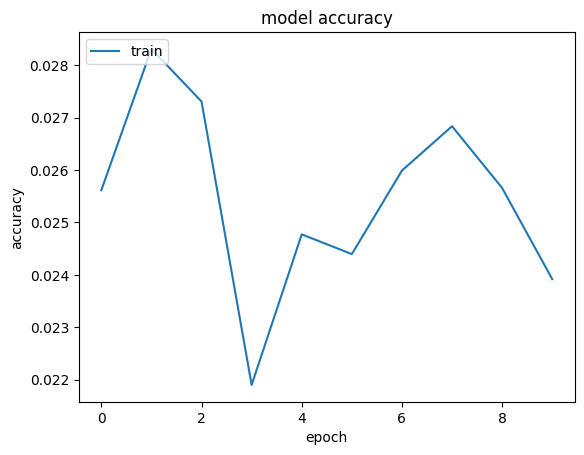

### new sentence: 132 \ffrhr A    Teeehaal\\ \ \\   \\ a \plmmemaa^ oeeie ioriritiz.sf theeedtada aosouirinn oo a suocerem
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9914 - loss: 0.0265
Epoch 1: loss improved from inf to 0.02554, saving model to checkpoints2/weights-improvement-01-0.0255-00133.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9915 - loss: 0.0265
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9941 - loss: 0.0200
Epoch 2: loss improved from 0.02554 to 0.01968, saving model to checkpoints2/weights-improvement-02-0.0197-00133.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9941 - loss: 0.0200
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9930 - loss: 0.0221
Epoch 3: loss did not improve from 0.01968
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9929 - loss: 0.0222
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9928 - loss: 0.0235
Epoch 4: loss did not

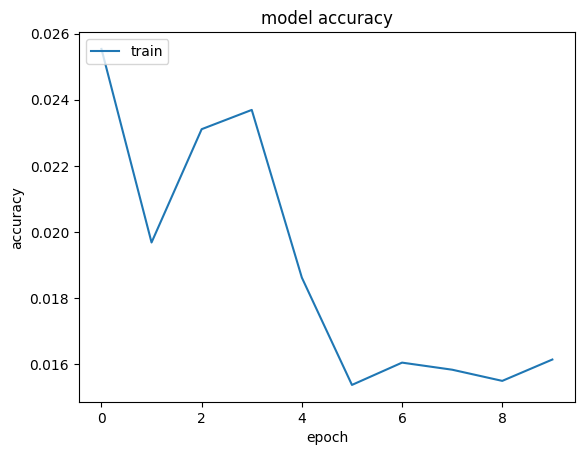

### new sentence: 133 (ff nnn nnveeelyevyye,insssetiiii.if the cllllall $W$   Wsttbbbbhho  I$ iiirhcghlg on thp pnrttrttid
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9949 - loss: 0.0153
Epoch 1: loss improved from inf to 0.01506, saving model to checkpoints2/weights-improvement-01-0.0151-00134.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9949 - loss: 0.0153
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9958 - loss: 0.0141
Epoch 2: loss improved from 0.01506 to 0.01463, saving model to checkpoints2/weights-improvement-02-0.0146-00134.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9957 - loss: 0.0141
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9945 - loss: 0.0178
Epoch 3: loss did not improve from 0.01463
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9945 - loss: 0.0179
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9943 - loss: 0.0204
Epoch 4: loss did not

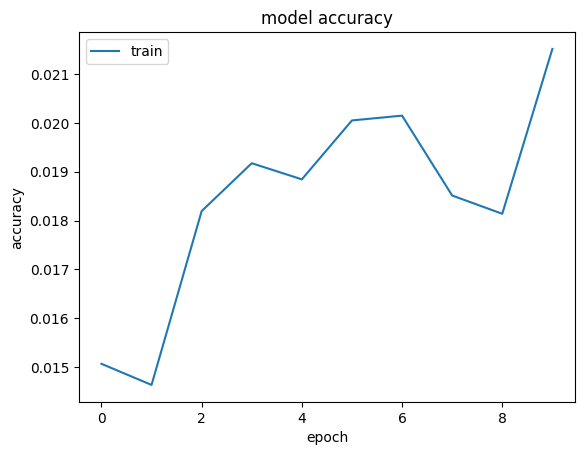

### new sentence: 134 \ffrhrrr A ae the seneeeeeeeeneefssoo H Aavi a   oeeb $\$ ir a Pininaaaallyevi offuiin dvd ${ett    
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9937 - loss: 0.0181
Epoch 1: loss improved from inf to 0.01829, saving model to checkpoints2/weights-improvement-01-0.0183-00135.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9937 - loss: 0.0181
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9943 - loss: 0.0186
Epoch 2: loss did not improve from 0.01829
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9943 - loss: 0.0186
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9952 - loss: 0.0161
Epoch 3: loss improved from 0.01829 to 0.01780, saving model to checkpoints2/weights-improvement-03-0.0178-00135.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.9952 - loss: 0.0162
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9942 - loss: 0.0176
Epoch 4: loss improve

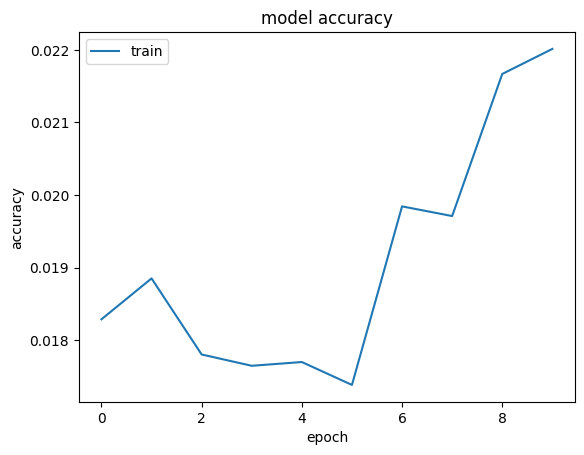

### new sentence: 135 fffrrru A   Tee thpp cnnenrnrennoy ff rurd phphmyyyii iiwiit $$$$ihiirisill ofas cn ang zepteeeeeyii
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9922 - loss: 0.0258
Epoch 1: loss improved from inf to 0.02722, saving model to checkpoints2/weights-improvement-01-0.0272-00136.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9921 - loss: 0.0259
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9902 - loss: 0.0307
Epoch 2: loss did not improve from 0.02722
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9902 - loss: 0.0307
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9900 - loss: 0.0322
Epoch 3: loss did not improve from 0.02722
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9900 - loss: 0.0320
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9894 - loss: 0.0340
Epoch 4: loss did not improve from 0.02722
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9894

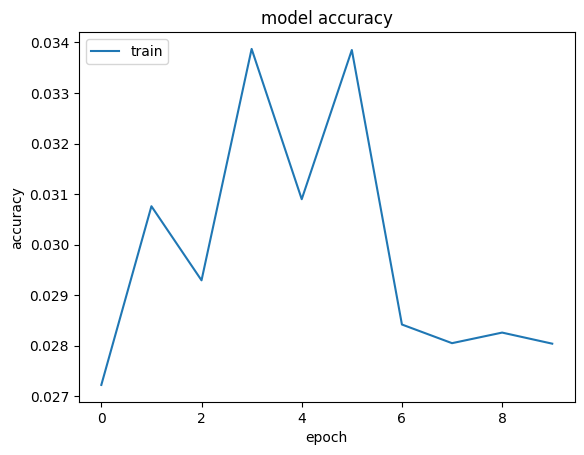

### new sentence: 136 (\f fn f nonnniiiillllli fffsiruigg.if aarezaaa anseeeiiinionnon ooosueuu.a weehhaan anruiiiiitttnnn
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9920 - loss: 0.0257
Epoch 1: loss improved from inf to 0.02567, saving model to checkpoints2/weights-improvement-01-0.0257-00137.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9920 - loss: 0.0257
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9934 - loss: 0.0237
Epoch 2: loss did not improve from 0.02567
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.9933 - loss: 0.0239
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9916 - loss: 0.0265
Epoch 3: loss did not improve from 0.02567
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9916 - loss: 0.0266
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9925 - loss: 0.0233
Epoch 4: loss improved from 0.02567 to 0.02550, saving model to checkpoints2/weights-improvement-04-0.

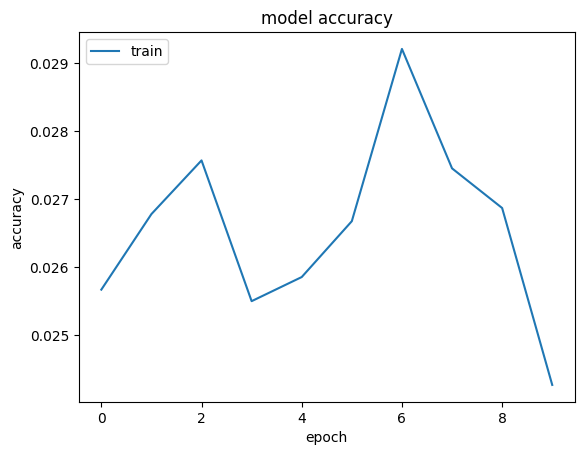

### new sentence: 137 (ff = fonnnniii cfcggg  ooiir indpeeyy  A$ in a pene  A$-ir nht benebgreeeppp ,A_(theh phatllg $A$ i
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9929 - loss: 0.0223
Epoch 1: loss improved from inf to 0.02254, saving model to checkpoints2/weights-improvement-01-0.0225-00138.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9929 - loss: 0.0223
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9924 - loss: 0.0253
Epoch 2: loss did not improve from 0.02254
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9924 - loss: 0.0253
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9934 - loss: 0.0229
Epoch 3: loss did not improve from 0.02254
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9934 - loss: 0.0230
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9929 - loss: 0.0235
Epoch 4: loss did not improve from 0.02254
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9929

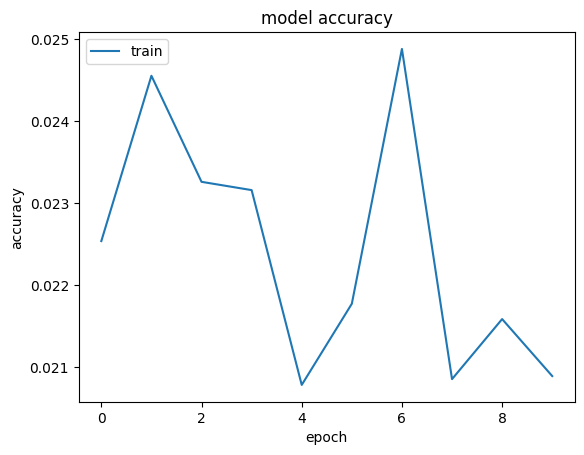

### new sentence: 138 (ffr A   Wn nnrtlt $ \\lpcc{ A$$gfdt $D$ bi a Cnnnnaaalllniiin  \$ is $0$,ie sa prlpaaaad gsss $\$ i
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9928 - loss: 0.0230
Epoch 1: loss improved from inf to 0.02434, saving model to checkpoints2/weights-improvement-01-0.0243-00139.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9928 - loss: 0.0231
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9916 - loss: 0.0249
Epoch 2: loss improved from 0.02434 to 0.02359, saving model to checkpoints2/weights-improvement-02-0.0236-00139.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9917 - loss: 0.0248
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9946 - loss: 0.0201
Epoch 3: loss improved from 0.02359 to 0.02016, saving model to checkpoints2/weights-improvement-03-0.0202-00139.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9945 - loss: 0.0201
Epoch 4/10
15/15 ━━━━━━━━━

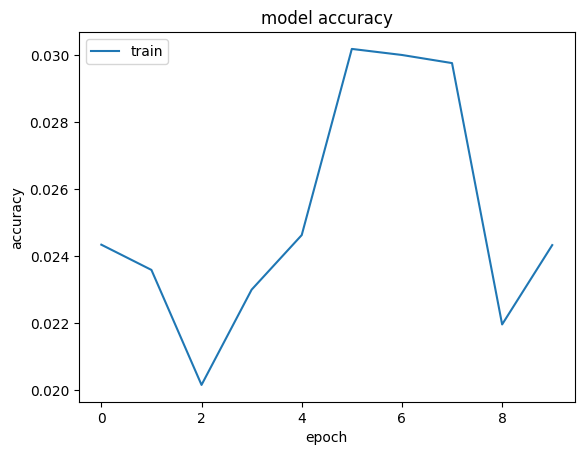

### new sentence: 139 (\f    \nn ssi $$\,,b=tit $\$ $$aaa tazeeezyyy on tre ddddddttrrrtsnn aaveetuuu.ifttb ii rrr rortlri
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9927 - loss: 0.0226
Epoch 1: loss improved from inf to 0.02343, saving model to checkpoints2/weights-improvement-01-0.0234-00140.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.9927 - loss: 0.0226
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9943 - loss: 0.0193
Epoch 2: loss improved from 0.02343 to 0.02148, saving model to checkpoints2/weights-improvement-02-0.0215-00140.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9943 - loss: 0.0194
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9917 - loss: 0.0241
Epoch 3: loss did not improve from 0.02148
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9918 - loss: 0.0240
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9917 - loss: 0.0238
Epoch 4: loss did not

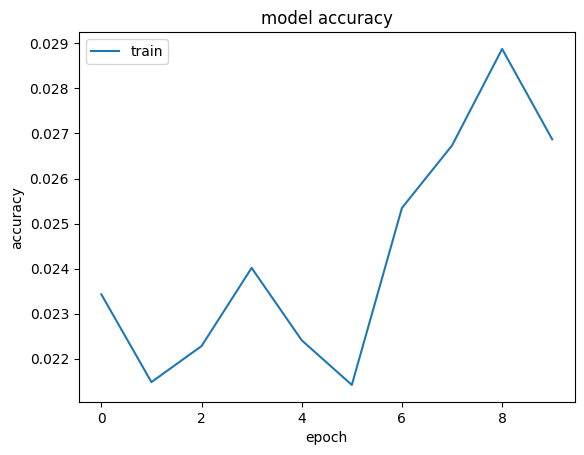

### new sentence: 140 (\fr A   Wh nnttl $\\{pcc{\{uq  attnr a siiihaa $C$$eeeeheb lpauefs of tnndnniaa  Aosssecleeevno   $
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9913 - loss: 0.0273
Epoch 1: loss improved from inf to 0.02916, saving model to checkpoints2/weights-improvement-01-0.0292-00141.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9913 - loss: 0.0274
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9930 - loss: 0.0244
Epoch 2: loss improved from 0.02916 to 0.02679, saving model to checkpoints2/weights-improvement-02-0.0268-00141.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9930 - loss: 0.0245
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9928 - loss: 0.0239
Epoch 3: loss did not improve from 0.02679
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9927 - loss: 0.0241
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9929 - loss: 0.0229
Epoch 4: loss improve

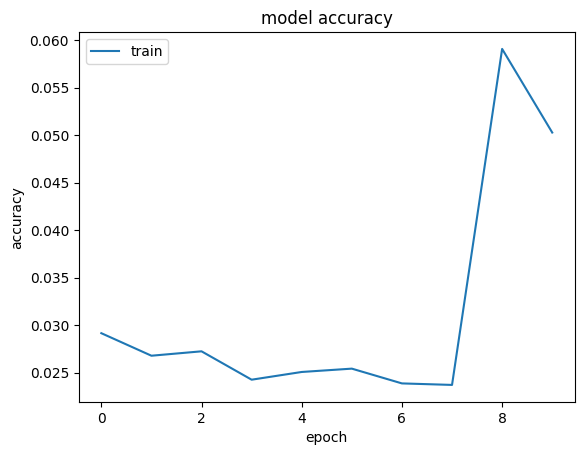

### new sentence: 141 (\f    nn shoo a fomittt su c foaakamcc $C$ cs c solst pheeeraai a aassscuuuut wf a srereegggg teat 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9841 - loss: 0.0491
Epoch 1: loss improved from inf to 0.04670, saving model to checkpoints2/weights-improvement-01-0.0467-00142.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9841 - loss: 0.0490
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9870 - loss: 0.0385
Epoch 2: loss improved from 0.04670 to 0.03914, saving model to checkpoints2/weights-improvement-02-0.0391-00142.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - accuracy: 0.9870 - loss: 0.0385
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9893 - loss: 0.0336
Epoch 3: loss improved from 0.03914 to 0.03699, saving model to checkpoints2/weights-improvement-03-0.0370-00142.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9893 - loss: 0.0338
Epoch 4/10
15/15 ━━━━━━━━━

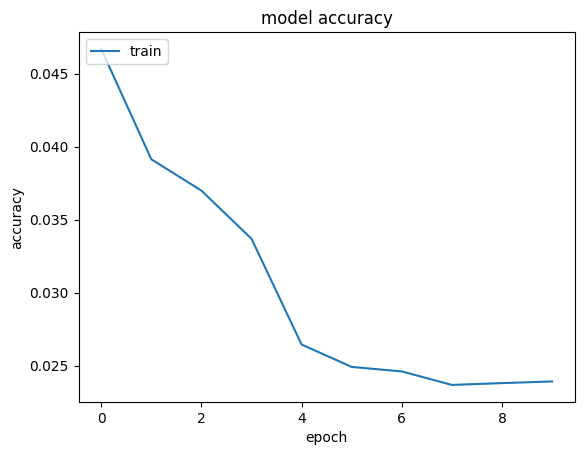

### new sentence: 142 (ff xhnn fheeeelyi aftiirati in aavaariin in $A$ indr that phe |emyy ofakiiiiii fhoiiti.loouimn aid 
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9917 - loss: 0.0241
Epoch 1: loss improved from inf to 0.02225, saving model to checkpoints2/weights-improvement-01-0.0222-00143.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9917 - loss: 0.0240
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9928 - loss: 0.0230
Epoch 2: loss improved from 0.02225 to 0.02209, saving model to checkpoints2/weights-improvement-02-0.0221-00143.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9928 - loss: 0.0229
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9934 - loss: 0.0199
Epoch 3: loss improved from 0.02209 to 0.02147, saving model to checkpoints2/weights-improvement-03-0.0215-00143.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9934 - loss: 0.0200
Epoch 4/10
15/15 ━━━━━━━━━

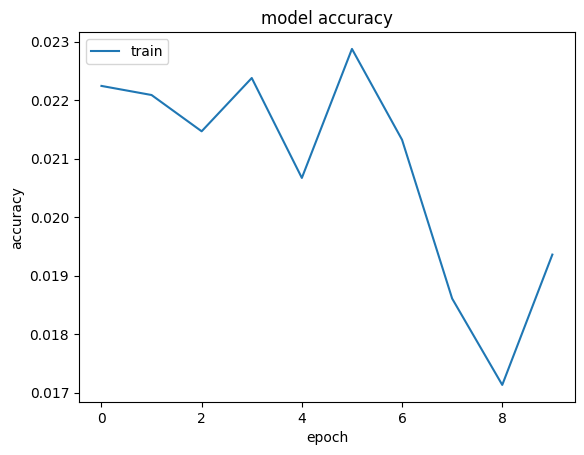

### new sentence: 143 (\fr A   We nuttit $\\ pll uremeeeee aaerrarlat S$mppp tr uuoss ffaei tt a banat teruett mf $A$.br i
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9948 - loss: 0.0179
Epoch 1: loss improved from inf to 0.01838, saving model to checkpoints2/weights-improvement-01-0.0184-00144.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9948 - loss: 0.0180
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9957 - loss: 0.0151
Epoch 2: loss improved from 0.01838 to 0.01611, saving model to checkpoints2/weights-improvement-02-0.0161-00144.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9957 - loss: 0.0151
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9941 - loss: 0.0185
Epoch 3: loss did not improve from 0.01611
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9941 - loss: 0.0185
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9946 - loss: 0.0182
Epoch 4: loss did not

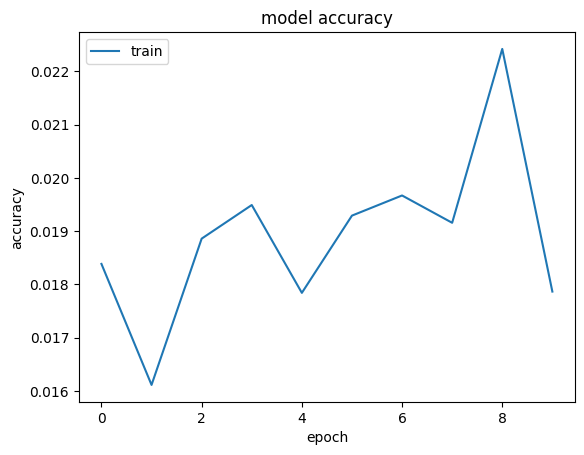

### new sentence: 144 (( ff nnnsetgly dlsperiti ooomecaas  A$ is a contw cxmevaaaa aoaaaaaoirr ff thz za piyiy pf ttteiirn
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9949 - loss: 0.0170
Epoch 1: loss improved from inf to 0.01770, saving model to checkpoints2/weights-improvement-01-0.0177-00145.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9949 - loss: 0.0170
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9948 - loss: 0.0166
Epoch 2: loss improved from 0.01770 to 0.01574, saving model to checkpoints2/weights-improvement-02-0.0157-00145.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9948 - loss: 0.0165
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9939 - loss: 0.0181
Epoch 3: loss did not improve from 0.01574
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9940 - loss: 0.0181
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9941 - loss: 0.0183
Epoch 4: loss did not

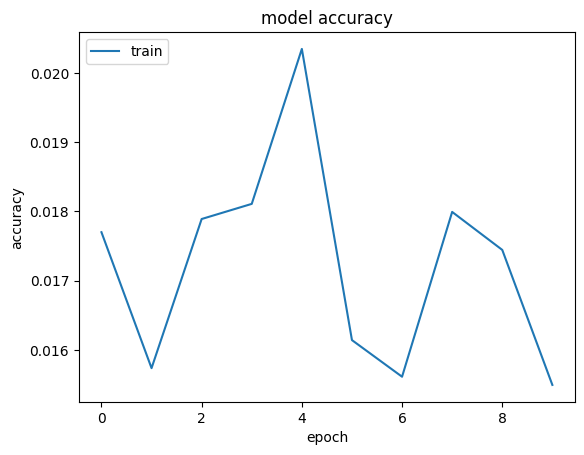

### new sentence: 145 (ff   nnnnnnnii of titu sosiiiiyyy of the dddddddlin an $A$ indnt a  -oebbaaarll     as a fonllluere
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9948 - loss: 0.0181
Epoch 1: loss improved from inf to 0.01559, saving model to checkpoints2/weights-improvement-01-0.0156-00146.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9949 - loss: 0.0179
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9953 - loss: 0.0171
Epoch 2: loss improved from 0.01559 to 0.01493, saving model to checkpoints2/weights-improvement-02-0.0149-00146.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9954 - loss: 0.0170
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9949 - loss: 0.0166
Epoch 3: loss did not improve from 0.01493
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9950 - loss: 0.0166
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9953 - loss: 0.0150
Epoch 4: loss did not

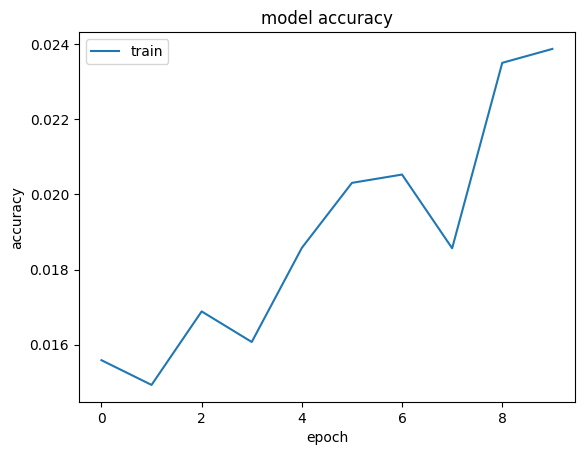

### new sentence: 146 (\f     fs nhsoos $(\'\)))bidrbrari A)$ii $b,\\alttt a),)$ bsd abpphcct dnsmncs)onnnsssssssssssccc H
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9930 - loss: 0.0243
Epoch 1: loss improved from inf to 0.02318, saving model to checkpoints2/weights-improvement-01-0.0232-00147.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9930 - loss: 0.0242
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9943 - loss: 0.0195
Epoch 2: loss improved from 0.02318 to 0.02083, saving model to checkpoints2/weights-improvement-02-0.0208-00147.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9943 - loss: 0.0196
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9943 - loss: 0.0188
Epoch 3: loss did not improve from 0.02083
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9942 - loss: 0.0190
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9919 - loss: 0.0248
Epoch 4: loss did not

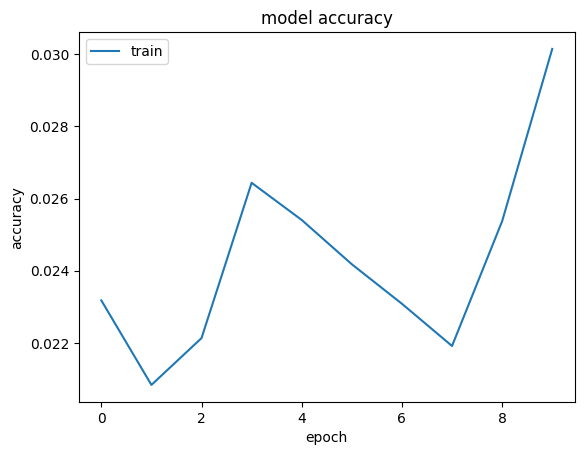

### new sentence: 147 \) ff nnn nnveeyyyeenlyy,cfveeara..A$Aiiriggggi on afftndttudnn $A$   Us a pippvaxaaa deceeeteeedmgs
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9907 - loss: 0.0299
Epoch 1: loss improved from inf to 0.03046, saving model to checkpoints2/weights-improvement-01-0.0305-00148.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9907 - loss: 0.0300
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9914 - loss: 0.0282
Epoch 2: loss improved from 0.03046 to 0.02834, saving model to checkpoints2/weights-improvement-02-0.0283-00148.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.9914 - loss: 0.0282
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9904 - loss: 0.0291
Epoch 3: loss improved from 0.02834 to 0.02776, saving model to checkpoints2/weights-improvement-03-0.0278-00148.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9905 - loss: 0.0291
Epoch 4/10
15/15 ━━━━━━━━━

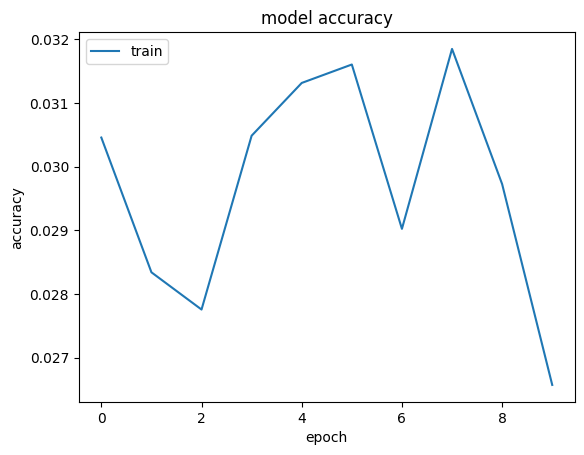

### new sentence: 148 (\f fn sne a nonttttivili if a sidelyyyyabi $A$  Tse $\\aatctlll(A),  Lsesseehhgg, H$ ihchheri teeth
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9906 - loss: 0.0319
Epoch 1: loss improved from inf to 0.03257, saving model to checkpoints2/weights-improvement-01-0.0326-00149.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9906 - loss: 0.0319
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9896 - loss: 0.0319
Epoch 2: loss improved from 0.03257 to 0.03209, saving model to checkpoints2/weights-improvement-02-0.0321-00149.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9896 - loss: 0.0319
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9890 - loss: 0.0335
Epoch 3: loss did not improve from 0.03209
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9890 - loss: 0.0337
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9908 - loss: 0.0298
Epoch 4: loss did not

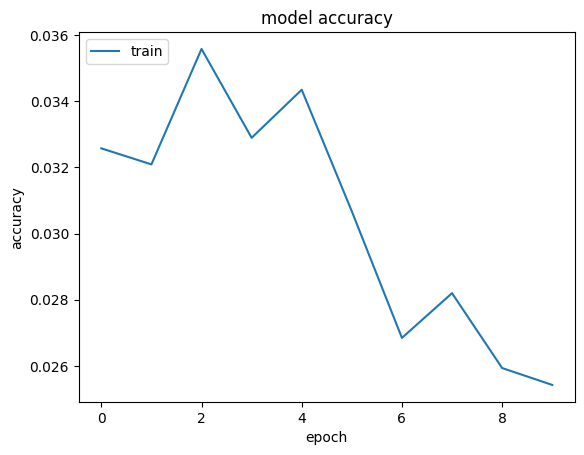

### new sentence: 149 (\fr A   Wh nhttl $\$\)=)biddraAAA$   iiiiibbab $,$,bsdrhpg   $(Wlera{{qhq Sl aatttltttthz A)$     W
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9931 - loss: 0.0209
Epoch 1: loss improved from inf to 0.02210, saving model to checkpoints2/weights-improvement-01-0.0221-00150.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9931 - loss: 0.0210
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9919 - loss: 0.0230
Epoch 2: loss improved from 0.02210 to 0.02110, saving model to checkpoints2/weights-improvement-02-0.0211-00150.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9920 - loss: 0.0228
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9928 - loss: 0.0210
Epoch 3: loss improved from 0.02110 to 0.02102, saving model to checkpoints2/weights-improvement-03-0.0210-00150.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9928 - loss: 0.0210
Epoch 4/10
15/15 ━━━━━━━━━

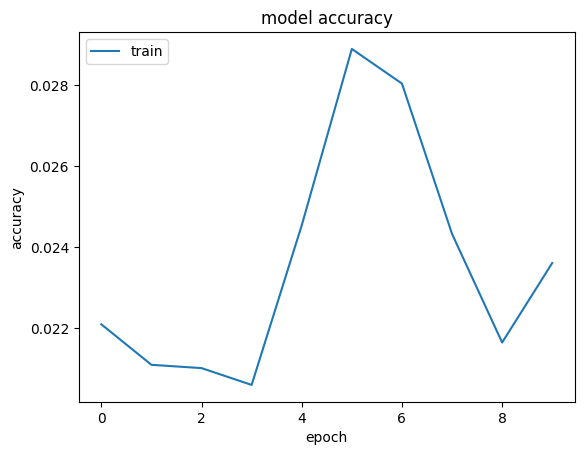

### new sentence: 150 \ffrrrnmmn t    bsd aba\ncnn anaaaaayeen and a pepghg ffee $Tentgaa:llbgg  aeiicriiy wf $*$an\ \mmmy
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9939 - loss: 0.0206
Epoch 1: loss improved from inf to 0.02160, saving model to checkpoints2/weights-improvement-01-0.0216-00151.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9939 - loss: 0.0207
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9925 - loss: 0.0201
Epoch 2: loss improved from 0.02160 to 0.02012, saving model to checkpoints2/weights-improvement-02-0.0201-00151.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9925 - loss: 0.0201
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9946 - loss: 0.0196
Epoch 3: loss improved from 0.02012 to 0.01999, saving model to checkpoints2/weights-improvement-03-0.0200-00151.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9946 - loss: 0.0197
Epoch 4/10
15/15 ━━━━━━━━━

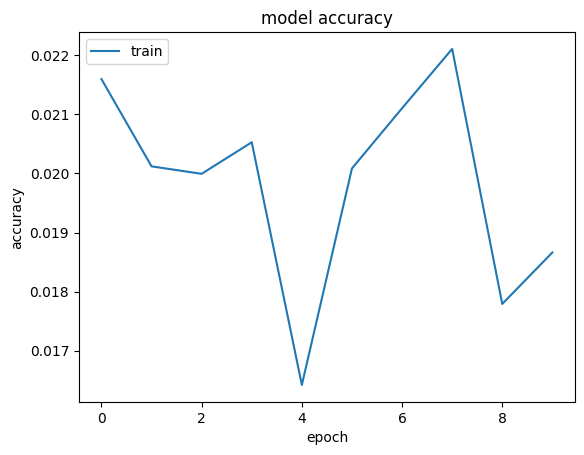

### new sentence: 151 (ff   nnnnnnnni c ciiiuuuu Fiies AAA )oo thowaaaa oieee  $$$iiniiss $(ze phos paat the tetnncoeeee $
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9948 - loss: 0.0176
Epoch 1: loss improved from inf to 0.01927, saving model to checkpoints2/weights-improvement-01-0.0193-00152.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9947 - loss: 0.0177
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9952 - loss: 0.0164
Epoch 2: loss improved from 0.01927 to 0.01688, saving model to checkpoints2/weights-improvement-02-0.0169-00152.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9952 - loss: 0.0164
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9948 - loss: 0.0152
Epoch 3: loss did not improve from 0.01688
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9947 - loss: 0.0154
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9946 - loss: 0.0161
Epoch 4: loss did not

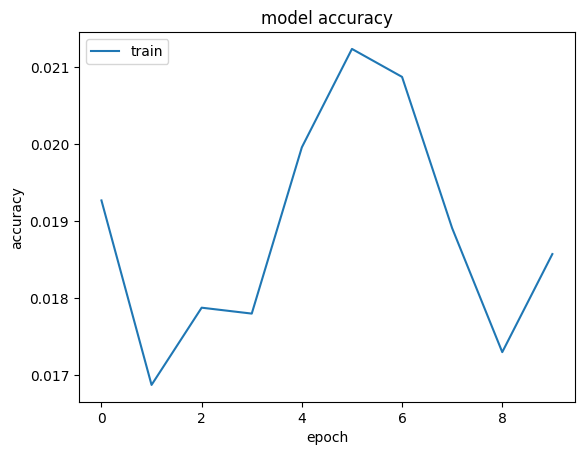

### new sentence: 152 \ffrhrnr A   Tee thpi cnane (\_2_laassss  whchh creettati intiitir $\$$ch $M$ ih a (inineeaalllii, n
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9950 - loss: 0.0163
Epoch 1: loss improved from inf to 0.01662, saving model to checkpoints2/weights-improvement-01-0.0166-00153.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - accuracy: 0.9950 - loss: 0.0163
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9952 - loss: 0.0140
Epoch 2: loss improved from 0.01662 to 0.01403, saving model to checkpoints2/weights-improvement-02-0.0140-00153.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9952 - loss: 0.0140
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9952 - loss: 0.0160
Epoch 3: loss did not improve from 0.01403
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.9952 - loss: 0.0160
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9944 - loss: 0.0188
Epoch 4: loss did not

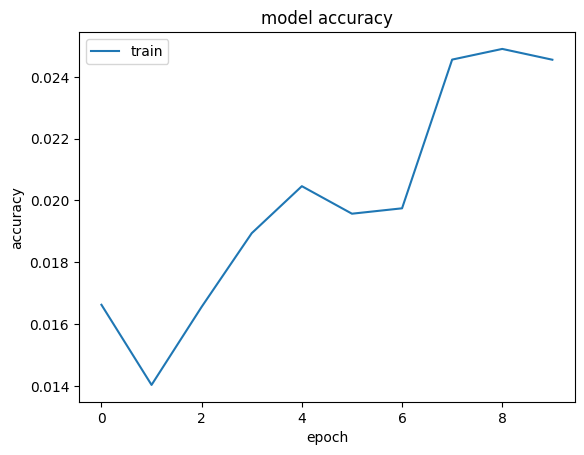

### new sentence: 153 \ffrrrnrnnn a A bnd $\maa((.  \h a gopemmllllniiin  \sd c pemp $$      ss sh soooettlsssssss,wf t dl
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9925 - loss: 0.0230
Epoch 1: loss improved from inf to 0.02351, saving model to checkpoints2/weights-improvement-01-0.0235-00154.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.9925 - loss: 0.0230
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9949 - loss: 0.0188
Epoch 2: loss improved from 0.02351 to 0.02037, saving model to checkpoints2/weights-improvement-02-0.0204-00154.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9949 - loss: 0.0189
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9939 - loss: 0.0214
Epoch 3: loss did not improve from 0.02037
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9939 - loss: 0.0214
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9933 - loss: 0.0199
Epoch 4: loss did not

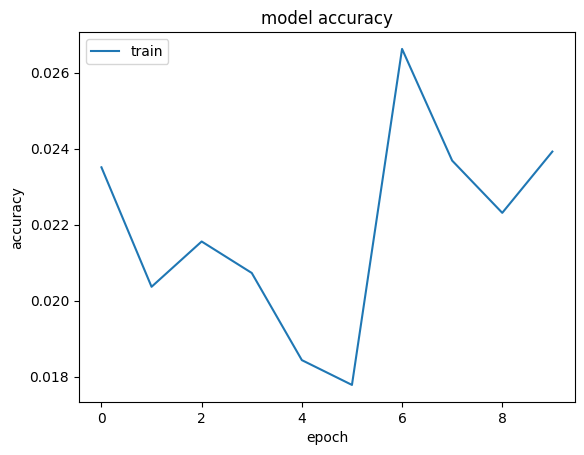

### new sentence: 154 (\f    nnnnsnni   iyiriiillii  ie pposottth th aironnttrrnnnn oeeeeeeeg.teeur mf $A$ ih a nernec los
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9928 - loss: 0.0247
Epoch 1: loss improved from inf to 0.02573, saving model to checkpoints2/weights-improvement-01-0.0257-00155.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9928 - loss: 0.0247
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9920 - loss: 0.0233
Epoch 2: loss improved from 0.02573 to 0.02550, saving model to checkpoints2/weights-improvement-02-0.0255-00155.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.9920 - loss: 0.0235
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9930 - loss: 0.0234
Epoch 3: loss improved from 0.02550 to 0.02431, saving model to checkpoints2/weights-improvement-03-0.0243-00155.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9930 - loss: 0.0234
Epoch 4/10
15/15 ━━━━━━━━━

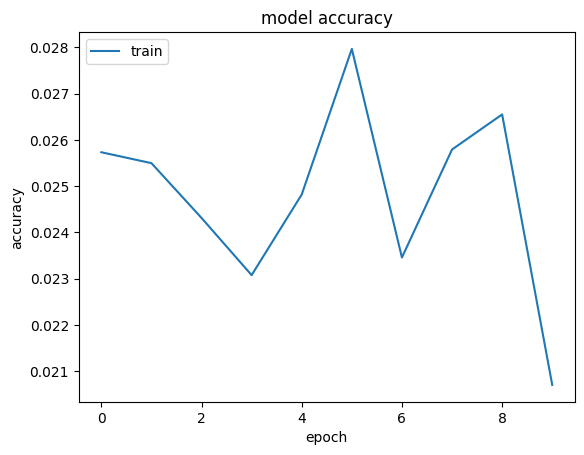

### new sentence: 155 (ffrnbnyy A   Tee $\$\eeeccccl(A$$   LL{eeehhhppo ,,$\(\,,iA,$(\sd alll aogi aoaabr $A$ is aoeenraaa
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9914 - loss: 0.0286
Epoch 1: loss improved from inf to 0.02723, saving model to checkpoints2/weights-improvement-01-0.0272-00156.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9914 - loss: 0.0285
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9904 - loss: 0.0272
Epoch 2: loss did not improve from 0.02723
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.9904 - loss: 0.0273
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9915 - loss: 0.0276
Epoch 3: loss did not improve from 0.02723
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9915 - loss: 0.0276
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9919 - loss: 0.0271
Epoch 4: loss did not improve from 0.02723
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.9918

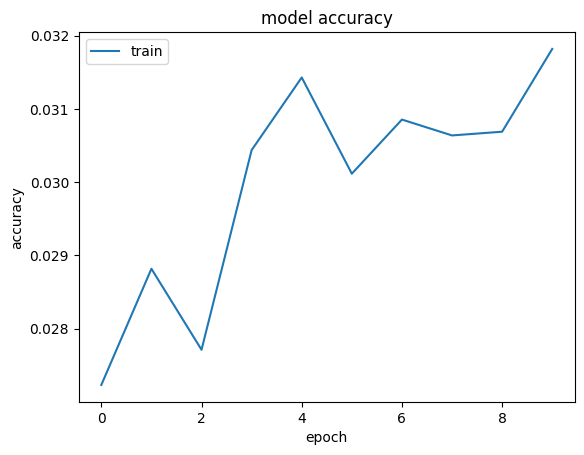

### new sentence: 156 \, ffnnnnnn if the semiiiii so a srpdc prngl $D$  Wed $A$ bed th d nonn $\$--hadtb,$A$ ,$A_mrcrgrg t
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9919 - loss: 0.0273
Epoch 1: loss improved from inf to 0.02807, saving model to checkpoints2/weights-improvement-01-0.0281-00157.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9919 - loss: 0.0274
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9911 - loss: 0.0290
Epoch 2: loss did not improve from 0.02807
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9911 - loss: 0.0290
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9911 - loss: 0.0297
Epoch 3: loss did not improve from 0.02807
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.9911 - loss: 0.0297
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9921 - loss: 0.0233
Epoch 4: loss improved from 0.02807 to 0.02301, saving model to checkpoints2/weights-improvement-04-0.

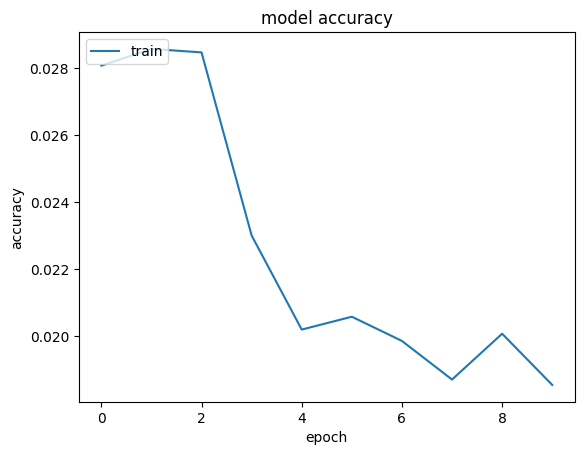

### new sentence: 157 \ffrbrnr A $ Tee $\\aeeccc{(A)ii thccc theee,$\eegaalll}   $*tpctht aldllrarnrnnn  \$ asd thp prmmpa
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9946 - loss: 0.0185
Epoch 1: loss improved from inf to 0.01881, saving model to checkpoints2/weights-improvement-01-0.0188-00158.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9946 - loss: 0.0185
Epoch 2/10
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9945 - loss: 0.0170

KeyboardInterrupt: 

In [ ]:

for i in range(19, RUNS):
  tmp = "-%05d.weights.h5"%i #setting a file to save this iteration
  filepath="checkpoints2/weights-improvement-{epoch:02d}-{loss:.4f}" + tmp
  checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
                               save_weights_only=True,
                             save_best_only=True, mode='min')
  callbacks_list = [checkpoint] #this checkpoint saves the model for this iteration
  history = model.fit(X, y, epochs=EPOCHS, batch_size=1280,
                    callbacks=callbacks_list, shuffle=True)

  plt.plot(history.history['loss'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  losses.append(history.history['loss'][-1])
  # The model weights (that are considered the best) are loaded into the model.
  pattern = dataX[start]
  try:
    generatecharacters(model, pattern, i)
  except ValueError:
    print('generatecharacters failed')

The loss is improving very slowly if at all. I am stopping it after 1570 epochs, a few hours, and several dead penguins.... Best we got was:

PROMPT: " given in this paper. A \[0,2\]-factor is Called a 2-factor, if its characteristic number is zero. That "


NEW SENTENCE:
\ffrbrnr A $ Tee $\\aeeccc\{(A)ii thccc theee,$\eegaalll\}   $*tpctht aldllrarnrnnn  \$ asd thp prmmpa

#Now fine tune a pretrained NLP model

In [ ]:
from fastai.text.all import language_model_learner, ColReader, RandomSplitter, TextDataLoaders, TextBlock, LMDataLoader, AWD_LSTM, DataLoader


In [120]:
from fastai.data.block import CategoryBlock, DataBlock
import pandas as pd
from fastai.text.all import Tokenizer, SubwordTokenizer, Numericalize

outF = open("textarxiv/myOutFile.txt", "r")
text = outF.read()
outF.close()
df = pd.DataFrame(data=text.split(". "), columns=["text"])
df

text
0                                                                                                                                                                  A masses of a leptons deduced from a representation of a probability density vector by a spinors
1                                                                                                                                       A massive W and Z bosons and a massless A boson are obtained from a transformations for which a density vector is invariant
2                                                                                                                                                                                                                     We give a partial answer to a conjecture of A
3                                                                                                                                                                                    Balog, concerning the size of AA+A, where A is a finite subset of real numbers
4                                                                                                                                                                               Also, we prove several new results on the cardinality of A:A+A, AA+AA and A:A + A:A
..                                                                                                                                                                                                                                                              ...
618  Further, a unital locally convex algebra $A$ is called continuous inverse algebra, or CIA for short, if its group of units $A^{\times}$ is open in $A$ and the inversion $\iota:A^{\times}\rightarrow A^{\times},\,\,\,a\mapsto a^{-1}$ is continuous at $1_A$
619                                                                                                                     For a compact manifold $M$, the Fr\'echet algebra of smooth functions $C^{\infty}(M)$ is the prototype of such a continuous inverse algebra
620                                                                             We show that if $A$ is a complete commutative CIA, $G$ a compact group and $(A,G,\alpha)$ a dynamical system, then each character of $B:=A^G$ can be extended to a character of $A$
621                                                                                                                In particular, the natural map on the level of the corresponding spectra $\Gamma_A\rightarrow\Gamma_B$, $\chi\mapsto\chi_{\mid B}$ is surjective
622                                                                                                                                                                                                                                                                

[623 rows x 1 columns]

In [121]:
df["label"] = "positive"

In [122]:
sp = Tokenizer(df)#vocab_sz=10000)
sp.setup(df)
sp.encodes(df)

text  \
0                                                                                                                                                                  A masses of a leptons deduced from a representation of a probability density vector by a spinors   
1                                                                                                                                       A massive W and Z bosons and a massless A boson are obtained from a transformations for which a density vector is invariant   
2                                                                                                                                                                                                                     We give a partial answer to a conjecture of A   
3                                                                                                                                                                                    Balog, concerning the size of AA+A, where A is a finite subset of real numbers   
4                                                                                                                                                                               Also, we prove several new results on the cardinality of A:A+A, AA+AA and A:A + A:A   
..                                                                                                                                                                                                                                                              ...   
618  Further, a unital locally convex algebra $A$ is called continuous inverse algebra, or CIA for short, if its group of units $A^{\times}$ is open in $A$ and the inversion $\iota:A^{\times}\rightarrow A^{\times},\,\,\,a\mapsto a^{-1}$ is continuous at $1_A$   
619                                                                                                                     For a compact manifold $M$, the Fr\'echet algebra of smooth functions $C^{\infty}(M)$ is the prototype of such a continuous inverse algebra   
620                                                                             We show that if $A$ is a complete commutative CIA, $G$ a compact group and $(A,G,\alpha)$ a dynamical system, then each character of $B:=A^G$ can be extended to a character of $A$   
621                                                                                                                In particular, the natural map on the level of the corresponding spectra $\Gamma_A\rightarrow\Gamma_B$, $\chi\mapsto\chi_{\mid B}$ is surjective   
622                                                                                                                                                                                                                                                                   

        label  
0    positive  
1    positive  
2    positive  
3    positive  
4    positive  
..        ...  
618  positive  
619  positive  
620  positive  
621  positive  
622  positive  

[623 rows x 2 columns]

In [124]:
text

'A masses of a leptons deduced from a representation of a probability density vector by a spinors. A massive W and Z bosons and a massless A boson are obtained from a transformations for which a density vector is invariant. We give a partial answer to a conjecture of A. Balog, concerning the size of AA+A, where A is a finite subset of real numbers. Also, we prove several new results on the cardinality of A:A+A, AA+AA and A:A + A:A. A rhombus tiling of a hexagon is said to be centered if it contains the central lozenge. We compute the number of vertically symmetric rhombus tilings of a hexagon with side lengths $a, b, a, a, b, a$ which are centered. When $a$ is odd and $b$ is even, this shows that the probability that a random vertically symmetric rhombus tiling of a $a, b, a, a, b, a$ hexagon is centered is exactly the same as the probability that a random rhombus tiling of a $a, b, a, a, b, a$ hexagon is centered. This also leads to a factorization theorem for the number of all rhombu

In [127]:
dls = TextDataLoaders.from_df(df, text_col='text', is_lm=True)
dls.show_batch()


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [128]:
# Create a language model learner
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.5)


In [129]:
# Check the number of parameters groups and the hyperparameters values
learn.create_opt()
print(f'number of parameters groups: {len(learn.opt.param_groups)}')

# ... and the list of Learning Rates (before its atualization by the Optimizer of the function fit_one_cycle())
for i,h in enumerate(learn.opt.hypers):
    print(i,h)

number of parameters groups: 4
0 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
1 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
2 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
3 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}


In [130]:
%%time
# loss, accuracy, Perplexity() of validation dataset
learn.validate()

CPU times: user 259 ms, sys: 17 ms, total: 276 ms
Wall time: 275 ms


(#1) [5.654523849487305]

In [131]:
learn.freeze()
learn.summary()

SequentialRNN (Input shape: 64 x 72)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 72 x 1152      
LSTM                                                           
LSTM                                                           
____________________________________________________________________________
                     64 x 72 x 400       
LSTM                                                           
RNNDropout                                                     
RNNDropout                                                     
RNNDropout                                                     
____________________________________________________________________________
                     64 x 72 x 896       
Linear                                    359296     True      
RNNDropout                                                     
____________________________________________________________________________

Total params: 359,296
Total t

CPU times: user 20.4 s, sys: 360 ms, total: 20.8 s
Wall time: 21.5 s


SuggestedLRs(valley=0.005248074419796467)

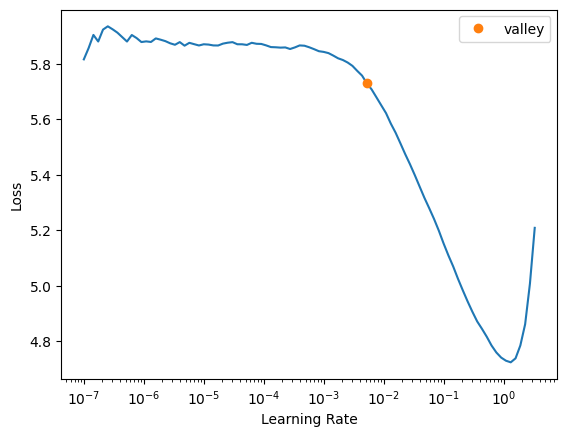

In [132]:
%%time
learn.lr_find()

In [133]:
learn.fit_one_cycle(10, 7e-3)


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

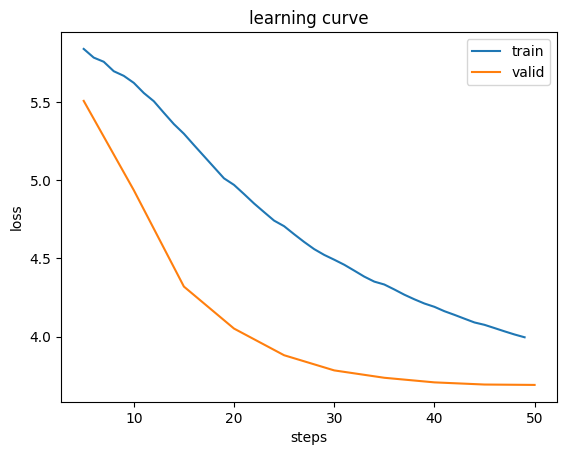

In [134]:
#hide
learn.recorder.plot_loss()

In [135]:
learn.fit_one_cycle(100, 7e-3)


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

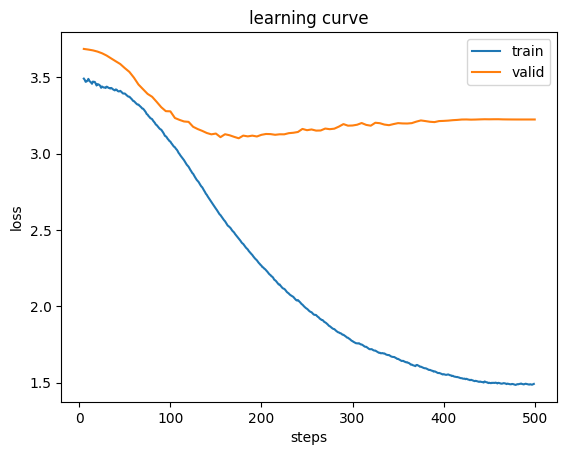

In [136]:
#hide
learn.recorder.plot_loss()

In [137]:
learn.save('AWD_LSTM_100epoch_lr2e-3')
learn = learn.load('AWD_LSTM_100epoch_lr2e-3')

CPU times: user 20 s, sys: 499 ms, total: 20.5 s
Wall time: 21.2 s


SuggestedLRs(valley=0.0030199517495930195)

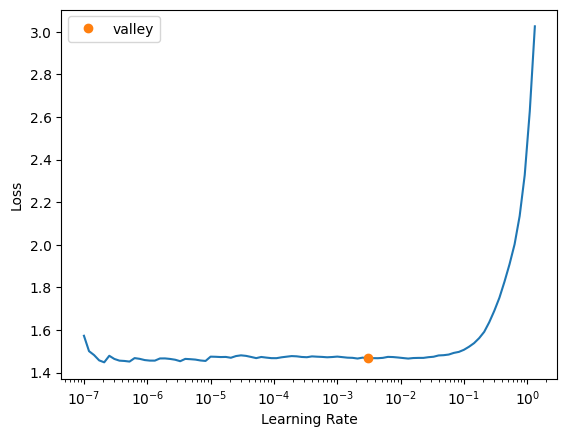

In [138]:
%%time
learn.lr_find()

In [139]:
learn.fit_one_cycle(100, 2e-3)

In [140]:
text[100:200]

'massive W and Z bosons and a massless A boson are obtained from a transformations for which a densit'

In [141]:
pattern = text[100:200]
learn.predict(pattern)

'xxunk w and z xxunk and a xxunk a xxunk are obtained from a xxunk for which a xxunk of'

In [146]:
for i in range(0,5000,1000):
  pattern = text[i:i+100]
  print(pattern + " | " + learn.predict(pattern))
  print()


A masses of a leptons deduced from a representation of a probability density vector by a spinors. A  | a xxunk of a xxunk xxunk from a representation of a probability density vector by a xxunk . a



 tilings of a hexagon which are centered. Let $A$ be a nonempty finite subset of an additive abelian | xxunk of a hexagon which are centered . Let $ a$ be a nonempty finite subset of an additive abelian group



hole shadows with a quite similar size and a shape for largely different black hole spin parameters  | hole xxunk with a xxunk similar size and a shape for xxunk different black hole spin parameters and



 of a black hole shadow. In this paper, we find the greatest values $\alpha_{1}$, $\alpha_{2}$, $\al | of a black hole shadow . In this paper , we find the xxunk values $ \ xxunk , $ \ xxunk , $ \ xxunk ,



ac{1-\beta_{6}}{Q(a,b)},$$ $$Q^{\alpha_{7}}(a,b)A^{1-\alpha_{7}}(a,b)<N_{QA}(a,b)<Q^{\beta_{7}}(a,b) | xxunk \ xxunk , b)},$$ $ $ q^ { \ xxunk , b)a^{1- \ xxunk , xxunk , b)<q^ { \ xxunk , b ) }



crashed again due to a typo... restarting from where i stopped: run 20

# later...
# notes:
- at the beginning it learns spaces, the most common character, and prints empty lines
- early most words are short and repeted obsessively
- in ~100 epochsit learns "the", "that" etc
- latex characters are not great ... they really confuse the LSTM
- much better if I start with a pretrained model! but still latex characters are causing confusion. Why?? cause they are words the original NN had never seen! they are not even words, so they are the thing the NN is trying to learn in fine tuning only, and its not making it really
